In [247]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle
import logging
import sys
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


from matplotlib import pyplot as plt
import json
import re

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # When cudnn implementation not found, run this
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Note: when starting kernel, for gpu_available to be true, this needs to be run
# only reserve 1 GPU
os.environ['TFHUB_CACHE_DIR'] = '/home/anasab/tf_cache'


In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# # confirm PyTorch sees the GPU
# from torch import cuda
# assert cuda.is_available()
# assert cuda.device_count() > 0
# print(cuda.get_device_name(cuda.current_device()))

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3431631627159801543,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8910092503156153153
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7839989760
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11211423501550573564
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12405901940991862560
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Lambda, BatchNormalization, TimeDistributed, \
    Bidirectional, Input, concatenate, Flatten, RepeatVector, Activation, Multiply, Permute, \
    Conv1D, GlobalMaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

from keras.utils import np_utils

from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords

import tensorflow as tf


Using TensorFlow backend.


In [6]:
dataset_type = "combined"
transfer_type = None

In [7]:
# transfer_type

In [8]:
logger = logging.getLogger('training')
ch = logging.StreamHandler(sys.stdout)
# create formatter
formatter = logging.Formatter("%(asctime)s;%(levelname)s;%(message)s")
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)
logger.setLevel(logging.DEBUG)

In [9]:
import sys
sys.setrecursionlimit(10000)

In [10]:
# tf.enable_eager_execution()
my_seed = 1234
# tf.set_random_seed(my_seed)

In [11]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [12]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Read data

In [13]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [14]:
root_dir = '/home/anasab/' 
# root_dir = '/home/ana/'

### eRisk 2020 T1

In [15]:
# datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
# labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

datadirs_T1_2020 = {
    'train': ['./data/'],
    'test': ['./DATA/']
}
datadir_root_T1_2020 = {
    'train': root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/',
    'test': root_dir + '/eRisk/data/2020/T1/'
}
    
labels_files_T1_2020 = {
    'train': ['golden_truth.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [16]:
def read_texts_2020(datadir_root_T1_2020,
                   datadirs_T1_2020,
                   labels_files_T1_2020,
                   test_suffix='0000',
                    chunked_subsets=None):


    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()
#     for subset in ('train', 'test'):
    for subset in ('test',):
        for subdir in [os.path.join(datadir_root_T1_2020[subset], subp) for subp in datadirs_T1_2020[subset]]:

            for subject_file in os.listdir(subdir):
                writings[subset].extend(read_subject_writings(os.path.join(subdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2020[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2020[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df


### eRisk 2019 T1 (Anorexia)

In [17]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [18]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000',
                    chunked_subsets='train'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset in chunked_subsets:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                print(chunkdir)
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

### eRisk 2018 (Depression)

In [19]:
datadirs_T1_2018 = {
    'train': ['train/positive_examples_anonymous_chunks/', 'train/positive_examples_anonymous_chunks/', 'test/'],
    'test': ['task 1 - depression (test split, train split is 2017 data)/']
}
datadir_root_T1_2018 = {
    'train': root_dir + '/eRisk/data/2017/',
    'test': root_dir + '/eRisk/data/2018/'
}
    
labels_files_T1_2018 = {
    'train': ['train/risk_golden_truth.txt', 'test/test_golden_truth.txt'],
    'test': ['task 1 - depression (test split, train split is 2017 data)/risk-golden-truth-test.txt']
}

## CLPsych


In [20]:
datadirs_clpsych = {
    'train': [''],
    'test': ['']
}
datadir_root_clpsych = {
    'train': root_dir + '/eRisk/data/clpsych/final_training_data/',
    'test': root_dir + '/eRisk/data/clpsych/final_testing_data/'
}
    
labels_files_clpsych = [root_dir + '/eRisk/data/clpsych/anonymized_user_info_by_chunk.csv']

In [21]:
def read_subject_data_clpsych(subject_file):
    writings = []
    with open(subject_file, "rt", encoding="utf-8") as sf:
        user = subject_file.split("/")[-1].split(".")[0]
        print(subject_file)

        for line in sf:
            data = json.loads(line)#.encode('utf-16','surrogatepass').decode('utf-16'))
            data['subject'] = user
            writings.append(data)
    return writings

In [22]:
def read_texts_clpsych(datadir_root_clpsych,
                   datadirs_clpsych,
                   labels_files_T1_2019,
                      label_by=['depression']):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('test',):#, 'test'):
        for subdir in [os.path.join(datadir_root_clpsych[subset], subp) for subp in datadirs_clpsych[subset]]:
            for subject_file in glob.glob(subdir + "/*.tweets"):
#                 if subject_file.split("/")[-1] != 'sZVVktDN8qqjA.tweets':
#                     continue
                writings[subset].extend(read_subject_data_clpsych(os.path.join(subdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

    for label_file in labels_files_clpsych:
        labels = pd.read_csv(label_file, 
                    names=['subject','age','num_tweets','gender','condition','chunk_index'])
        labels['label'] = labels['condition'].apply(lambda c: 1 if c in label_by else 0)
        
        labels_df = pd.concat([labels_df, labels])
        labels_df = labels_df.drop_duplicates()
        labels_df = labels_df.set_index('subject')

        # TODO: this deduplication throws some unicode, surrogates not allowed, exception
#     writings_df = writings_df.drop_duplicates(subset=['id', 'subject', 'subset', 'created_at', 'text'])
    
    writings_df = writings_df.join(labels_df, on='subject')
    writings_df['date'] = writings_df['created_at']
    
    return writings_df

### Symanto

In [23]:
def read_texts_symanto(tsv_path="/eRisk/data/symanto/clean_dataset_with_timeline_balancedUsers.tsv"):
    label_key = {'REAL_LABEL_IS_DEPRESSED': 1,
             'REAL_LABEL_IS_NON_DEPRESSED': 0}
    prediction_key = {'predicted_as_depressed': 1,
                     'predicted_as_non_depressed': 0,
                     'DEPRESS_STRING_WAS_MENTIONED': -1}
    
    writings_df = pd.read_csv(root_dir + tsv_path, 
                              sep='\t', names=['subject', 'date', 'text', 'prediction_text', 'real_label_text'])

    writings_df = writings_df.dropna()
    writings_df['label'] = writings_df['real_label_text'].apply(lambda l: label_key[l])
    writings_df['prediction'] = writings_df['prediction_text'].apply(lambda l: prediction_key[l])
#     By ommitting -1s we are excluding tweets where "DEPRESSED" was mentioned, and all after
    writings_df = writings_df.drop(writings_df[writings_df['prediction']==-1].index)

    
    return writings_df

## Preprocess text

In [24]:
# writings_df

In [25]:
# writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
# writings_df_depression = read_texts_2019(datadir_root_T1_2018,
#                    datadirs_T1_2018,
#                    labels_files_T1_2018,
#                              chunked_subsets=['train', 'test'])

if dataset_type == "combined":
    writings_df_selfharm = pickle.load(open('data/writings_df_selfharm_all', 'rb'))
    writings_df_anorexia = pickle.load(open('data/writings_df_anorexia_liwc', 'rb'))
    writings_df_depression = pickle.load(open('data/writings_df_depression_liwc', 'rb'))
    writings_df_selfharm['source'] = 'selfharm'
    writings_df_anorexia['source'] = 'anorexia'
    writings_df_depression['source'] = 'depression'
    writings_df = pd.DataFrame()
    writings_df = pd.concat([writings_df, writings_df_depression])
    writings_df = pd.concat([writings_df, writings_df_selfharm])
    writings_df = pd.concat([writings_df, writings_df_anorexia])
elif dataset_type == "combined_depr":
    writings_df = pd.DataFrame.from_dict(json.load(open('data/writings_df_depression_all.json')))
elif dataset_type == "clpsych":
    writings_df = pd.DataFrame.from_dict(json.load(open('data/writings_df_%s_liwc_affect.json' % dataset_type)))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = pd.DataFrame.from_dict(json.load(open('writings_df_%s_test.json' % dataset_type)))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
    label_by = ['depression', 'ptsd']
    writings_df.drop(writings_df[writings_df['condition']=='depression'].index, inplace=True)
#     writings_df['label'] = writings_df['condition'].apply(lambda c: 1 if c in label_by else 0)
#     writings_df['date'] = writings_df['created_at']
elif dataset_type == "symanto":
    writings_df = read_texts_symanto()
elif dataset_type == 'selfharm':
    writings_df = pickle.load(open('data/writings_df_%s_all' % dataset_type, 'rb'))
elif dataset_type in ["depression", "anorexia", "selfharm"]:
    writings_df = pickle.load(open('data/writings_df_%s_liwc' % dataset_type, 'rb'))
else:
    logger.error("Unknown dataset %s" % dataset_type)

In [26]:
# writings_df[writings_df['condition']!='control'].head(150)[['label', 'condition', 'date']]

In [27]:
# writings_df.label.hist()

In [28]:
# writings_df.head()

In [29]:
# writings_df

In [30]:
regtokenizer = RegexpTokenizer(r'\w+')
tweet_tokenizer = TweetTokenizer()
sw = stopwords.words("english")

def tokenize(t, tokenizer=regtokenizer):
    return regtokenizer.tokenize(t.lower())

def tokenize_tweets(t, stop=True):
    tokens = tweet_tokenizer.tokenize(t.lower())
    tokens_clean = [re.sub("^#", "", token) for token in tokens]
    tokens_clean = [token for token in tokens_clean 
                            if re.match("^[a-z]*$", token)]
    if not stop:
        tokens_clean = [token for token in tokens
                       if (token not in sw)]
    return tokens_clean
    

In [31]:
# re.sub("^#", "", "#h#ash")

In [32]:
def tokenize_fields(writings_df, tokenize_fct=tokenize, columns=['title', 'text']):
    for c in columns:
        writings_df['tokenized_%s' % c] = writings_df['%s' % c].apply(lambda t: tokenize_fct(t) 
                                                                if type(t)==str and t else None)
        writings_df['%s_len' % c] = writings_df['tokenized_%s' % c].apply(lambda t: len(t) 
                                                                    if type(t)==list and t else None)
    return writings_df

In [33]:
# writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize_tweets, columns=['title'])
# writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize_tweets, columns=['text'])
# writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize, columns=['text'])

In [34]:
# writings_df.text_len.describe()

In [35]:
# writings_df.title_len.describe()

In [36]:
# writings_df.groupby('subject').mean().describe()

In [37]:
# writings_df.groupby('subject').max().groupby('label').count()

In [38]:
# print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
# print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


In [39]:
# writings_df.groupby('subject').count().title.describe()

In [40]:
# writings_df.groupby('subject').count().text.describe()

In [41]:
# writings_df.tokenized_text.head()

In [42]:
# writings_dict = writings_df.to_dict()
# json.dump(writings_dict, open("writings_df_clpsych_all.json", "w+"))

In [43]:
# print("Total examples", writings_df[['subject', 'subset', 'label'
#                                     ]].groupby('subject').min().groupby('subset').count())
# print("Positive examples", writings_df[['subject', 'subset', 'label'
#                                     ]].groupby('subject').min().groupby('subset').sum())

In [44]:
writings_df[['label', 'source']].groupby('source').sum()

label
source           
anorexia    42487
depression  90215
selfharm    18883

In [45]:
writings_df['text'] = writings_df['text'].fillna("")
writings_df['title'] = writings_df['title'].fillna("")

# Recurrent NN

## Extract features and encode data

In [229]:
def save_model_and_params(model, model_path, hyperparams, hyperparams_features):
    model.save_weights(model_path + "_weights.h5", save_format='h5')
    model.save_weights(model_path + "_weights")
#     model.save(model_path + "_model.model")
#     model.save(model_path + "_model.h5")
    with open(model_path + '.hp.json', 'w+') as hpf:
        hpf.write(json.dumps({k:v for (k,v) in hyperparams.items() if k!='optimizer'}))
    with open(model_path + '.hpf.json', 'w+') as hpff:
        hpff.write(json.dumps(hyperparams_features))

In [47]:
def load_params(model_path):
    with open(model_path + '.hp.json', 'r') as hpf:
        hyperparams = json.loads(hpf.read())
    with open(model_path + '.hpf.json', 'r') as hpff:
        hyperparams_features = json.loads(hpff.read())
    return hyperparams, hyperparams_features

In [48]:
hyperparams_features = {
    "max_features": 20002,
    # cut texts after this number of words
    # (among top max_features most common words)
    "embedding_dim": 100,
    'vocabulary_path': 'data/all_vocab_clpsych_erisk_stop_20000.pkl',
#     'embeddings_path': root_dir + '/eRisk/embeddings/finetuned_glove_clpsych_erisk_stop_normalized_20000.pkl',
    'embeddings_path': root_dir + '/resources/glove.840B/glove.840B.300d.txt',
    'liwc_words_cached': 'data/liwc_categories_for_vocabulary_erisk_clpsych_stop_20K.pkl',
    "user_level": True, # deprecated
    "transfer": transfer_type,
    "pretrained_model_path": 'models/lstm_clpsych_seq52',
}


In [49]:
if transfer_type:
    pretrained_model_path = hyperparams_features['pretrained_model_path']
    hyperparams, hyperparams_features = load_params(hyperparams_features['pretrained_model_path'])
    hyperparams_features['pretrained_model_path'] = pretrained_model_path

### Emotions

In [50]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [51]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative and len(tokens):
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [52]:
from liwc_readDict import readDict

liwc_dict = {}
for (w, c) in readDict(root_dir + '/resources/liwc.dic'):
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)

categories = set(liwc_dict.keys())
len(categories)

64

In [53]:
liwc_categories=[c for c in categories]# if c in writings_df.columns]

In [83]:
liwc_words_for_categories = pickle.load(open("data/liwc_categories_for_vocabulary_erisk_clpsych_stop_20K.pkl", "rb"))

In [84]:
with open("liwc_categories.txt","w+") as f:
    for cat in liwc_dict:
        f.write("%s: %s\n" % (cat, ",".join(liwc_dict[cat])))

In [85]:
with open("nrc_emotions.txt","w+") as f:
    for cat in nrc_lexicon:
        f.write("%s: %s\n" % (cat, ",".join(nrc_lexicon[cat])))

### Style features

#### Char n-grams

In [86]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [87]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return 0
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative and text_len:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [88]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

## BERT


In [89]:
import tensorflow_hub as hub
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
from bert.tokenization import FullTokenizer



ModuleNotFoundError: No module named 'tensorflow_hub'

In [90]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [91]:
def encode_text_for_bert(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

#     if isinstance(example, PaddingInputExample):
#         input_ids = [0] * max_seq_length
#         input_mask = [0] * max_seq_length
#         segment_ids = [0] * max_seq_length
#         label = 0
#         return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label



In [92]:
def create_tokenizer_from_hub_module(sess):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [93]:
def initialize_sess(sess=None):
    if not sess:
        sess_config = tf.ConfigProto(
            device_count={ 'GPU' : 1, 'CPU': 4 },
            intra_op_parallelism_threads = 0,
            inter_op_parallelism_threads = 4,
            allow_soft_placement=False,
            log_device_placement=True,
        )
        sess_config.gpu_options.allow_growth = True
        sess_config.gpu_options.per_process_gpu_memory_fraction = 1
        sess = tf.Session(config=sess_config)

    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
    return sess

In [94]:
def load_saved_model(model_path, hyperparams):
    metrics_class = Metrics(threshold=hyperparams['threshold'])
    dependencies = {
    'f1_m': metrics_class.f1_m,
    'auc': metrics_class.auc,
    'precision_m': metrics_class.precision_m,
    'recall_m': metrics_class.recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom,
    'BertLayer': BertLayer
    }
#     loaded_model = load_model(model_path + "_model.h5", custom_objects=dependencies)
    loaded_model = load_model(model_path + "_model.model", custom_objects=dependencies)
    return loaded_model

In [95]:
tf.test.is_gpu_available()

True

### Encode data

In [96]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories, by_subset=True,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, test_slice=2,
                    nr_slices=5,
                    min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None, labelcol='label',
                   logger=logger):
    logger.debug("Loading data...\n")
    
    ## Build vocabulary
    vocabulary_all = {}
    word_freqs = Counter()
    
    for words in writings_df.tokenized_text:
        word_freqs.update(words)
    if 'tokenized_title' in writings_df.columns:
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
    i = 1
    for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
        if len(w) < min_word_len:
            continue
        vocabulary_all[w] = i
        i += 1
    if not vocabulary:
        vocabulary = vocabulary_all
    else:
        logger.info("Words not found in the vocabulary: %d\n" % len(set(vocabulary_all.keys()).difference(
            set(vocabulary.keys()))))

    if labelcol != 'label':
        label_index = {}
        l = 0
        for label in set(writings_df[labelcol]):
            label_index[label] = l
            l += 1
    print("Label index", label_index)
   
    if by_subset and 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        logger.info("%d training subjects, %d test subjects\n" % (training_subjects_size, test_subjects_size))
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}

    user_level_texts = {}
    for row in writings_df.sort_values(by='date').itertuples():
        words = []
        raw_text = ""
        if hasattr(row, 'tokenized_title'):
            if row.tokenized_title:
                words.extend(row.tokenized_title)
                raw_text += row.title
        if hasattr(row, 'tokenized_text'):
            if row.tokenized_text:
                words.extend(row.tokenized_text)
                raw_text += row.text
        if not words or len(words)<min_post_len:
#             logger.debug(row.subject)
            continue
        if labelcol == 'label':
            label = row.label
        else:
            label = label_index[getattr(row, labelcol)]
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
            user_level_texts[row.subject]['raw'] = [raw_text]
        else:
            user_level_texts[row.subject]['texts'].append(words)
            user_level_texts[row.subject]['liwc'].append(liwc_categs)
            user_level_texts[row.subject]['raw'].append(raw_text)
            
    return user_level_texts, subjects_split, vocabulary



In [97]:
# del writings_df['tokenized_title']


In [98]:
vocabulary_list = pickle.load(open(hyperparams_features['vocabulary_path'], 'rb'))
vocabulary_dict={}
for i,w in enumerate(vocabulary_list):
    vocabulary_dict[w] = i
user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
#                                                            vocabulary=pickle.load(open('vocabulary_40K_all.pkl', 'rb')),
#                                                            vocabulary=pickle.load(open('vocab_clpsych_10000.pkl', 'rb')),
                                                              vocabulary=vocabulary_dict,
                                                              by_subset=True,
                                                              labelcol = 'source'
                                                                               )

2021-01-12 12:07:15,694;DEBUG;Loading data...

2021-01-12 12:07:24,103;INFO;Words not found in the vocabulary: 2022

Label index {'selfharm': 0, 'anorexia': 1, 'depression': 2}
2021-01-12 12:07:25,058;DEBUG;894 training users, 383 validation users, 1924 test users.


In [99]:
# writings_df['subset'] = writings_df['subject'].apply(lambda s: 'test' if s in subjects_split['test'] else 'train')

In [100]:
len(vocabulary_dict)

20000

In [101]:
writings_df['tokenized_text'].head()

0    [thing, is, these, are, shown, on, irish, tv, ...
1                                           [spot, on]
2                                   [all, 3, of, them]
3    [oh, man, i, love, rottweilers, they, re, awes...
4    [another, reason, why, i, love, the, yogscast,...
Name: tokenized_text, dtype: object

<AxesSubplot:>

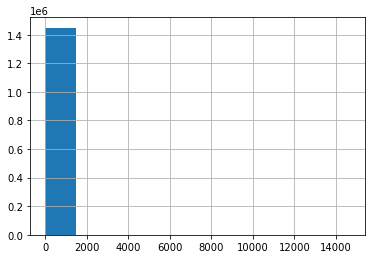

In [102]:
writings_df.text_len.hist()

In [103]:
# pickle.dump(writings_df, open('writings_df_selfharm_liwc_subsets', 'wb+'))

In [104]:
sorted(vocabulary.items(), key=lambda t:t[1])

[('bookstore', 0),
 ('weeds', 1),
 ('matty', 2),
 ('manufacture', 3),
 ('exchanges', 4),
 ('lag', 5),
 ('huge', 6),
 ('psychopath', 7),
 ('unnecessarily', 8),
 ('melania', 9),
 ('naturally', 10),
 ('perspectives', 11),
 ('legendary', 12),
 ('barbarian', 13),
 ('fatalities', 14),
 ('related', 15),
 ('inflated', 16),
 ('landslide', 17),
 ('winter', 18),
 ('legality', 19),
 ('upstairs', 20),
 ('papa', 21),
 ('blatantly', 22),
 ('oregon', 23),
 ('offend', 24),
 ('spears', 25),
 ('boom', 26),
 ('lrt', 27),
 ('snarky', 28),
 ('shallow', 29),
 ('illustrator', 30),
 ('cups', 31),
 ('airlines', 32),
 ('l', 33),
 ('twilight', 34),
 ('espresso', 35),
 ('creek', 36),
 ('swearing', 37),
 ('abomination', 38),
 ('boosie', 39),
 ('snowman', 40),
 ('recipes', 41),
 ('wiretap', 42),
 ('fapping', 43),
 ('intoxicated', 44),
 ('phrased', 45),
 ('oppression', 46),
 ('remix', 47),
 ('sailor', 48),
 ('lewis', 49),
 ('they', 50),
 ('shin', 51),
 ('airconsole', 52),
 ('accused', 53),
 ('spike', 54),
 ('delay', 

In [380]:
# session_collection = {}
# models_collection = {}
# hyperparams_collection = {}
user_level_data['subject57080000']['label']

0

### Data Generator

In [423]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, session=None, use_bert=False, set_type='train',
                 batch_size=32, seq_len=512, vocabulary=vocabulary,
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 hierarchical=False, pad_value=0, padding='pre',
                 post_groups_per_user=None, posts_per_group=10, post_offset = 0,
                 sampling_distr_alfa=0.1, sampling_distr='exp', # 'exp', 'uniform'
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], liwc_categories=liwc_categories,
                 liwc_dict=liwc_dict, compute_liwc=False, liwc_words_for_categories=None,
                 pad_with_duplication=False,
                 max_posts_per_user=None, sample_seqs=True,
                 shuffle=True, return_subjects=False, keep_last_batch=True, class_weights=None,
                classes=1):
        'Initialization'
        self.seq_len = seq_len
        # Instantiate tokenizer
        if session:
            self.bert_tokenizer = create_tokenizer_from_hub_module(session)
            session.run(tf.local_variables_initializer())
            session.run(tf.global_variables_initializer())
            session.run(tf.tables_initializer())
        else:
            if use_bert:
                logger.error("Need a session to use bert in data generation")
            self.bert_tokenizer = None
        self.use_bert = use_bert
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.hierarchical = hierarchical
        self.data = user_level_data
        self.pad_value = pad_value
        self.return_subjects = return_subjects
        self.sampling_distr_alfa = sampling_distr_alfa
        self.sampling_distr = sampling_distr
        self.emotions = emotions
        self.pronouns = pronouns
        self.liwc_categories = liwc_categories
        self.liwc_dict = liwc_dict
        self.liwc_words_for_categories = liwc_words_for_categories
        self.compute_liwc = compute_liwc
        self.sample_seqs = sample_seqs
        self.pad_with_duplication = pad_with_duplication
        self.padding = padding
        self.keep_last_batch = keep_last_batch
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.vocabulary = vocabulary
        self.max_posts_per_user = max_posts_per_user
        self.post_groups_per_user = post_groups_per_user
        self.post_offset = post_offset
        self.posts_per_group = posts_per_group
        self.classes = classes
        self.class_weights = class_weights
        self.generated_labels = []
        self.__post_indexes_per_user()
        self.on_epoch_end()
        
    @staticmethod
    def _random_sample(population_size, sample_size, sampling_distr, alfa=0.1, replacement=False):
        if sampling_distr == 'exp':
            # Exponential sampling
            sample = sorted(np.random.choice(population_size, 
                            min(sample_size, population_size),
                            p = DataGenerator.__generate_reverse_exponential_indices(population_size, alfa),
                            replace=replacement))
                                                                # if pad_with_duplication, 
                                                                # pad by adding the same post multiple times
                                                                # if there are not enough posts
        elif sampling_distr == 'uniform':
            # Uniform sampling
            sample = sorted(np.random.choice(population_size,
                            min(sample_size, population_size),
                            replace=replacement))
        return sample
    
    @staticmethod
    def __generate_reverse_exponential_indices(max_index, alfa=1):
        probabilities = []
        for x in range(max_index):
            probabilities.append(alfa * (np.exp(alfa*x)))
        reverse_probabilities = [p for p in probabilities]
        sump = sum(reverse_probabilities)
        normalized_probabilities = [p/sump for p in reverse_probabilities]
        return normalized_probabilities
    
    def __post_indexes_per_user(self):
        self.indexes_per_user = {u: [] for u in range(len(self.subjects_split[self.set]))}
        self.indexes_with_user = []
        self.item_weights = []
        for u in range(len(self.subjects_split[self.set])):
            if self.subjects_split[self.set][u] not in self.data:
                logger.warning("User %s has no posts in %s set. Ignoring.\n" % (
                    self.subjects_split[self.set][u], self.set))
                continue
            user_posts = self.data[self.subjects_split[self.set][u]]['texts']
            if self.max_posts_per_user:
                user_posts = user_posts[:self.max_posts_per_user]
            nr_post_groups = int(np.ceil(len(user_posts) / self.posts_per_group))
            
            if self.post_groups_per_user:
                nr_post_groups = min(self.post_groups_per_user, nr_post_groups)
            for i in range(nr_post_groups):
                # Generate random ordered samples of the posts
                if self.sample_seqs:
                    indexes_sample = DataGenerator._random_sample(population_size=len(user_posts),
                                                         sample_size=self.posts_per_group,
                                                         sampling_distr=self.sampling_distr,
                                                         alfa=self.sampling_distr_alfa,
                                                         replacement=self.pad_with_duplication)
                    self.indexes_per_user[u].append(indexes_sample)
                    self.indexes_with_user.append((u, indexes_sample))
                    # break # just generate one?
                # Generate all subsets of the posts in order
                # TODO: Change here if you want a sliding window
                else:
                    self.indexes_per_user[u].append(range(i*self.posts_per_group + self.post_offset,
                                                        min((i+1)*self.posts_per_group + self.post_offset, len(user_posts))))
                    self.indexes_with_user.append((u, range(i*self.posts_per_group ,
                                                        min((i+1)*self.posts_per_group + self.post_offset, len(user_posts)))))

        if self.class_weights:
        for item in self.indexes_with_user:
            u, _ = item
            s = self.subjects_split[self.set][u]
            # Note: weight 1 is default.
            try:
                self.item_weights.append(1./self.class_weights[self.data[s]['label']])
            except Exception as e:
                self.item_weights.append(1)
                logger.error("Could not compute item weight for user %s. " % s + str(e) + "\n")
                    
    def __encode_text(self, tokens, raw_text):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [self.vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        if not self.compute_liwc:
            encoded_liwc = None
        else:
            encoded_liwc = self.__encode_liwc_categories(tokens)
        if self.bert_tokenizer:
            bert_ids, bert_masks, bert_segments, label = encode_text_for_bert(self.bert_tokenizer, InputExample(None, 
                                               raw_text), self.seq_len)
        else:
            bert_ids, bert_masks, bert_segments = [[0]*self.seq_len, [0]*self.seq_len, [0]*self.seq_len]
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc,
               bert_ids, bert_masks, bert_segments)
    
    def __encode_liwc_categories_full(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            category_words = self.liwc_dict[category]
            for t in tokens:
                for word in category_words:
                    if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                    or (t==word.split("'")[0]):
                        categories_cnt[i] += 1
                        break # one token cannot belong to more than one word in the category
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
        
    def __encode_liwc_categories(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            for t in tokens:
                if t in self.liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.keep_last_batch:
            return int(np.ceil(len(self.indexes) / self.batch_size)) # + 1 to not discard last batch
        return int((len(self.indexes))/self.batch_size)
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Reset generated labels
        if index == 0:
             self.generated_labels = []
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find users
        user_indexes = [t[0] for t in indexes]
        users = set([self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()]) # TODO: maybe needs a warning that user is missing
        post_indexes_per_user = {u: [] for u in users}
        # Sample post ids
        for u, post_indexes in indexes:
            user = self.subjects_split[self.set][u]
            # Note: was bug here - changed it into a list
            post_indexes_per_user[user].append(post_indexes)

        # Generate data
        if self.hierarchical:
            X, s, y = self.__data_generation_hierarchical(users, post_indexes_per_user)
        else:
            X, s, y = self.__data_generation(users, post_indexes_per_user)

        if self.return_subjects:
            return X, s, y
        else:
            return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.indexes_with_user
#         np.arange(len(self.subjects_split[self.set]))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        if self.class_weights:
            # Sample users according to class weight (Or do this for each batch instead?)
            normalized_weights = [w/sum(self.item_weights) for w in self.item_weights]
            random_user_indexes = np.random.choice(len(self.indexes_with_user), 
                            len(self.indexes_with_user),
                            p = normalized_weights, replace=True)
            self.indexes = [self.indexes_with_user[i] for i in random_user_indexes]
    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        bert_ids_data = []
        bert_masks_data = []
        bert_segments_data = []
        labels = []

        for subject in users:

            if 'label' in self.data[subject]:
                label = self.data[subject]['label']
            else:
                label = None

            
            all_words = []
            all_raw_texts = []
            liwc_aggreg = []

            for post_index_range in post_indexes[subject]:
                # Sample
                texts = [self.data[subject]['texts'][i] for i in post_index_range]
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_selection = [self.data[subject]['liwc'][i] for i in post_index_range]
                raw_texts = [self.data[subject]['raw'][i] for i in post_index_range]

                all_words.append(sum(texts, [])) # merge all texts in group in one list
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_aggreg.append(np.array(liwc_selection).mean(axis=0).tolist())
                all_raw_texts.append(" ".join(raw_texts))
            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
                    bert_ids, bert_masks, bert_segments = self.__encode_text(words, all_raw_texts[i])
                try:
                    subject_id = int(re.findall('[0-9]+', subject)[0])
                except IndexError:
                    subject_id = subject
                tokens_data.append(encoded_tokens)
                # TODO: what will be the difference between these?
                # I think instead of averaging for the post group, it just does it correctly
                # for the whole post group (when computing, non-lazily)
                if 'liwc' in self.data[subject] and not self.compute_liwc:  
                    categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                   
                else:
                    categ_data.append(encoded_emotions + [encoded_pronouns] + encoded_liwc)
                    
                sparse_data.append(encoded_stopwords)
                bert_ids_data.append(bert_ids)
                bert_masks_data.append(bert_masks)
                bert_segments_data.append(bert_segments)
                
                labels.append(label)
                subjects.append(subject_id)

        
        self.generated_labels.extend(labels)
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len, 
                                                    padding=self.padding,
                                                   truncating=self.padding)

        if self.use_bert:
            return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                 np.array(bert_ids_data), np.array(bert_masks_data), np.array(bert_segments_data),
                ],
                np.array(subjects),
                np.array(labels))
        else:
            return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                ],
                np.array(subjects),
                np.array(labels))
    
    def __data_generation_hierarchical(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        user_tokens = []
        user_categ_data = []
        user_sparse_data = []
        user_bert_ids_data = []
        user_bert_masks_data = []
        user_bert_segments_data = []
        
        labels = []
        subjects = []
        for subject in users:
             
            all_words = []
            all_raw_texts = []
            liwc_scores = []
            
            if 'label' in self.data[subject]:
                if self.classes==1:
                    label = self.data[subject]['label']
                else:
                    label = list(np_utils.to_categorical(self.data[subject]['label'], num_classes=self.classes))
            else:
                label = None

            for post_index_range in post_indexes[subject]:
                # Sample
                texts = [self.data[subject]['texts'][i] for i in post_index_range]
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_selection = [self.data[subject]['liwc'][i] for i in post_index_range]
                raw_texts = [self.data[subject]['raw'][i] for i in post_index_range]

                all_words.append(texts)
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_scores.append(liwc_selection)
                all_raw_texts.append(raw_texts)
            
#             if len(texts) < self.max_posts_per_user:
#                 # TODO: pad with zeros
#                 pass

            for i, words in enumerate(all_words):
                tokens_data = []
                categ_data = []
                sparse_data = []
                bert_ids_data = []
                bert_masks_data = []
                bert_segments_data = []
                
                raw_text = all_raw_texts[i]
                words = all_words[i]
                
                for p, posting in enumerate(words): 
                    encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
                        bert_ids, bert_masks, bert_segments = self.__encode_text(words[p], raw_text[p])
                    if 'liwc' in self.data[subject] and not self.compute_liwc:
                        liwc = liwc_scores[i][p]
                    else:
                        liwc = encoded_liwc
                    try:
                        subject_id = int(re.findall('[0-9]+', subject)[0])
                    except IndexError:
                        subject_id = subject
                    tokens_data.append(encoded_tokens)
                    # using zeros for padding
                    # TODO: there is something wrong with this
                    categ_data.append(encoded_emotions + [encoded_pronouns] + liwc)
                    sparse_data.append(encoded_stopwords)
                    bert_ids_data.append(bert_ids)
                    bert_masks_data.append(bert_masks)
                    bert_segments_data.append(bert_segments)
                
                # For each range
                tokens_data_padded = np.array(sequence.pad_sequences(tokens_data, maxlen=self.seq_len,
                                              padding=self.padding,
                                            truncating=self.padding))
                user_tokens.append(tokens_data_padded)

                user_categ_data.append(categ_data)
                user_sparse_data.append(sparse_data)

                user_bert_ids_data.append(bert_ids_data)
                user_bert_masks_data.append(bert_masks_data)
                user_bert_segments_data.append(bert_segments_data)

                labels.append(label)
                subjects.append(subject_id)

        user_tokens = sequence.pad_sequences(user_tokens, 
                                             maxlen=self.posts_per_group, 
                                             value=self.pad_value)
        user_tokens = np.rollaxis(np.dstack(user_tokens), -1)
        user_categ_data = sequence.pad_sequences(user_categ_data,  
                                                 maxlen=self.posts_per_group, 
                                                 value=self.pad_value, dtype='float32')
        user_categ_data = np.rollaxis(np.dstack(user_categ_data), -1)
        
        user_sparse_data = sequence.pad_sequences(user_sparse_data, 
                                                  maxlen=self.posts_per_group, 
                                                  value=self.pad_value)
        user_sparse_data = np.rollaxis(np.dstack(user_sparse_data), -1)
        
        user_bert_ids_data = sequence.pad_sequences(user_bert_ids_data, 
                                                    maxlen=self.posts_per_group, 
                                                    value=self.pad_value)
        user_bert_ids_data = np.rollaxis(np.dstack(user_bert_ids_data), -1)
        
        user_bert_masks_data = sequence.pad_sequences(user_bert_masks_data, 
                                                      maxlen=self.posts_per_group, 
                                                      value=self.pad_value)
        user_bert_masks_data = np.rollaxis(np.dstack(user_bert_masks_data), -1)
        
        user_bert_segments_data = sequence.pad_sequences(user_bert_segments_data, 
                                                         maxlen=self.posts_per_group, 
                                                         value=self.pad_value)
        user_bert_segments_data = np.rollaxis(np.dstack(user_bert_segments_data), -1)

        self.generated_labels.extend(labels)

        labels = np.array(labels)
        
        if self.use_bert:
            return ((user_tokens, user_categ_data, user_sparse_data, 
                 user_bert_ids_data, user_bert_masks_data, uifser_bert_segments_data),
                np.array(subjects),
                labels)
        else:
            return ((user_tokens, user_categ_data, user_sparse_data), 
                np.array(subjects),
                labels)

In [424]:
class DataGeneratorFromText(Sequence):
    'Generates data for Keras'
    def __init__(self, texts, batch_size=32, seq_len=512, vocabulary=vocabulary,
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 hierarchical=False, pad_value=0, padding='pre',
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], liwc_categories=liwc_categories,
                 liwc_dict=liwc_dict, compute_liwc=False, liwc_words_for_categories=None,
                 pad_with_duplication=False,
                 shuffle=True, keep_last_batch=True):
        'Initialization'
        self.seq_len = seq_len
        # Instantiate tokenizer
        
        self.texts = texts
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.hierarchical = hierarchical
 
        self.pad_value = pad_value

        self.keep_last_batch = keep_last_batch
        self.emotions = emotions
        self.pronouns = pronouns
        self.liwc_categories = liwc_categories
        self.liwc_dict = liwc_dict
        self.liwc_words_for_categories = liwc_words_for_categories
        self.compute_liwc = compute_liwc
      
        self.pad_with_duplication = pad_with_duplication
        self.padding = padding
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.vocabulary = vocabulary
       
        self.on_epoch_end()
        
   

    def __encode_text(self, tokens, raw_text):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [self.vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)

        encoded_liwc = self.__encode_liwc_categories(tokens)
      
        bert_ids, bert_masks, bert_segments = [[0]*self.seq_len, [0]*self.seq_len, [0]*self.seq_len]
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc,
               bert_ids, bert_masks, bert_segments)
    
    def __encode_liwc_categories_full(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            category_words = self.liwc_dict[category]
            for t in tokens:
                for word in category_words:
                    if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                    or (t==word.split("'")[0]):
                        categories_cnt[i] += 1
                        break # one token cannot belong to more than one word in the category
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
        
    def __encode_liwc_categories(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            for t in tokens:
                if t in self.liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.keep_last_batch:
            return int(np.ceil(len(self.indexes) / self.batch_size)) # + 1 to not discard last batch
        return int((len(self.indexes))/self.batch_size)
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
       
        # Generate data
        if self.hierarchical:
            X, s, y = self.__data_generation_hierarchical(indexes)
        else:
            X, s, y = self.__data_generation(indexes)
      
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.texts))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        bert_ids_data = []
        bert_masks_data = []
        bert_segments_data = []
        labels = []

        label = None


        all_words = []
        all_raw_texts = []
        liwc_aggreg = []

        # Sample
        all_words = [tokenize(self.texts[i]) for i in indexes]

        all_raw_texts = [self.texts[i] for i in indexes]


        for i, words in enumerate(all_words):
            encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
                bert_ids, bert_masks, bert_segments = self.__encode_text(words, all_raw_texts[i])

            tokens_data.append(encoded_tokens)
            # TODO: what will be the difference between these?
            # I think instead of averaging for the post group, it just does it correctly
            # for the whole post group (when computing, non-lazily)

            categ_data.append(encoded_emotions + [encoded_pronouns] + encoded_liwc)

            sparse_data.append(encoded_stopwords)
            bert_ids_data.append(bert_ids)
            bert_masks_data.append(bert_masks)
            bert_segments_data.append(bert_segments)

            labels.append(None)
            subjects.append(None)

        
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len, 
                                                    padding=self.padding,
                                                   truncating=self.padding)

       
        return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                ],
                np.array(subjects),
                np.array(labels))
    
    def __data_generation_hierarchical(self, users, post_indexes):
        pass
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         user_tokens = []
#         user_categ_data = []
#         user_sparse_data = []
#         user_bert_ids_data = []
#         user_bert_masks_data = []
#         user_bert_segments_data = []
        
#         labels = []
#         subjects = []
#         for subject in users:
             
#             all_words = []
#             all_raw_texts = []
#             liwc_scores = []
            
#             if 'label' in self.data[subject]:
#                 label = self.data[subject]['label']
#             else:
#                 label = None

#             for post_index_range in post_indexes[subject]:
#                 # Sample
#                 texts = [self.data[subject]['texts'][i] for i in post_index_range]
#                 if 'liwc' in self.data[subject] and not self.compute_liwc:
#                     liwc_selection = [self.data[subject]['liwc'][i] for i in post_index_range]
#                 raw_texts = [self.data[subject]['raw'][i] for i in post_index_range]

#                 all_words.append(texts)
#                 if 'liwc' in self.data[subject] and not self.compute_liwc:
#                     liwc_scores.append(liwc_selection)
#                 all_raw_texts.append(raw_texts)
            
# #             if len(texts) < self.max_posts_per_user:
# #                 # TODO: pad with zeros
# #                 pass

#             for i, words in enumerate(all_words):
#                 tokens_data = []
#                 categ_data = []
#                 sparse_data = []
#                 bert_ids_data = []
#                 bert_masks_data = []
#                 bert_segments_data = []
                
#                 raw_text = all_raw_texts[i]
#                 words = all_words[i]
                
#                 for p, posting in enumerate(words): 
#                     encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
#                         bert_ids, bert_masks, bert_segments = self.__encode_text(words[p], raw_text[p])
#                     if 'liwc' in self.data[subject] and not self.compute_liwc:
#                         liwc = liwc_scores[i][p]
#                     else:
#                         liwc = encoded_liwc
#                     try:
#                         subject_id = int(re.findall('[0-9]+', subject)[0])
#                     except IndexError:
#                         subject_id = subject
#                     tokens_data.append(encoded_tokens)
#                     # using zeros for padding
#                     # TODO: there is something wrong with this
#                     categ_data.append(encoded_emotions + [encoded_pronouns] + liwc)
#                     sparse_data.append(encoded_stopwords)
#                     bert_ids_data.append(bert_ids)
#                     bert_masks_data.append(bert_masks)
#                     bert_segments_data.append(bert_segments)
                
#                 # For each range
#                 tokens_data_padded = np.array(sequence.pad_sequences(tokens_data, maxlen=self.seq_len,
#                                               padding=self.padding,
#                                             truncating=self.padding))
#                 user_tokens.append(tokens_data_padded)

#                 user_categ_data.append(categ_data)
#                 user_sparse_data.append(sparse_data)

#                 user_bert_ids_data.append(bert_ids_data)
#                 user_bert_masks_data.append(bert_masks_data)
#                 user_bert_segments_data.append(bert_segments_data)

#                 labels.append(label)
#                 subjects.append(subject_id)

#         user_tokens = sequence.pad_sequences(user_tokens, 
#                                              maxlen=self.posts_per_group, 
#                                              value=self.pad_value)
#         user_tokens = np.rollaxis(np.dstack(user_tokens), -1)
#         user_categ_data = sequence.pad_sequences(user_categ_data,  
#                                                  maxlen=self.posts_per_group, 
#                                                  value=self.pad_value, dtype='float32')
#         user_categ_data = np.rollaxis(np.dstack(user_categ_data), -1)
        
#         user_sparse_data = sequence.pad_sequences(user_sparse_data, 
#                                                   maxlen=self.posts_per_group, 
#                                                   value=self.pad_value)
#         user_sparse_data = np.rollaxis(np.dstack(user_sparse_data), -1)
        
#         user_bert_ids_data = sequence.pad_sequences(user_bert_ids_data, 
#                                                     maxlen=self.posts_per_group, 
#                                                     value=self.pad_value)
#         user_bert_ids_data = np.rollaxis(np.dstack(user_bert_ids_data), -1)
        
#         user_bert_masks_data = sequence.pad_sequences(user_bert_masks_data, 
#                                                       maxlen=self.posts_per_group, 
#                                                       value=self.pad_value)
#         user_bert_masks_data = np.rollaxis(np.dstack(user_bert_masks_data), -1)
        
#         user_bert_segments_data = sequence.pad_sequences(user_bert_segments_data, 
#                                                          maxlen=self.posts_per_group, 
#                                                          value=self.pad_value)
#         user_bert_segments_data = np.rollaxis(np.dstack(user_bert_segments_data), -1)
        
#         if self.use_bert:
#             return ((user_tokens, user_categ_data, user_sparse_data, 
#                  user_bert_ids_data, user_bert_masks_data, user_bert_segments_data),
#                 np.array(subjects),
#                 np.array(labels))
#         else:
#             return ((user_tokens, user_categ_data, user_sparse_data), 
#                 np.array(subjects),
#                 np.array(labels))

In [405]:
for x, y in DataGeneratorFromText(["This is the first text", "and this is the second text"], liwc_words_for_categories=liwc_words_for_categories):
    print(x)

[array([[    0,     0,     0, ..., 15258, 10492,  1461],
       [    0,     0,     0, ..., 15258, 18114,  1461]], dtype=int32), array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16666667, 0.        , 0.        ,
        0.        , 0.16666667, 0.        , 0.        , 0.83333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16666667, 0.        , 0.16666667,
        0.        , 0.16666667, 0.        , 0.16666667, 0.        ,
        0.        , 0.16666667, 0.        , 0.        , 

In [406]:
g = DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories,
                                         sample_seqs=False, shuffle=False, classes=classes,
                 class_weights={0:2,1:1,2:1})
# g = DataGenerator(user_level_data, subjects_split, sample_seqs=False, max_posts_per_user=None,
#                                           set_type='test', hierarchical=True, post_groups_per_user=None,
#                               posts_per_group=50, shuffle=False,
#                              sampling_distr='exp', liwc_words_for_categories=liwc_words_for_categories,
#                           "Co"   compute_liwc=True, classes=3)
for cnt, x in enumerate(g):
    continue
print(cnt)
print(g.generated_labels)

60
[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0,

In [295]:
len(g.generated_labels)

1924

In [264]:
%%time
logger.setLevel(logging.DEBUG)

# TODO: it is skipping the last batch
x_data = {'train': [], 'valid': [], 'test': []}
y_data = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGenerator(user_level_data, subjects_split, sample_seqs=False, max_posts_per_user=None,
                                          set_type=set_type, hierarchical=True, post_groups_per_user=1,
                              posts_per_group=50, shuffle=False,
                             sampling_distr='exp', liwc_words_for_categories=liwc_words_for_categories,
                             compute_liwc=True, classes=3):
#         total_positive += pd.Series(y).sum()
        x_data[set_type].append(x)
        y_data[set_type].append(y)
        logger.info("%s %s positive examples\n" % (total_positive, set_type))


2021-01-13 10:57:12,115;WARNING;User subject6472 has no posts in train set. Ignoring.



2021-01-13 10:57:12,743;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:13,370;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:13,938;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:14,554;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:15,158;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:15,692;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:16,263;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:16,860;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:17,425;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:18,119;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:18,689;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:19,281;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:20,000;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:20,698;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:21,504;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:22,237;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:22,966;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:23,789;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:24,408;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:25,089;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:25,792;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:26,416;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:27,041;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:27,655;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:28,313;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:28,966;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:29,638;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:30,367;INFO;0 train positive examples



INFO:training:0 train positive examples



2021-01-13 10:57:30,996;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:31,613;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:32,249;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:32,813;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:33,436;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:34,156;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:34,732;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:35,249;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:35,771;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:36,388;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:36,941;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:37,484;INFO;0 valid positive examples



INFO:training:0 valid positive examples



2021-01-13 10:57:38,095;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:38,680;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:39,398;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:39,934;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:40,517;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:41,139;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:41,958;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:42,622;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:43,232;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:43,841;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:44,477;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:45,073;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:45,595;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:46,212;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:46,865;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:47,497;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:47,995;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:48,463;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:49,032;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:49,668;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:50,532;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:51,138;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:51,665;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:52,407;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:53,171;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:53,798;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:54,394;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:55,027;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:55,574;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:56,139;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:56,714;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:57,275;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:58,022;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:58,696;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:59,349;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:57:59,943;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:00,505;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:01,095;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:01,718;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:02,426;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:03,019;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:03,661;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:04,194;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:04,817;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:05,415;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:06,069;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:06,632;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:07,255;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:07,813;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:08,434;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:08,958;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:09,443;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:09,994;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:10,535;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:11,116;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:11,696;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:12,180;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:12,666;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:13,219;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:13,838;INFO;0 test positive examples



INFO:training:0 test positive examples



2021-01-13 10:58:13,909;INFO;0 test positive examples



INFO:training:0 test positive examples



CPU times: user 1min 2s, sys: 1.17 s, total: 1min 4s
Wall time: 1min 1s


In [117]:
%%time
# TODO: it is skipping the last batch
x_data2 = {'train': [], 'valid': [], 'test': []}
y_data2 = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGenerator(user_level_data, subjects_split, sample_seqs=False, max_posts_per_user=None,
                                          set_type=set_type, hierarchical=False, post_groups_per_user=1,
                              posts_per_group=50, shuffle=False,
                             sampling_distr='exp', liwc_words_for_categories=liwc_words_for_categories,
                             compute_liwc=False):
        total_positive += pd.Series(y).sum()
        x_data2[set_type].append(x)
        y_data2[set_type].append(y)
        logger.info("%d %s positive examples\n" % (total_positive, set_type))

2021-01-12 12:12:50,115;WARNING;User subject6472 has no posts in train set. Ignoring.

2021-01-12 12:12:50,228;INFO;19 train positive examples

2021-01-12 12:12:50,338;INFO;35 train positive examples

2021-01-12 12:12:50,431;INFO;57 train positive examples

2021-01-12 12:12:50,542;INFO;77 train positive examples

2021-01-12 12:12:50,646;INFO;98 train positive examples

2021-01-12 12:12:50,736;INFO;115 train positive examples

2021-01-12 12:12:50,830;INFO;132 train positive examples

2021-01-12 12:12:50,934;INFO;148 train positive examples

2021-01-12 12:12:51,030;INFO;168 train positive examples

2021-01-12 12:12:51,148;INFO;187 train positive examples

2021-01-12 12:12:51,245;INFO;204 train positive examples

2021-01-12 12:12:51,351;INFO;222 train positive examples

2021-01-12 12:12:51,476;INFO;253 train positive examples

2021-01-12 12:12:51,604;INFO;317 train positive examples

2021-01-12 12:12:51,751;INFO;381 train positive examples

2021-01-12 12:12:51,880;INFO;445 train positive 

In [118]:
x_data['train'][0][1][0]
y_data['train']

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1.

In [119]:
x_data2['train'][0][1][0]

array([0.01044776, 0.02835821, 0.00696517, 0.0159204 , 0.03084577,
       0.02686567, 0.05223881, 0.01393035, 0.01044776, 0.0318408 ,
       0.05373134, 0.01360285, 0.00346323, 0.00085613, 0.09020737,
       0.06833801, 0.05137316, 0.01059074, 0.02013274, 0.01337787,
       0.06570218, 0.04549357, 0.00443699, 0.03020042, 0.00161512,
       0.00871018, 0.01128699, 0.12413217, 0.01024824, 0.16229404,
       0.01496272, 0.05799883, 0.00072376, 0.00274076, 0.02532783,
       0.10052475, 0.01769724, 0.14599014, 0.05362405, 0.01843325,
       0.00207391, 0.21570415, 0.002     , 0.05046897, 0.51654475,
       0.00599988, 0.0178758 , 0.00581564, 0.01667293, 0.06624023,
       0.01182401, 0.01303094, 0.1688824 , 0.00111111, 0.01014204,
       0.02592204, 0.15915888, 0.00483863, 0.05578277, 0.00330005,
       0.01231227, 0.05937276, 0.        , 0.01299368, 0.10757265,
       0.03467344, 0.00916028, 0.00343776, 0.0040479 , 0.        ,
       0.0552525 , 0.        , 0.01527557, 0.00760621, 0.03744

In [120]:
# #x_data['train'][]
# featureindex = 1

# from scipy.stats import pearsonr, spearmanr
# for i in range(len(x_data['train'][0][featureindex])):
#     print(spearmanr(x_data['train'][0][featureindex][i], x_data2['train'][0][featureindex][i]))    
#     plt.scatter(x_data['train'][0][featureindex][i], x_data2['train'][0][featureindex][i])
# #     break


In [121]:
sum([len(liwc_words_for_categories[c]) for c in categories])
len(categories)
len(set(categories))

64

In [122]:
# (x_data['valid'][0][0].shape, x_data['valid'][0][1].shape)

In [123]:
# encoded_for_bert = encode_text_for_bert(bert_tokenizer, InputExample(None, 
#                                                "Ana are mere"), 200)

In [124]:
# ids, masks, segments, label = encoded_for_bert

In [125]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_data['train']),
#                                                  y_data['train'])
# class_weights

In [128]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)
    cnt_inv = 0
    f = open(path, encoding='utf8')
    for i, line in enumerate(f):
#         print(i)
        values = line.split()
        word = ''.join(values[:-hyperparams_features['embedding_dim']])
        coefs = np.asarray(values[-hyperparams_features['embedding_dim']:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
            cnt_inv += 1
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))
    print('Words not found in embedding space %d' % (len(embedding_matrix)-cnt_inv))
 
    return embedding_matrix

def load_embeddings2(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) #- 0.5 # voc + unk + pad value(0)
    cnt_inv = 0
    with open(path, "rb") as f:
        embedding_dict = pickle.load(f)
    for word, coefs in embedding_dict.items():
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
            cnt_inv += 1
    print('Total %s word vectors.' % len(embedding_matrix))
    print('Words not found in embedding space %d' % (len(embedding_matrix)-cnt_inv))
 
    return embedding_matrix
# 
# pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
# pretrained_embeddings_path = root_dir + '/resources/glove.840B/glove.840B.%dd.txt' % hyperparams_features['embedding_dim']
pretrained_embeddings_path = hyperparams_features['embeddings_path']#root_dir + '/eRisk/finetuned_glove_clpsych_erisk_normalized_2_20000.pkl'
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], 
                                    voc=vocabulary_dict)


Total 20002 word vectors.
Words not found in embedding space 20002


In [129]:
embedding_matrix.mean()
# hyperparams_features

-4.609859040531987e-05

## Define model

In [130]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    def auc2(self, y_true, y_pred):
        auc = tf.metrics.auc(y_true, y_pred)[1]
        K.get_session().run(tf.local_variables_initializer())
        return auc

    def auc(self, y_true, y_pred):
#         has_true_examples = K.greater(K.cast(K.sum(y_true), K.floatx()),0)
#         has_false_examples = K.less(K.cast(K.mean(y_true), K.floatx()),1)
#         score = tf.cond(tf.logical_and(has_true_examples, has_false_examples), 
#                         lambda:tf.py_function(roc_auc_score, (
#                             K.cast(y_true, K.floatx()), 
#                             K.cast(y_pred, K.floatx())), tf.float32), 
#                         lambda:0.0)
        return 0
        
def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true
    return K.binary_crossentropy(y_labels, 
                                 y_pred)



In [131]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        trainable=True,
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", 
        **kwargs
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = trainable
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
               "Undefined pooling type (must be either first or mean, but is %s)" % self.pooling
            )

        super(BertLayer, self).__init__(**kwargs)
        
    def get_config(self):

        config = super(BertLayer, self).get_config().copy()
        config.update({
            'n_fine_tune_layers': self.n_fine_tune_layers,
            'trainable': self.trainable,
            'output_size': self.output_size,
            'pooling': self.pooling,
            'bert_path': self.bert_path,
        })

        return config

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name="%s_module" % self.name
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                "Undefined pooling type (must be either first or mean, but is %s)" % self.pooling
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append("encoder/layer_%s" % str(11 - i))

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError("Undefined pooling type (must be either first or mean, but is %s)" % self.pooling)

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [132]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[], classes=1):
    def attention(xin):
        return K.sum(xin, axis=1) 
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
#     if 'batchnorm' not in ignore_layer:
#         embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
#                                                      name='embeddings_layer_norm')(embedding_layer)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    if 'lstm' not in hyperparams['ignore_layer']:
        if False: #tf.test.is_gpu_available():
            lstm_layers = Bidirectional(CuDNNLSTM(
                            hyperparams['lstm_units'], 
                                    return_sequences='attention' not in hyperparams['ignore_layer'], # only True if using attention
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
        else:
            lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units'], 
                               return_sequences='attention' not in ignore_layer,
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
#             lstm_layers = LSTM(hyperparams['lstm_units'], 
#                                return_sequences='attention' not in hyperparams['ignore_layer'],
#                           name='LSTM_layer')(embedding_layer)
            
    elif 'cnn' not in hyperparams['ignore_layer']:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1, name='convolution')(embedding_layer)
        # we use max pooling:
        cnn_layers = GlobalMaxPooling1D()(cnn_layers)
    
    # Attention
    if 'attention' not in hyperparams['ignore_layer']:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units']*2)(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)
#         sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)

        
    elif 'lstm' not in hyperparams['ignore_layer']:
        sent_representation = lstm_layers
    elif 'cnn' not in hyperparams['ignore_layer']:
        sent_representation = cnn_layers
    else:
        sent_representation = None
        
    if sent_representation is not None:
        sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
        if hyperparams['dense_sentence_units']:
            sent_representation = Dense(units=hyperparams['dense_sentence_units'], activation='relu',
                                       name='dense_sent_representation')(sent_representation)
    
    # Other features
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer', activation='relu',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
    
    # BERT encoder
    if 'bert_layer' not in hyperparams['ignore_layer']:
        in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
        in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
        in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
        bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

        bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                pooling=hyperparams['bert_pooling'],
                               trainable=hyperparams['bert_trainable'],
                               name='bert_layer')(bert_inputs)
        dense_bert = Dense(hyperparams['bert_dense_units'], activation='relu',
                           kernel_regularizer=regularizers.l2(hyperparams['l2_bert']),
                          name='bert_dense_layer')(bert_output)
    else:
        dense_bert = None


    
    # Batch normalization
    if 'batchnorm' not in hyperparams['ignore_layer']:
        numerical_features_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        if 'bert_layer' not in hyperparams['ignore_layer']:
            if hyperparams['bert_dense_units']:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(dense_bert)
            else:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(bert_output)
        else:
            dense_bert_norm = None
        
#     subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'user_encoded': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse,
        'bert_layer': dense_bert if hyperparams['bert_dense_units'] else bert_output,
    }
    if 'batchnorm' not in hyperparams['ignore_layer']:
        all_layers = {
            'user_encoded': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm,
            'bert_layer': dense_bert_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in hyperparams['ignore_layer'] or l is None:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    output_layer = Dense(classes, activation='sigmoid' if classes==1 else 'softmax',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        )(merged_layers)

    # Compile model
    if 'bert_layer' not in hyperparams['ignore_layer']:
        inputs=[tokens_features, numerical_features, sparse_features, 
                              in_id_bert, in_mask_bert, in_segment_bert,
    #                           subjects
                             ]
    else:
        inputs=[tokens_features, numerical_features, sparse_features]
    model = Model(inputs=inputs, outputs=output_layer)
        

    metrics_class = Metrics(threshold=hyperparams['threshold'])
    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                          metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])

    return model



In [153]:
def build_tl_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):
    def attention(xin):
        return K.sum(xin, axis=1) 
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=False,
                               name='embeddings_layer')(
        tokens_features)
#     if 'batchnorm' not in ignore_layer:
#         embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
#                                                      name='embeddings_layer_norm')(embedding_layer)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    if 'lstm' not in ignore_layer:
        if False: #tf.test.is_gpu_available():
            lstm_layers = Bidirectional(CuDNNLSTM(hyperparams['lstm_units'], trainable=False,
                                    return_sequences='attention' not in ignore_layer, # only True if using attention
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
        else:
            lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units'], trainable=False,
                               return_sequences='attention' not in ignore_layer,
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
            
    elif 'cnn' not in ignore_layer:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1,
                           trainable=False,
                           name='convolution')(embedding_layer)
        # we use max pooling:
        cnn_layers = GlobalMaxPooling1D(trainable=False)(cnn_layers)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention', trainable=False)(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units']*2)(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)
#         sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)

        
    elif 'lstm' not in ignore_layer:
        sent_representation = lstm_layers
    elif 'cnn' not in ignore_layer:
        sent_representation = cnn_layers
        
    
    sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
    if hyperparams['dense_sentence_units']:
        sent_representation = Dense(units=hyperparams['dense_sentence_units'], activation='relu',
                                   name='dense_sent_representation',
                                   trainable=False)(sent_representation)
    
    # Other features
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer', activation='relu',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                               trainable=False,
                              )(sparse_features)
    
    # BERT encoder
    if 'bert_layer' not in hyperparams['ignore_layer']:
        in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
        in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
        in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
        bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

        bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                pooling=hyperparams['bert_pooling'],
                               trainable=False,
                               name='bert_layer')(bert_inputs)
        dense_bert = Dense(hyperparams['bert_dense_units'], activation='relu',
                           kernel_regularizer=regularizers.l2(hyperparams['l2_bert']),
                          name='bert_dense_layer',
                          trainable=False)(bert_output)
    else:
        dense_bert = None


    
    # Batch normalization
    if 'batchnorm' not in ignore_layer:
        numerical_features_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        if 'bert_layer' not in hyperparams['ignore_layer']:
            if hyperparams['bert_dense_units']:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(dense_bert)
            else:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(bert_output)
        else:
            dense_bert_norm = None
        
#     subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'user_encoded': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse,
        'bert_layer': dense_bert if hyperparams['bert_dense_units'] else bert_output,
    }
    if 'batchnorm' not in ignore_layer:
        all_layers = {
            'user_encoded': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm,
            'bert_layer': dense_bert_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in ignore_layer:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
        
    TL_layer = Dense(hyperparams['transfer_units'], activation='sigmoid',
                         name='tl_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                         trainable=True
                        )(merged_layers)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer_tl',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                         trainable=True,
                        )(TL_layer)

    # Compile model
    if 'bert_layer' not in hyperparams['ignore_layer']:
        inputs=[tokens_features, numerical_features, sparse_features, 
                              in_id_bert, in_mask_bert, in_segment_bert,
    #                           subjects
                             ]
    else:
        inputs=[tokens_features, numerical_features, sparse_features]
    model = Model(inputs=inputs, outputs=output_layer)
    model.summary()


    if classes==1:
        metrics_class = Metrics(threshold=hyperparams['threshold'])
        model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                      metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                              metrics_class.auc, 
                               tf.keras.metrics.AUC(name="AUC_keras"), 
                               tf.keras.metrics.FalsePositives(), 
                               tf.keras.metrics.FalseNegatives()])
    else:
        model.compile(hyperparams['optimizer'], K.categorical_crossentropy,
                     metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
#                              tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), 
                              ])

    return model

In [154]:
def build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[], activations=None, classes=1):
    def attention(xin):
        return K.sum(xin, axis=1) 


    # Post/sentence representation - word sequence
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    
    if 'lstm' not in ignore_layer:
        if False: #tf.test.is_gpu_available():
            lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                    return_sequences='attention' not in ignore_layer, # only True if using attention
                          name='LSTM_layer')(embedding_layer)
        else:
            lstm_layers = LSTM(hyperparams['lstm_units'], 
                               return_sequences='attention' not in ignore_layer,
                          name='LSTM_layer')(embedding_layer)

        # Attention
        if 'attention' not in ignore_layer:
            attention_layer = Dense(1, activation='tanh', name='attention')
            attention = attention_layer(lstm_layers)
            attention = Flatten()(attention)
            attention_output = Activation('softmax')(attention)
            attention = RepeatVector(hyperparams['lstm_units'])(attention_output)
            attention = Permute([2, 1])(attention)

            sent_representation = Multiply()([lstm_layers, attention])
            sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)

#             sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)
        else:
            sent_representation = lstm_layers

    elif 'cnn' not in ignore_layer:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1)(embedding_layer)
        # we use max pooling:
        sent_representation = GlobalMaxPooling1D()(cnn_layers)
    
    
    if 'batchnorm' not in ignore_layer:
        sent_representation = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                          name='sent_repr_norm')(sent_representation)
    sent_representation = Dropout(hyperparams['dropout'], name='sent_repr_dropout')(sent_representation)

            # Other features 
    numerical_features_history = Input(shape=(
            hyperparams['posts_per_group'],
            len(emotions) + 1 + len(liwc_categories)
        ), name='numeric_input_hist') # emotions and pronouns
    sparse_features_history = Input(shape=(
            hyperparams['posts_per_group'],
            len(stopwords_list)
        ), name='sparse_input_hist') # stopwords



    if activations == 'attention':
#         sent_representation = Flatten()(attention_layer.output)
        sent_representation = attention_output


    posts_history_input = Input(shape=(hyperparams['posts_per_group'], 
                                     hyperparams['maxlen']
                                          ), name='hierarchical_word_seq_input')

    # Hierarchy
    sentEncoder = Model(inputs=tokens_features, 
                        outputs=sent_representation)
    sentEncoder.summary()

    user_encoder = TimeDistributed(sentEncoder, name='user_encoder')(posts_history_input)



    
    if activations != 'attention':
        
        
        # BERT encoder
        if 'bert_layer' not in hyperparams['ignore_layer']:
            in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
            in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
            in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
            bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

            bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                    pooling=hyperparams['bert_pooling'],
                                   trainable=hyperparams['bert_trainable'],
                                   name='bert_layer')(bert_inputs)
            dense_bert = Dense(hyperparams['bert_dense_units'], 
                               activation='relu',
                              kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              name='bert_dense_layer')(bert_output)

            bertSentEncoder = Model(bert_inputs, dense_bert)


            in_id_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                              hyperparams['maxlen'],), name="input_ids_bert_hist")
            in_mask_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                                hyperparams['maxlen'],), name="input_masks_bert_hist")
            in_segment_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                                   hyperparams['maxlen'],), name="segment_ids_bert_hist")
            bert_inputs_history = [in_id_bert_history, in_mask_bert_history, in_segment_bert_history]
            bert_inputs_concatenated = concatenate(bert_inputs_history)
            inputs_indices = [hyperparams['maxlen']*i for i in range(3)]
            # slice the input in equal slices on the last dimension
            bert_encoder_layer = TimeDistributed(Lambda(lambda x: bertSentEncoder([x[:,inputs_indices[0]:inputs_indices[1]], 
                                                                          x[:,inputs_indices[1]:inputs_indices[2]],
                                                                                  x[:,inputs_indices[2]:]])),
                                                name='bert_distributed_layer')(
                                bert_inputs_concatenated)
            bertUserEncoder = Model(bert_inputs_history, bert_encoder_layer)
            bertUserEncoder.summary()

            bert_user_encoder = bertUserEncoder(bert_inputs_history)
        else:
            bert_user_encoder = None


        dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                                  name='sparse_feat_dense_layer', activation='relu',
                                    kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                                  )
        dense_layer_sparse_user = TimeDistributed(dense_layer_sparse,
                                                 name='sparse_dense_layer_user')(sparse_features_history)


        # Concatenate features
        if 'batchnorm' not in ignore_layer:
            numerical_features_history_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='numerical_features_norm')(numerical_features_history)
            dense_layer_sparse_user = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='sparse_features_norm')(dense_layer_sparse_user)
        all_layers = {
            'user_encoded': user_encoder,
            'bert_layer': bert_user_encoder,
            'numerical_dense_layer': numerical_features_history if 'batchnorm' in ignore_layer \
                        else numerical_features_history_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_user,
        }

        layers_to_merge = [l for n,l in all_layers.items() if n not in ignore_layer]
        if len(layers_to_merge) == 1:
            merged_layers = layers_to_merge[0]
        else:
            merged_layers = concatenate(layers_to_merge)

        if 'lstm_user' not in ignore_layer:

            if False:#tf.test.is_gpu_available():
                lstm_user_layers = CuDNNLSTM(hyperparams['lstm_units_user'], 
                                        return_sequences='attention_user' not in ignore_layer, # only True if using attention
                              name='LSTM_layer_user')(merged_layers)
            else:
                lstm_user_layers = LSTM(hyperparams['lstm_units_user'], 
                                   return_sequences='attention_user' not in ignore_layer,
                              name='LSTM_layer_user')(merged_layers)

            # Attention
            if 'attention_user' not in ignore_layer:
                attention_user_layer = Dense(1, activation='tanh', name='attention_user')
                attention_user = attention_user_layer(lstm_user_layers)
                attention_user = Flatten()(attention_user)
                attention_user_output = Activation('softmax')(attention_user)
                attention_user = RepeatVector(hyperparams['lstm_units_user'])(attention_user_output)
                attention_user = Permute([2, 1])(attention_user)

                user_representation = Multiply()([lstm_user_layers, attention_user])
                user_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                             output_shape=(hyperparams['lstm_units_user'],))(user_representation)
    #             user_representation = Lambda(attention, 
    #                                          output_shape=(hyperparams['lstm_units_user'],
    #                                         ))(user_representation)
            else:
                user_representation = lstm_user_layers


        elif 'cnn_user' not in ignore_layer:
            cnn_layers_user = Conv1D(hyperparams['filters_user'],
                                 hyperparams['kernel_size_user'],
                                 padding='valid',
                                 activation='relu',
                                 strides=1)(merged_layers)
            # we use max pooling:
            user_representation = GlobalMaxPooling1D()(cnn_layers_user)
    #         user_representation = Flatten()(user_representation)


        user_representation = Dropout(hyperparams['dropout'], name='user_repr_dropout')(user_representation)


        if hyperparams['dense_user_units']:
            user_representation = Dense(units=hyperparams['dense_user_units'], activation='relu',
                                       name='dense_user_representation')(user_representation)

        output_layer = Dense(classes, activation='sigmoid' if classes==1 else 'softmax',
                             name='output_layer',
                            kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
                            )(user_representation)

    # Compile model

#     elif activations == 'attention':
#         outputs = attention_layer.output
    if activations == 'attention':
        outputs = user_encoder

        
    elif activations == 'attention_user':
#         outputs = attention_user.output
        outputs = attention_user_output

    
    else:
        outputs = output_layer
    if 'bert_layer' not in hyperparams['ignore_layer']:

        hierarchical_model = Model(inputs=[posts_history_input, 
                                       numerical_features_history, sparse_features_history,
                                      in_id_bert_history, in_mask_bert_history, in_segment_bert_history], 
                  outputs=outputs)
    else:
        hierarchical_model = Model(inputs=[posts_history_input, 
                                       numerical_features_history, sparse_features_history,
                                      ], 
                  outputs=outputs)
    hierarchical_model.summary()
    
    if classes==1:
        metrics_class = Metrics(threshold=hyperparams['threshold'])
        hierarchical_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                      metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                              metrics_class.auc])
    else:
        
        hierarchical_model.compile(hyperparams['optimizer'], K.categorical_crossentropy,
                     metrics=[ tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
#                              tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), 
                              ])
    return hierarchical_model



In [155]:
# def build_tl_model(pretrained_model, hyperparams, units=100,  emotions=emotions, stopwords_list=stopword_list,
#                 liwc_categories=liwc_categories):
#     tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq_tl')
#     numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input_tl') # emotions and pronouns
#     sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input_tl') # stopwords
#     pretrained_model.summary()
#     print("inputs", tokens_features, numerical_features, sparse_features)
#     pretrained_output = pretrained_model(inputs=[tokens_features, numerical_features, sparse_features])
#     # TODO: set trainable to false
#     tl_layer = Dense(units=units, activation='relu',
#                                    name='tl_layer', trainable=False,
#                         kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
#                     )(pretrained_output)
#     output_layer = Dense(1, activation='sigmoid',
#                          name='tl_output_layer',
#                         kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
#                         )(tl_layer)
# #     pretrained_model.outputs = output_layer ## I DUNNO
#     tl_model = Model(inputs=[tokens_features, numerical_features, sparse_features], 
#           outputs=output_layer)
#     metrics_class = Metrics(threshold=hyperparams['threshold'])
#     tl_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                           metrics_class.auc, 
#                            tf.keras.metrics.AUC(name="AUC_keras"), 
#                            tf.keras.metrics.FalsePositives(), 
#                            tf.keras.metrics.FalseNegatives()])

#     return tl_model

In [156]:
# model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories=[c for c in categories if c in writings_df.columns]
# ,
#                    ignore_layer=hyperparams['ignore_layer'])
# model.summary()

In [157]:
# hierarchical_model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories=[c for c in categories if c in writings_df.columns]
# ,
#                    ignore_layer=hyperparams['ignore_layer'])

In [158]:
# plot_model(model, 'models/sequential_bert_model.png')

In [159]:
# initialize_vars(sess)

## Train

In [160]:
class WeightsHistory(callbacks.Callback):
    def __init__(self, logs={}):
        super(WeightsHistory, self).__init__()
    def on_train_begin(self, logs={}):
        self.log_weights(0)
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_weights(epoch)
    def log_weights(self, step):
        for layer in self.model.layers:
            try:
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer.name + "_weight", step=step)
            except Exception as e:
#                 logger.debug("Logging weights error: " + layer.name + "; " + str(e) + "\n")
                # Layer probably does not exist
                pass

class OutputsHistory(callbacks.Callback):
    def __init__(self, logs={}, generator=None, generator_type=""):
        super(OutputsHistory, self).__init__()
        self.generator_type = generator_type
        if generator:
            self.generator = generator
        elif generator_type:
            self.generator = DataGenerator(user_level_data, subjects_split, 
                                     set_type=generator_type, 
                                   hierarchical=hyperparams['hierarchical'],
                                seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                     max_posts_per_user=None,
                                   pad_with_duplication=False,
                                    posts_per_group=hyperparams['posts_per_group'],
                                    post_groups_per_user=None, 
                                     sample_seqs=False, shuffle=False)
    def on_train_begin(self, logs={}):
        self.log_outputs(0)
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_outputs(epoch)
    def log_outputs(self, step):
        try:
            experiment.log_histogram_3d(self.model.predict(self.generator,  verbose=1, steps=2),
                                        name='output_%s' % self.generator_type, step=step)
        except Exception as e:
            logger.debug("Logging outputs error: " + str(e) + "\n")
#                 Layer probably does not exist
            pass

class ActivationsAttention(callbacks.Callback):
    def __init__(self, logs={}, generator=None, generator_type=""):
        super(ActivationsAttention, self).__init__()
        self.generator_type = generator_type
        if generator:
            self.generator = generator
        elif generator_type:
            self.generator = DataGenerator(user_level_data, subjects_split, 
                                     set_type=generator_type, 
                                   hierarchical=hyperparams['hierarchical'],
                                seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                     max_posts_per_user=None,
                                   pad_with_duplication=False,
                                    posts_per_group=hyperparams['posts_per_group'],
                                    post_groups_per_user=None, 
                                     sample_seqs=False, shuffle=False)
    def on_train_begin(self, logs={}):
        self.log_outputs(0)
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_outputs(epoch)
    def log_outputs(self, step):
        try:
            experiment.log_histogram_3d(self.model.get_layer('attention_user').output.eval())
        except Exception as e:
            logger.debug("Logging activations error: " + str(e) + "\n")
            pass

class LRHistory(callbacks.Callback):
    def __init__(self, logs={}):
        super(LRHistory, self).__init__()
    
    def on_epoch_begin(self, epoch, logs={}):
        self.log_lr()
        
    def log_lr(self):
        lr = K.eval(self.model.optimizer.lr)
        logger.debug("Learning rate is %f...\n" % lr)
        experiment.log_parameter('lr', lr)

class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer={'user_encoder':'embeddings_layer'}, verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if type(self.freeze_layer)==dict:
            submodel = self.model.get_layer(list(self.freeze_layer.keys())[0])
        else:
            submodel = self.model
        logging.debug("Trainable embeddings", submodel.get_layer(self.freeze_layer).trainable)
        if epoch == self.freeze_epoch:
            try:
                layer = submodel.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                # TODO: does this reset the optimizer? should I also compile the top-level model?
                self.model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
                if self.verbose:
                    logging.debug("Setting %s layer from %s to trainable=%s...\n" % (layer.name, old_value,
                                                                   submodel.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [161]:
def train_model(model, hyperparams,
                data_generator_train, data_generator_valid,
                epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                
                model_path='/tmp/model',
                validation_set='valid',
               verbose=1):
    
    logger.info("Initializing callbacks...\n")
    # Initialize callbacks
    freeze_layer = FreezeLayer(patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
    weights_history = WeightsHistory()
    outputs_history_valid = OutputsHistory(generator_type=validation_set)
    outputs_history_train = OutputsHistory(generator_type='train')
    activations_history_train = ActivationsAttention(generator_type='train')
    lr_history = LRHistory()

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                              patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
    lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: 
                                                  lr if (epoch+1)%hyperparams['scheduled_reduce_lr_freq']!=0 else
                                                  lr*hyperparams['scheduled_reduce_lr_factor'], verbose=1)
    callbacks_dict = {'freeze_layer': freeze_layer, 'weights_history': weights_history,
           'outputs_history_valid': outputs_history_valid, 'outputs_history_train': outputs_history_train,
           'lr_history': lr_history,
            'activations': activations_history_train,
           'reduce_lr_plateau': reduce_lr,
            'lr_schedule': lr_schedule}

    
    logging.info('Train...')


    history = model.fit_generator(data_generator_train,
                steps_per_epoch=100,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=data_generator_valid,
                        verbose=verbose,
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best.h5' % model_path, verbose=1, 
                                          save_best_only=True, save_weights_only=True),
#                 callbacks.EarlyStopping(patience=hyperparams['early_stopping_patience'],
#                                        restore_best_weights=True)
            ] + [
                callbacks_dict[c] for c in [
#                     'weights_history', 
#                     'outputs_history_valid', 'outputs_history_train', 
#                     'reduce_lr_plateau', 
#                     'lr_schedule', 
#                     'activations'
                ]])
    return model, history

In [162]:
def get_network_type(hyperparams):
    if 'lstm' in hyperparams['ignore_layer']:
        network_type = 'cnn'
    else:
        network_type = 'lstm'
    if 'user_encoded' in hyperparams['ignore_layer']:
        if 'bert_layer' not in hyperparams['ignore_layer']:
            network_type = 'bert'
        else:
            network_type = 'extfeatures'
    if hyperparams['hierarchical']:
        hierarch_type = 'hierarchical'
    else:
        hierarch_type = 'seq'
    return network_type, hierarch_type

def initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type):

    experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                            project_name="mental", workspace="ananana", disabled=False)

    experiment.log_parameters(hyperparams_features)

    experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
    experiment.log_parameter('emotions', emotions)
    experiment.log_parameter('embeddings_path', pretrained_embeddings_path)
    experiment.log_parameter('dataset_type', dataset_type)
    experiment.log_parameter('transfer_type', transfer_type)
    experiment.add_tag(dataset_type)
    experiment.log_parameters(hyperparams)
    network_type, hierarch_type = get_network_type(hyperparams)
    experiment.add_tag(network_type)
    experiment.add_tag(hierarch_type)
    
    return experiment
    

In [408]:
def initialize_datasets(user_level_data, subjects_split, hyperparams, hyperparams_features, 
                        validation_set, emotions, liwc_categories, session=None, classes=1):
    liwc_words_for_categories = pickle.load(open(hyperparams_features['liwc_words_cached'], 'rb'))
    if classes!=1 and 'class_weights' in hyperparams:
        class_weights = hyperparams['class_weights']
    data_generator_train = DataGenerator(user_level_data, subjects_split, set_type='train',
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                        sample_seqs=hyperparams['sample_seqs'], sampling_distr=hyperparams['sampling_distr'],
                                        posts_per_group=hyperparams['posts_per_group'], post_groups_per_user=hyperparams['post_groups_per_user'],
                                        max_posts_per_user=hyperparams['posts_per_user'], 
                                         hierarchical=hyperparams['hierarchical'], 
                                         use_bert='bert_layer' not in hyperparams['ignore_layer'],
                                         compute_liwc=True, liwc_words_for_categories=liwc_words_for_categories,
                                         emotions=emotions, liwc_categories=liwc_categories,
                                        session=session, classes=classes, class_weights=class_weights)
    data_generator_valid = DataGenerator(user_level_data, subjects_split, set_type=validation_set,
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                        posts_per_group=hyperparams['posts_per_group'], 
                                         post_groups_per_user=1,#hyperparams['post_groups_per_user'],
                                        max_posts_per_user=None, 
                                        sample_seqs=False, shuffle=False, hierarchical=hyperparams['hierarchical'],
                                         use_bert='bert_layer' not in hyperparams['ignore_layer'],
                                         compute_liwc=True, liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories,
                                        session=session, classes=classes)

    return data_generator_train, data_generator_valid

def initialize_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories, session=None, transfer=False, classes=1):

    logger.info("Initializing model...\n")
    # Initialize model
    if hyperparams['hierarchical']:
        model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, 
                                         emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'], classes=classes)
    else:
        model = build_model(hyperparams, hyperparams_features, embedding_matrix, 
                                        emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'], classes=classes)
    if transfer:
        model = build_tl_model(hyperparams, hyperparams_features, embedding_matrix, 
                                        emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'])
        model.load_weights(hyperparams_features['pretrained_model_path'] + '_weights.h5', by_name=True)
    # Needed just for bert
    if 'bert_layer' not in hyperparams['ignore_layer']:
        initialize_sess(session)                  
    model.summary()
    return model

In [409]:
def train(user_level_data, subjects_split, 
          hyperparams, hyperparams_features, 
          embedding_matrix, emotions, stopword_list, liwc_categories,
          experiment, validation_set='valid',
          version=0, epochs=50, start_epoch=0,
         session=None, model=None, transfer=False,
         classes=1):
    network_type, hierarch_type = get_network_type(hyperparams)
    model_path='models/%s_%s_%s%d' % (network_type, dataset_type, hierarch_type, version)
    
    # Ablate emotions or LIWC
    if 'emotions' in hyperparams['ignore_layer']:
        emotions = []
    if 'LIWC' in hyperparams['ignore_layer']:
        liwc_categories = []

    logger.info("Initializing datasets...\n")
    data_generator_train, data_generator_valid = initialize_datasets(user_level_data, subjects_split, 
                                                                     hyperparams,hyperparams_features,
                                                                     validation_set=validation_set,
                                                                     emotions=emotions, liwc_categories=liwc_categories, 
                                                                    session=session, classes=classes)
    if not model:
        if transfer:
            logger.info("Initializing pretrained model...\n")
        else:
            logger.info("Initializing model...\n")
        model = initialize_model(hyperparams, hyperparams_features, embedding_matrix, 
                                 emotions, stopword_list, liwc_categories, session=session, transfer=transfer,
                                classes=classes)

       
    print(model_path)
    logger.info("Training model...\n")
    model, history = train_model(model, hyperparams,
                                 data_generator_train, data_generator_valid,
                       epochs=epochs, start_epoch=start_epoch,
                      class_weight={0:1, 1:hyperparams['positive_class_weight']} if classes==1 else None,
                      callback_list = [
                          'weights_history',
                          'lr_history',
                          'outputs_history_valid',
                          'outputs_history_train',
                          'reduce_lr_plateau',
                          'lr_schedule'
                                      ],
                      model_path=model_path, workers=4,
                                validation_set=validation_set)
    logger.info("Saving model...\n")
    try:
        save_model_and_params(model, model_path, hyperparams, hyperparams_features)
        experiment.log_parameter("model_path", model_path)
    except:
        logger.error("Could not save model.\n")

    return model, history
# except Exception as e:# tf.errors.ResourceExhaustedError:
#     print(e)
#     sess.close()
#     sess = tf.Session(config=sess_config)
#     initialize_vars(sess)


## Train below

In [410]:
key = 'lstm_seq'
# # non-duplicate key
# while key in models_collection.keys():
#     key=key + "1"
# # models_collection[key] = cur_model
# # session.close()
# session = initialize_sess()
# # all_sessions.append(session)
# session_collection[key] = session


In [411]:
models_collection = {}
hyperparams_collection = {}

In [412]:
len(liwc_categories)

64

In [414]:
hyperparams = {
    # Network parmeters
    
    # Sequential + hierarchical layers
    'trainable_embeddings': True,

    'lstm_units': 128,
#     'lstm_units': 256,
    
    'dense_bow_units': 20,
    'dense_sentence_units': 0,
    
    # CNN
    'filters': 100,
    'kernel_size': 5,
    
    # Just hierarchical layers
    'lstm_units_user': 32,
    'dense_user_units': 0,
    
    'filters_user': 10,
    'kernel_size_user': 3,
        
    # BERT layers
    'bert_dense_units': 256,
    'bert_finetune_layers': 0,
    'bert_trainable': False ,
    'bert_pooling': 'first', # mean, first
    
    'transfer_units': 20,

    # Regularization etc
    'dropout': 0.2,
#     'dropout': 0,
    'l2_dense': 0.00011,
    'l2_embeddings': 0.0000001,
    'l2_bert': 0.0001,
    'norm_momentum': 0.1,
    
    'ignore_layer': [
#         'lstm', 'attention', 
#         'cnn',
#         'user_encoded',
#         'lstm_user', 'attention_user', 
                     'batchnorm',
#                      'user_encoded', # remove LSTM/CNN
                     'bert_layer',
#                      'numerical_dense_layer', 
#         'sparse_feat_dense_layer', # remove extracted features
#         'LIWC',
#         'emotions'
                    ],

    # Learning parameters
    'optimizer': None, #'adam',
    'decay': 0.001,
#     'lr': 0.01,
#     'lr': 0.00005,#     'lr': 0.01,
#     'lr': 0.01,#     'lr': 0.01,
    'lr': 0.0005,
    "reduce_lr_factor": 0.5,
    "reduce_lr_patience": 55,
    'scheduled_reduce_lr_freq': 95,
    'scheduled_reduce_lr_factor': 0.5,
    "freeze_patience": 2000,
    'threshold': 0.5,
    'early_stopping_patience': 20,
    'positive_class_weight': 2,
    # set this to None for uniform class sampling (only applies to multiclass setting)
    'class_weights': {0:170, 1:239, 2:455},
#     'positive_class_weight': 2,
    
    # Generator parameters
    
    # Note: average text length in eRisk: 300
    #       average text length in CLPsych: 13
#     "maxlen": 512,
#     "maxlen": 128,
#     "maxlen": 512,
    "maxlen": 256,
    "posts_per_user": None, # if you want to limit total nr of posts considered per user
    "post_groups_per_user": None, # if you want a fixed number of post groups per user
                                  # to even out user weights
    "posts_per_group": 50, # how long are the "batches" of posts. maxlen/avglen~=posts_per_group
    "batch_size": 32,
    "padding": "pre",
    "hierarchical": True,
    'sample_seqs': False,
    'sampling_distr': 'exp',

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])
    
if transfer_type:
    hyperparams, _ = load_params(hyperparams_features['pretrained_model_path'])
    if 'optimizer' not in hyperparams:
        hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                       decay=hyperparams['decay'])

In [415]:
hyperparams_collection[key] = hyperparams

In [416]:

# session_collection['cnn_hierarch'].close()
# K.clear_session()
# transfer_type=None
dataset_type
# transfer_type

'combined'

In [417]:
hyperparams['optimizer']

In [425]:
# %%time
# transfer_type="depression"
transfer_type=None
classes=3
# transfer_type="depression"
# with session_collection[key].as_default():
#     with session_collection[key].graph.as_default():
hyperparams_collection[key] = hyperparams


if transfer_type:
    # TODO: try to compile? with proper optimizer?
    hyperparams_collection[key]['trainable_embeddings'] = False
    hyperparams_collection[key]['transfer_units'] = 20
    hyperparams_collection[key]['positive_class_weight'] = 5
    hyperparams_collection[key]['lr'] = 0.0001
    hyperparams_collection[key]['optimizer'] = optimizers.Adam(lr=hyperparams_collection[key]['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams_collection[key]['decay'])
#     hyperparams_collection[key]['lr'] = 0.01

#     models_collection[key] = load_saved_model(hyperparams_features['pretrained_model_path'], 
#                                               hyperparams_collection[key])
#     metrics_class = Metrics(threshold=hyperparams_collection[key]['threshold'])
#     models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                           metrics_class.auc, 
#                            tf.keras.metrics.AUC(name="AUC_keras"), 
#                            tf.keras.metrics.FalsePositives(), 
#                            tf.keras.metrics.FalseNegatives()])

    hyperparams_features['pretrained_model_path'] = 'models/lstm_combined_depr_seq52'

    experiment = initialize_experiment(hyperparams_collection[key], nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                                  dataset_type, transfer_type)
    models_collection[key], history = train(user_level_data2, subjects_split2, 
              hyperparams_collection[key], hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                  validation_set='valid',
              version=54, epochs=90, start_epoch=80, transfer=True,
#                     session=session_collection[key],
#                 model=models_collection[key]
                                           )
else:
    experiment = initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type)
    models_collection[key], history = train(user_level_data, subjects_split, 
              hyperparams_collection[key], hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                  validation_set='valid',
              version=56, epochs=15, start_epoch=0, classes=classes,
#                     session=session_collection[key],
#                     model=models_collection[key]
                                           )

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ananana/mental/406c366383a04ad397d1efa8f6b22609
COMET INFO:   Parameters:
COMET INFO:     batch_size                 : 32
COMET INFO:     bert_dense_units           : 256
COMET INFO:     bert_finetune_layers       : 1
COMET INFO:     bert_pooling               : first
COMET INFO:     bert_trainable             : 1
COMET INFO:     class_weights              : {"0": 170, "1": 239, "2": 455}
COMET INFO:     dataset_type               : combined
COMET INFO:     decay                      : 0.001
COMET INFO:     dense_bow_units            : 20
COMET INFO:     dense_sentence_units       : 1
COMET INFO:     dense_user_units           : 1
COMET INFO:     dropout                    : 0.2
COMET INFO:     early_stopping_patience    : 20
COMET INFO:     embed

2021-01-13 21:29:14,284;INFO;Initializing datasets...



INFO:training:Initializing datasets...



2021-01-13 21:29:14,295;WARNING;User subject6472 has no posts in train set. Ignoring.



2021-01-13 21:29:14,663;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,665;ERROR;Could not compute item weight for user subject1027. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1027. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,667;ERROR;Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,669;ERROR;Could not compute item weight for user subject1064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1064. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,670;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,672;ERROR;Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,674;ERROR;Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,675;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,676;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,677;ERROR;Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,677;ERROR;Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,678;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,679;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,679;ERROR;Could not compute item weight for user subject1152. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1152. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,680;ERROR;Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,680;ERROR;Could not compute item weight for user subject1193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1193. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,681;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,683;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,684;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,685;ERROR;Could not compute item weight for user subject1264. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1264. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,686;ERROR;Could not compute item weight for user subject1271. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1271. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,686;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,687;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,688;ERROR;Could not compute item weight for user subject1323. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1323. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,688;ERROR;Could not compute item weight for user subject1358. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1358. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,689;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,690;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,691;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,691;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,692;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,693;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,694;ERROR;Could not compute item weight for user subject146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject146. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,694;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,695;ERROR;Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,695;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,696;ERROR;Could not compute item weight for user subject1496. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1496. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,697;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,697;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,698;ERROR;Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,698;ERROR;Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,699;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,700;ERROR;Could not compute item weight for user subject1524. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1524. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,700;ERROR;Could not compute item weight for user subject1545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1545. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,701;ERROR;Could not compute item weight for user subject1549. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1549. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,702;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,702;ERROR;Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,703;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,704;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,704;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,705;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,705;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,706;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,707;ERROR;Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,707;ERROR;Could not compute item weight for user subject1656. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1656. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,714;ERROR;Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,715;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,715;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,716;ERROR;Could not compute item weight for user subject1763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1763. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,717;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,717;ERROR;Could not compute item weight for user subject1773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1773. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,718;ERROR;Could not compute item weight for user subject1786. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1786. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,718;ERROR;Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,719;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,720;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,720;ERROR;Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,721;ERROR;Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,721;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,722;ERROR;Could not compute item weight for user subject1875. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1875. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,723;ERROR;Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,724;ERROR;Could not compute item weight for user subject1913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1913. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,726;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,727;ERROR;Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,728;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,729;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,731;ERROR;Could not compute item weight for user subject1953. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1953. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,732;ERROR;Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,733;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,734;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,735;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,736;ERROR;Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,737;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,737;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,738;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,739;ERROR;Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,739;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,740;ERROR;Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,741;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,741;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,742;ERROR;Could not compute item weight for user subject2167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2167. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,742;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,743;ERROR;Could not compute item weight for user subject2181. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2181. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,744;ERROR;Could not compute item weight for user subject2182. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2182. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,744;ERROR;Could not compute item weight for user subject2238. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2238. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,745;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,746;ERROR;Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,746;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,747;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,747;ERROR;Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,748;ERROR;Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,749;ERROR;Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,749;ERROR;Could not compute item weight for user subject2346. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2346. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,750;ERROR;Could not compute item weight for user subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,751;ERROR;Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,751;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,752;ERROR;Could not compute item weight for user subject242. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject242. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,752;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,753;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,754;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,754;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,755;ERROR;Could not compute item weight for user subject2472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2472. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,756;ERROR;Could not compute item weight for user subject2475. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2475. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,756;ERROR;Could not compute item weight for user subject2482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2482. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,757;ERROR;Could not compute item weight for user subject2495. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2495. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,758;ERROR;Could not compute item weight for user subject2504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2504. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,758;ERROR;Could not compute item weight for user subject2513. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2513. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,759;ERROR;Could not compute item weight for user subject2519. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2519. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,760;ERROR;Could not compute item weight for user subject2522. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2522. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,760;ERROR;Could not compute item weight for user subject2525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2525. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,761;ERROR;Could not compute item weight for user subject2529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2529. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,762;ERROR;Could not compute item weight for user subject2547. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2547. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,762;ERROR;Could not compute item weight for user subject2567. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2567. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,763;ERROR;Could not compute item weight for user subject2568. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2568. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,764;ERROR;Could not compute item weight for user subject2577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2577. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,764;ERROR;Could not compute item weight for user subject2580. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2580. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,765;ERROR;Could not compute item weight for user subject2605. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2605. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,765;ERROR;Could not compute item weight for user subject2621. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2621. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,767;ERROR;Could not compute item weight for user subject2662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2662. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,768;ERROR;Could not compute item weight for user subject2678. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2678. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,769;ERROR;Could not compute item weight for user subject2685. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2685. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,771;ERROR;Could not compute item weight for user subject269. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject269. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,772;ERROR;Could not compute item weight for user subject2690. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2690. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,773;ERROR;Could not compute item weight for user subject2696. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2696. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,774;ERROR;Could not compute item weight for user subject2728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2728. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,775;ERROR;Could not compute item weight for user subject2746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2746. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,776;ERROR;Could not compute item weight for user subject2777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2777. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,777;ERROR;Could not compute item weight for user subject2797. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2797. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,777;ERROR;Could not compute item weight for user subject280. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject280. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,778;ERROR;Could not compute item weight for user subject2840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2840. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,779;ERROR;Could not compute item weight for user subject2845. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2845. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,779;ERROR;Could not compute item weight for user subject2857. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2857. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,780;ERROR;Could not compute item weight for user subject2865. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2865. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,781;ERROR;Could not compute item weight for user subject2879. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2879. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,781;ERROR;Could not compute item weight for user subject2894. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2894. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,782;ERROR;Could not compute item weight for user subject2901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2901. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,783;ERROR;Could not compute item weight for user subject2922. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2922. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,783;ERROR;Could not compute item weight for user subject2923. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2923. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,784;ERROR;Could not compute item weight for user subject2935. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2935. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,785;ERROR;Could not compute item weight for user subject2947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2947. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,785;ERROR;Could not compute item weight for user subject2948. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2948. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,786;ERROR;Could not compute item weight for user subject2949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2949. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,786;ERROR;Could not compute item weight for user subject2974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2974. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,787;ERROR;Could not compute item weight for user subject2980. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2980. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,788;ERROR;Could not compute item weight for user subject2991. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2991. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,788;ERROR;Could not compute item weight for user subject2992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2992. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,789;ERROR;Could not compute item weight for user subject2994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2994. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,790;ERROR;Could not compute item weight for user subject2996. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2996. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,791;ERROR;Could not compute item weight for user subject2997. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2997. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,793;ERROR;Could not compute item weight for user subject3014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3014. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,794;ERROR;Could not compute item weight for user subject3039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3039. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,794;ERROR;Could not compute item weight for user subject3065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3065. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,795;ERROR;Could not compute item weight for user subject3076. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3076. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,795;ERROR;Could not compute item weight for user subject3083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3083. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,796;ERROR;Could not compute item weight for user subject3093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3093. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,797;ERROR;Could not compute item weight for user subject3094. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3094. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,797;ERROR;Could not compute item weight for user subject3097. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3097. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,798;ERROR;Could not compute item weight for user subject31. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject31. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,799;ERROR;Could not compute item weight for user subject3117. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3117. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,799;ERROR;Could not compute item weight for user subject3132. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3132. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,800;ERROR;Could not compute item weight for user subject3135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3135. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,800;ERROR;Could not compute item weight for user subject3145. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3145. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,801;ERROR;Could not compute item weight for user subject3162. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3162. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,802;ERROR;Could not compute item weight for user subject3178. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3178. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,802;ERROR;Could not compute item weight for user subject3181. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3181. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,803;ERROR;Could not compute item weight for user subject3183. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3183. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,804;ERROR;Could not compute item weight for user subject3191. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3191. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,804;ERROR;Could not compute item weight for user subject322. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject322. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,805;ERROR;Could not compute item weight for user subject3220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3220. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,805;ERROR;Could not compute item weight for user subject3224. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3224. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,806;ERROR;Could not compute item weight for user subject3227. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3227. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,807;ERROR;Could not compute item weight for user subject3232. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3232. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,807;ERROR;Could not compute item weight for user subject3240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3240. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,808;ERROR;Could not compute item weight for user subject3247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3247. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,809;ERROR;Could not compute item weight for user subject3259. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3259. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,809;ERROR;Could not compute item weight for user subject3269. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3269. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,810;ERROR;Could not compute item weight for user subject3270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3270. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,810;ERROR;Could not compute item weight for user subject3274. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3274. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,811;ERROR;Could not compute item weight for user subject3275. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3275. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,812;ERROR;Could not compute item weight for user subject3277. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3277. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,812;ERROR;Could not compute item weight for user subject3278. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3278. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,813;ERROR;Could not compute item weight for user subject3283. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3283. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,813;ERROR;Could not compute item weight for user subject3288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3288. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,814;ERROR;Could not compute item weight for user subject3297. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3297. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,815;ERROR;Could not compute item weight for user subject3301. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3301. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,815;ERROR;Could not compute item weight for user subject331. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject331. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,816;ERROR;Could not compute item weight for user subject3313. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3313. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,817;ERROR;Could not compute item weight for user subject3318. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3318. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,817;ERROR;Could not compute item weight for user subject3323. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3323. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,818;ERROR;Could not compute item weight for user subject3339. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3339. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,818;ERROR;Could not compute item weight for user subject3357. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3357. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,819;ERROR;Could not compute item weight for user subject3359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3359. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,820;ERROR;Could not compute item weight for user subject3364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3364. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,820;ERROR;Could not compute item weight for user subject3386. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3386. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,821;ERROR;Could not compute item weight for user subject3394. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3394. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,821;ERROR;Could not compute item weight for user subject3415. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3415. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,822;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,822;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,823;ERROR;Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,824;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,824;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,825;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,826;ERROR;Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,826;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,827;ERROR;Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,828;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,829;ERROR;Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,839;ERROR;Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,840;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,840;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,841;ERROR;Could not compute item weight for user subject3640. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3640. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,842;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,842;ERROR;Could not compute item weight for user subject3659. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3659. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,843;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,844;ERROR;Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,844;ERROR;Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,851;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,852;ERROR;Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,852;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,853;ERROR;Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,854;ERROR;Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,854;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,855;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,856;ERROR;Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,856;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,857;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,858;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,858;ERROR;Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,859;ERROR;Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,860;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,860;ERROR;Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,861;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,861;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,862;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,865;ERROR;Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,865;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,866;ERROR;Could not compute item weight for user subject3904. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3904. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,867;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,868;ERROR;Could not compute item weight for user subject3928. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3928. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,869;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,870;ERROR;Could not compute item weight for user subject3977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3977. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,871;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,871;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,872;ERROR;Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,873;ERROR;Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,874;ERROR;Could not compute item weight for user subject4061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4061. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,875;ERROR;Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,876;ERROR;Could not compute item weight for user subject4072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4072. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,876;ERROR;Could not compute item weight for user subject4073. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4073. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,877;ERROR;Could not compute item weight for user subject4074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4074. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,878;ERROR;Could not compute item weight for user subject4103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4103. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,879;ERROR;Could not compute item weight for user subject4110. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4110. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,879;ERROR;Could not compute item weight for user subject4112. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4112. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,880;ERROR;Could not compute item weight for user subject4113. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4113. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,881;ERROR;Could not compute item weight for user subject4114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4114. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,881;ERROR;Could not compute item weight for user subject4143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4143. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,882;ERROR;Could not compute item weight for user subject4153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4153. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,883;ERROR;Could not compute item weight for user subject4155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4155. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,884;ERROR;Could not compute item weight for user subject4160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4160. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,885;ERROR;Could not compute item weight for user subject4169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4169. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,886;ERROR;Could not compute item weight for user subject4187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4187. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,887;ERROR;Could not compute item weight for user subject4196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4196. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,891;ERROR;Could not compute item weight for user subject4198. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4198. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,892;ERROR;Could not compute item weight for user subject4222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4222. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,894;ERROR;Could not compute item weight for user subject4225. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4225. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,895;ERROR;Could not compute item weight for user subject4226. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4226. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,896;ERROR;Could not compute item weight for user subject4227. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4227. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,897;ERROR;Could not compute item weight for user subject4244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4244. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,898;ERROR;Could not compute item weight for user subject4247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4247. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,899;ERROR;Could not compute item weight for user subject4276. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4276. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,900;ERROR;Could not compute item weight for user subject4278. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4278. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,901;ERROR;Could not compute item weight for user subject4283. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4283. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,902;ERROR;Could not compute item weight for user subject4284. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4284. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,903;ERROR;Could not compute item weight for user subject4304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4304. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,904;ERROR;Could not compute item weight for user subject4318. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4318. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,905;ERROR;Could not compute item weight for user subject4333. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4333. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,906;ERROR;Could not compute item weight for user subject4351. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4351. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,907;ERROR;Could not compute item weight for user subject4371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4371. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,908;ERROR;Could not compute item weight for user subject4379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4379. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,909;ERROR;Could not compute item weight for user subject4392. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4392. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,910;ERROR;Could not compute item weight for user subject4406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4406. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,911;ERROR;Could not compute item weight for user subject4410. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4410. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,912;ERROR;Could not compute item weight for user subject4414. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4414. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,913;ERROR;Could not compute item weight for user subject4421. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4421. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,917;ERROR;Could not compute item weight for user subject4443. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4443. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,918;ERROR;Could not compute item weight for user subject4450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4450. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,918;ERROR;Could not compute item weight for user subject4459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4459. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,920;ERROR;Could not compute item weight for user subject4470. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4470. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,920;ERROR;Could not compute item weight for user subject4479. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4479. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,921;ERROR;Could not compute item weight for user subject4482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4482. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,922;ERROR;Could not compute item weight for user subject4505. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4505. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,923;ERROR;Could not compute item weight for user subject4510. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4510. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,924;ERROR;Could not compute item weight for user subject4513. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4513. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,925;ERROR;Could not compute item weight for user subject4526. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4526. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,926;ERROR;Could not compute item weight for user subject4527. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4527. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,927;ERROR;Could not compute item weight for user subject4529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4529. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,928;ERROR;Could not compute item weight for user subject4551. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4551. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,930;ERROR;Could not compute item weight for user subject4556. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4556. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,930;ERROR;Could not compute item weight for user subject4563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4563. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,931;ERROR;Could not compute item weight for user subject4569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4569. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,933;ERROR;Could not compute item weight for user subject4570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4570. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,934;ERROR;Could not compute item weight for user subject4588. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4588. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,935;ERROR;Could not compute item weight for user subject4592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4592. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,935;ERROR;Could not compute item weight for user subject463. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject463. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,936;ERROR;Could not compute item weight for user subject4644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4644. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,937;ERROR;Could not compute item weight for user subject467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject467. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,937;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,938;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,939;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,940;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,941;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,942;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,942;ERROR;Could not compute item weight for user subject4777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4777. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,943;ERROR;Could not compute item weight for user subject4785. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4785. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,944;ERROR;Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,944;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,945;ERROR;Could not compute item weight for user subject4836. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4836. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,946;ERROR;Could not compute item weight for user subject4838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4838. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,946;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,947;ERROR;Could not compute item weight for user subject4848. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4848. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,948;ERROR;Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,948;ERROR;Could not compute item weight for user subject489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject489. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,949;ERROR;Could not compute item weight for user subject4896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4896. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,949;ERROR;Could not compute item weight for user subject4916. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4916. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,950;ERROR;Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,951;ERROR;Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,951;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,952;ERROR;Could not compute item weight for user subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,953;ERROR;Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,953;ERROR;Could not compute item weight for user subject4999. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4999. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,954;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,954;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,955;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,956;ERROR;Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,956;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,957;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,958;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,958;ERROR;Could not compute item weight for user subject505. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject505. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,959;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,959;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,960;ERROR;Could not compute item weight for user subject5078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5078. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,961;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,961;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,962;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,963;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,963;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,964;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,964;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,965;ERROR;Could not compute item weight for user subject5112. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5112. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,966;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,967;ERROR;Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,967;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,968;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,969;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,969;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,970;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,971;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,971;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,972;ERROR;Could not compute item weight for user subject5173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5173. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,973;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,974;ERROR;Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,974;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,975;ERROR;Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,976;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,976;ERROR;Could not compute item weight for user subject5221. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5221. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,977;ERROR;Could not compute item weight for user subject5223. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5223. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,978;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,978;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,979;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,980;ERROR;Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,980;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,981;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,981;ERROR;Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,982;ERROR;Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,983;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:14,984;INFO;Initializing model...



INFO:training:Initializing model...



2021-01-13 21:29:14,984;INFO;Initializing model...



INFO:training:Initializing model...



Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_seq (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
embeddings_layer (Embedding)    (None, 256, 100)     2000200     word_seq[0][0]                   
__________________________________________________________________________________________________
embedding_dropout (Dropout)     (None, 256, 100)     0           embeddings_layer[0][0]           
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 256, 128)     117248      embedding_dropout[0][0]          
___________________________________________________________________________________________

INFO:training:Training model...



2021-01-13 21:29:15,775;INFO;Initializing callbacks...



INFO:training:Initializing callbacks...



2021-01-13 21:29:15,782;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,783;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,784;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,785;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,786;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,788;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,790;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,791;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,792;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,793;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,794;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,794;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,795;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,797;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,798;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,800;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,801;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,802;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,803;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,804;ERROR;Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject0. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,805;ERROR;Could not compute item weight for user subject1027. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1027. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,805;ERROR;Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,806;ERROR;Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,808;ERROR;Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1055. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,808;ERROR;Could not compute item weight for user subject1064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1064. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,809;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,810;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,813;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,814;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,815;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,816;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,817;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,817;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,818;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,819;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,820;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,821;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,822;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,823;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,826;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,827;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,828;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,829;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,830;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,830;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,831;ERROR;Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1074. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,832;ERROR;Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,833;ERROR;Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1089. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,834;ERROR;Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,834;ERROR;Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,835;ERROR;Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1093. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,836;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,836;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,837;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,837;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,838;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,839;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,839;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,840;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,841;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,841;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,842;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,843;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,843;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,844;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,845;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,845;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,846;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,847;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,847;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,848;ERROR;Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1101. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,849;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,849;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,850;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,850;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,851;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,852;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,852;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,853;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,854;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,854;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,855;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,856;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,856;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,857;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,858;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,858;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,859;ERROR;Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1105. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,860;ERROR;Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,860;ERROR;Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1113. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,861;ERROR;Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,862;ERROR;Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,862;ERROR;Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1120. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,863;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,864;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,864;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,865;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,865;ERROR;Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1137. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,866;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,867;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,867;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,868;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,869;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,869;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,870;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,871;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,871;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,872;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,873;ERROR;Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1143. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,874;ERROR;Could not compute item weight for user subject1152. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1152. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,874;ERROR;Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,875;ERROR;Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,876;ERROR;Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1169. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,877;ERROR;Could not compute item weight for user subject1193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1193. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,877;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,878;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,878;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,879;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,880;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,880;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,881;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,882;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,882;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,883;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,884;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,885;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,885;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,886;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,887;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,887;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,888;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,889;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,897;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,897;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,898;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,902;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,903;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,903;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,904;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,905;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,905;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,906;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,907;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,908;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,909;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,909;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,910;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,911;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,912;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,912;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,913;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,914;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,914;ERROR;Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1195. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,915;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,916;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,916;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,917;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,918;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,918;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,919;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,919;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,920;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,921;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,921;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,922;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,923;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,923;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,924;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,925;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,925;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,926;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,927;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,927;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,928;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,929;ERROR;Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1210. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,929;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,930;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,931;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,931;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,932;ERROR;Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1239. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,933;ERROR;Could not compute item weight for user subject1264. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1264. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,934;ERROR;Could not compute item weight for user subject1271. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1271. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,934;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,935;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,935;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,936;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,937;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,937;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,938;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,939;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,939;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,940;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,941;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,941;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,942;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,943;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,943;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,944;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,945;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,953;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,958;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,959;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,959;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,960;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,960;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,961;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,962;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,962;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,963;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,964;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,964;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,965;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,966;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,966;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,967;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,968;ERROR;Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1272. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,968;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,969;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,969;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,970;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,971;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,971;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,972;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,973;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,976;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,977;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,978;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,979;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,979;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,980;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,981;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,981;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,982;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,983;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,985;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,986;ERROR;Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1288. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,987;ERROR;Could not compute item weight for user subject1323. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1323. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,987;ERROR;Could not compute item weight for user subject1358. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1358. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,988;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,989;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,989;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,990;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,991;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,991;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,992;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,993;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,993;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,994;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,995;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,995;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,996;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,996;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,997;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,998;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,999;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:15,999;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,000;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,001;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,001;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,002;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,002;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,003;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,004;ERROR;Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1369. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,004;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,005;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,006;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,006;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,007;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,008;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,009;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,009;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,010;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,011;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,011;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,012;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,012;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,013;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,014;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,014;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,015;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,016;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,016;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,017;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,018;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,018;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,019;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,020;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,020;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,021;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,021;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,022;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,023;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,023;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,024;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,025;ERROR;Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1397. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,025;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,026;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,027;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,027;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,028;ERROR;Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1404. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,029;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,029;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,030;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,031;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,031;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,032;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,033;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,034;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,041;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,043;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,044;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,045;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,045;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,046;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,047;ERROR;Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1417. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,047;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,048;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,049;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,049;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,050;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,050;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,051;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,052;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,052;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,053;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,054;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,054;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,055;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,055;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,056;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,057;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,057;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,058;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,058;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,059;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,060;ERROR;Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,060;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,061;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,062;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,062;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,063;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,063;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,064;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,065;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,065;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,066;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,066;ERROR;Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1441. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,067;ERROR;Could not compute item weight for user subject146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject146. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,068;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,068;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,069;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,069;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,070;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,071;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,071;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,072;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,073;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,074;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,074;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,075;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,076;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,076;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,077;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,078;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,079;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,079;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,080;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,080;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,081;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,082;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,082;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,083;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,084;ERROR;Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,084;ERROR;Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,085;ERROR;Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1474. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,086;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,086;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,087;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,088;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,088;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,089;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,090;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,090;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,091;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,091;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,092;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,093;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,093;ERROR;Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1485. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,094;ERROR;Could not compute item weight for user subject1496. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1496. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,094;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,095;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,096;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,096;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,097;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,098;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,098;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,099;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,100;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,100;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,101;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,102;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,102;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,103;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,104;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,104;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,105;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,105;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,106;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,107;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,107;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,108;ERROR;Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1497. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,109;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,109;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,110;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,111;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,111;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,112;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,113;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,113;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,114;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,114;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,115;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,116;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,116;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,117;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,118;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,118;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,119;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,120;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,120;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,121;ERROR;Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1499. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,121;ERROR;Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,122;ERROR;Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1507. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,123;ERROR;Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,123;ERROR;Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1512. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,124;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,124;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,125;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,126;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,126;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,127;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,128;ERROR;Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1518. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,128;ERROR;Could not compute item weight for user subject1524. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1524. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,129;ERROR;Could not compute item weight for user subject1545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1545. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,130;ERROR;Could not compute item weight for user subject1549. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1549. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,130;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,131;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,132;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,132;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,133;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,135;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,136;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,137;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,138;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,139;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,139;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,140;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,141;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,141;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,142;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,143;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,143;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,144;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,145;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,145;ERROR;Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1563. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,146;ERROR;Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,147;ERROR;Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1565. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,147;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,148;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,148;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,149;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,150;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,150;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,151;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,151;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,152;ERROR;Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1577. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,153;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,153;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,154;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,154;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,155;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,156;ERROR;Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1604. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,156;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,157;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,158;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,158;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,159;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,159;ERROR;Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1617. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,160;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,161;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,161;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,162;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,163;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,163;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,164;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,164;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,165;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,166;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,166;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,167;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,168;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,168;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,169;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,169;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,170;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,171;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,171;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,172;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,173;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,175;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,177;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,178;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,182;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,182;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,183;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,190;ERROR;Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1623. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,191;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,191;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,198;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,204;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,205;ERROR;Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject163. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,206;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,207;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,207;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,208;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,209;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,209;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,211;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,212;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,213;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,214;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,215;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,216;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,218;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,219;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,220;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,220;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,221;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,222;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,222;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,223;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,224;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,224;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,225;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,226;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,226;ERROR;Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1637. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,227;ERROR;Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,229;ERROR;Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,229;ERROR;Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1655. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,230;ERROR;Could not compute item weight for user subject1656. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1656. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,231;ERROR;Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,231;ERROR;Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1713. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,232;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,233;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,234;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,235;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,235;ERROR;Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1728. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,236;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,237;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,237;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,238;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,239;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,242;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,242;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,243;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,244;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,244;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,245;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,246;ERROR;Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1748. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,248;ERROR;Could not compute item weight for user subject1763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1763. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,249;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,250;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,251;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,252;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,253;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,254;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,255;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,256;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,257;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,258;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,259;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,260;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,261;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,262;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,263;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,265;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,265;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,267;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,267;ERROR;Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1772. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,269;ERROR;Could not compute item weight for user subject1773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1773. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,270;ERROR;Could not compute item weight for user subject1786. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1786. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,271;ERROR;Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,271;ERROR;Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,272;ERROR;Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1789. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,274;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,275;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,276;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,277;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,279;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,279;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,280;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,281;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,282;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,283;ERROR;Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1793. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,285;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,287;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,288;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,289;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,290;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,291;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,292;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,293;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,295;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,296;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,297;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,298;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,299;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,300;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,301;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,302;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,302;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,304;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,305;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,306;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,307;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,309;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,310;ERROR;Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1811. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,312;ERROR;Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,314;ERROR;Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,315;ERROR;Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1824. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,316;ERROR;Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,318;ERROR;Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,319;ERROR;Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,320;ERROR;Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1863. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,321;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,323;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,326;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,327;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,327;ERROR;Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject187. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,328;ERROR;Could not compute item weight for user subject1875. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1875. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,329;ERROR;Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,330;ERROR;Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,331;ERROR;Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1885. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,332;ERROR;Could not compute item weight for user subject1913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1913. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,333;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,336;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,337;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,338;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,339;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,340;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,341;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,342;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,343;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,344;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,345;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,345;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,346;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,347;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,348;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,348;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,349;ERROR;Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1914. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,350;ERROR;Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,350;ERROR;Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,351;ERROR;Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1947. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,352;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,352;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,353;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,354;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,354;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,355;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,355;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,356;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,357;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,359;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,360;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,361;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,362;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,363;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,364;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,365;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,366;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,366;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,367;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,368;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,370;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,371;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,372;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,373;ERROR;Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject195. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,374;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,376;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,377;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,378;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,379;ERROR;Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1950. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,380;ERROR;Could not compute item weight for user subject1953. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1953. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,381;ERROR;Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,382;ERROR;Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1962. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,383;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,384;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,385;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,387;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,389;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,390;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,391;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,392;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,393;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,394;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,395;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,396;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,397;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,398;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,400;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,401;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,402;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,402;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,403;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,404;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,406;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,407;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,408;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,409;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,410;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,411;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,412;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,413;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,413;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,414;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,415;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,417;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,418;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,419;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,420;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,421;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,422;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,422;ERROR;Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject1989. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,423;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,424;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,425;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,426;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,427;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,427;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,428;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,429;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,430;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,431;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,431;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,432;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,433;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,434;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,435;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,436;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,437;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,438;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,439;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,440;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,441;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,444;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,445;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,446;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,447;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,449;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,450;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,450;ERROR;Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2013. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,451;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,452;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,453;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,454;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,454;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,455;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,456;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,456;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,457;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,457;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,458;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,459;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,459;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,460;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,461;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,461;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,462;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,463;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,463;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,464;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,464;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,465;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,469;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,470;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,470;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,471;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,472;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,473;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,474;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,475;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,476;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,477;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,478;ERROR;Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject203. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,480;ERROR;Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,482;ERROR;Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2037. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,484;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,486;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,487;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,488;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,491;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,492;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,492;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,493;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,494;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,494;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,495;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,496;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,497;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,497;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,498;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,499;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,500;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,500;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,501;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,502;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,502;ERROR;Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2062. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,503;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,504;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,504;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,505;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,506;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,507;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,507;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,508;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,509;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,509;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,510;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,511;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,511;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,512;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,513;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,513;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,514;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,515;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,515;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,516;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,517;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,517;ERROR;Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2069. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,518;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,519;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,519;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,520;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,520;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,521;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,522;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,522;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,523;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,524;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,524;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,525;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,526;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,526;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,527;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,528;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,528;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,529;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,530;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,530;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,531;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,532;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,532;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,540;ERROR;Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2088. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,541;ERROR;Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,542;ERROR;Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,542;ERROR;Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2097. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,543;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,544;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,545;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,545;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,546;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,547;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,548;ERROR;Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject21. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,548;ERROR;Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,549;ERROR;Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2101. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,550;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,550;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,553;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,554;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,555;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,555;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,556;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,557;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,558;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,558;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,559;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,560;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,561;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,562;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,562;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,563;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,564;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,565;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,566;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,566;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,567;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,567;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,568;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,569;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,570;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,570;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,571;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,573;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,574;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,575;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,576;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,576;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,577;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,578;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,579;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,580;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,580;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,581;ERROR;Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2129. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,582;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,582;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,583;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,584;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,584;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,585;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,587;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,588;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,589;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,590;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,591;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,592;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,593;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,593;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,594;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,597;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,598;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,599;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,600;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,601;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,603;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,603;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,604;ERROR;Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2159. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,606;ERROR;Could not compute item weight for user subject2167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2167. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,607;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,608;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,608;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,610;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,611;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,612;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,613;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,614;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,615;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,616;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,617;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,619;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,619;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,620;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,621;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,621;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,622;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,623;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,623;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,624;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,625;ERROR;Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject217. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,626;ERROR;Could not compute item weight for user subject2181. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2181. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,626;ERROR;Could not compute item weight for user subject2182. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2182. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,627;ERROR;Could not compute item weight for user subject2238. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2238. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,628;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,630;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,631;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,632;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,632;ERROR;Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2239. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,633;ERROR;Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,634;ERROR;Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,634;ERROR;Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,636;ERROR;Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2240. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,637;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,638;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,639;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,640;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,641;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,642;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,642;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,643;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,644;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,645;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,646;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,646;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,647;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,648;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,649;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,651;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,652;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,653;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,653;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,654;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,655;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,656;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,657;ERROR;Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2247. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,658;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,659;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,660;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,660;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,661;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,662;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,663;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,664;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,664;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,665;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,666;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,667;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,667;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,668;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,669;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,670;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,671;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,671;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,672;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,673;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,674;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,675;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,676;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,676;ERROR;Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2257. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,677;ERROR;Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,678;ERROR;Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2269. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,680;ERROR;Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,681;ERROR;Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2337. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,682;ERROR;Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,683;ERROR;Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2338. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,685;ERROR;Could not compute item weight for user subject2346. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2346. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,686;ERROR;Could not compute item weight for user subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,687;ERROR;Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,689;ERROR;Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2418. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,689;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,694;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,695;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,696;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,696;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,697;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,698;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,701;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,704;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,706;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,708;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,709;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,710;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,711;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,712;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,715;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,716;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,717;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,718;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,719;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,719;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,721;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,722;ERROR;Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2419. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,723;ERROR;Could not compute item weight for user subject242. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject242. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,724;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,726;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,727;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,728;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,729;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,730;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,732;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,734;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,736;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,737;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,739;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,740;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,741;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,741;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,742;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,743;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,743;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,744;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,745;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,745;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,746;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,747;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,748;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,748;ERROR;Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2423. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,749;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,750;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,750;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,751;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,752;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,752;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,753;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,754;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,754;ERROR;Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject244. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,755;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,756;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,756;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,757;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,760;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,761;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,762;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,762;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,763;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,764;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,764;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,765;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,766;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,766;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,767;ERROR;Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2446. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,768;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,769;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,769;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,770;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,771;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,771;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,772;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,773;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,773;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,774;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



2021-01-13 21:29:16,775;ERROR;Could not compute item weight for user subject2469. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,745;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,746;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,747;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,748;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,749;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,749;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,750;ERROR;Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3428. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,751;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,752;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,752;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,753;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,754;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,754;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,755;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,756;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,757;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,757;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,758;ERROR;Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3498. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,759;ERROR;Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,761;ERROR;Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,762;ERROR;Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject350. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,763;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,763;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,764;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,765;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,766;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,767;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,768;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,769;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,769;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,770;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,771;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,771;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,772;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,773;ERROR;Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3504. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,774;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,775;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,775;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,776;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,777;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,778;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,779;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,780;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,780;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,781;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,783;ERROR;Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3530. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,784;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,785;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,786;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,786;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,787;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,788;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,789;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,789;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,790;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,791;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,791;ERROR;Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3535. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,792;ERROR;Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,792;ERROR;Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,793;ERROR;Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,794;ERROR;Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject354. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,795;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,795;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,798;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,798;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,799;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,800;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,801;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,801;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,802;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,803;ERROR;Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3555. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,803;ERROR;Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,805;ERROR;Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3594. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,805;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,806;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,807;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,807;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,808;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,808;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,810;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,810;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,811;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,812;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,813;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,814;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,814;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,815;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,816;ERROR;Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3596. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,816;ERROR;Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,817;ERROR;Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,818;ERROR;Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3605. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,819;ERROR;Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,820;ERROR;Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3612. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,820;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,821;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,822;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,823;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,824;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,825;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,826;ERROR;Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3614. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,827;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,828;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,829;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,830;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,831;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,831;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,832;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,833;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,834;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,835;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,836;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,838;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,839;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,840;ERROR;Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,842;ERROR;Could not compute item weight for user subject3640. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3640. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,843;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,844;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,844;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,845;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,846;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,847;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,849;ERROR;Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3644. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,850;ERROR;Could not compute item weight for user subject3659. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3659. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,851;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,852;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,854;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,854;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,856;ERROR;Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject366. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,857;ERROR;Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,857;ERROR;Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,858;ERROR;Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,859;ERROR;Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3667. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,859;ERROR;Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,860;ERROR;Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3672. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,861;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,861;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,862;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,863;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,863;ERROR;Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3674. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,864;ERROR;Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,865;ERROR;Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3725. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,865;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,866;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,867;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,867;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,868;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,869;ERROR;Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3727. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,870;ERROR;Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,870;ERROR;Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3737. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,871;ERROR;Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,871;ERROR;Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject375. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,872;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,873;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,873;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,874;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,874;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,875;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,876;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,876;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,877;ERROR;Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3750. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,878;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,878;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,879;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,880;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,880;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,881;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,882;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,883;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,884;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,888;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,889;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,890;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,890;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,891;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,892;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,893;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,894;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,894;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,895;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,896;ERROR;Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3763. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,897;ERROR;Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,897;ERROR;Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,898;ERROR;Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3772. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,899;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,899;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,900;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,901;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,902;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,902;ERROR;Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3787. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,903;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,905;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,906;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,907;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,908;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,909;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,910;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,910;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,911;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,912;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,913;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,914;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,914;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,915;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,916;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,917;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,917;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,918;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,919;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,919;ERROR;Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3788. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,920;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,921;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,922;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,922;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,923;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,924;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,924;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,925;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,926;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,926;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,927;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,928;ERROR;Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject379. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,928;ERROR;Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,929;ERROR;Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,930;ERROR;Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject381. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,930;ERROR;Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,931;ERROR;Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,932;ERROR;Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,932;ERROR;Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3813. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,933;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,934;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,935;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,935;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,938;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,942;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,943;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,944;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,945;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,946;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,946;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,947;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,948;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,949;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,951;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,952;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,952;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,953;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,954;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,955;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,956;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,956;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,957;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,958;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,959;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,960;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,962;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,963;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,964;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,964;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,965;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,966;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,967;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,967;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,968;ERROR;Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3835. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,969;ERROR;Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,969;ERROR;Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,970;ERROR;Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3844. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,971;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,971;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,972;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,972;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,973;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,974;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,974;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,975;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,976;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,976;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,977;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,978;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,979;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,980;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,980;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,981;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,982;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,983;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,984;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,985;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,986;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,986;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,987;ERROR;Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3859. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,988;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,989;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,990;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,990;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,991;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,995;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,996;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,997;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,998;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:17,999;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,000;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,001;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,002;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,003;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,004;ERROR;Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3868. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,004;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,005;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,007;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,008;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,009;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,010;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,011;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,016;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,017;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,018;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,018;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,019;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,020;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,020;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,021;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,022;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,022;ERROR;Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3881. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,023;ERROR;Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,024;ERROR;Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3883. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,024;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,025;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,026;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,026;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,027;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,028;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,028;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,029;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,030;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,030;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,031;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,032;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,032;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,033;ERROR;Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3901. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,034;ERROR;Could not compute item weight for user subject3904. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3904. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,034;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,035;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,036;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,037;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,037;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,038;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,039;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,039;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,040;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,041;ERROR;Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3914. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,041;ERROR;Could not compute item weight for user subject3928. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3928. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,042;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,043;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,043;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,044;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,045;ERROR;Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3944. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,045;ERROR;Could not compute item weight for user subject3977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3977. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,046;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,047;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,047;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,048;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,049;ERROR;Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject398. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,049;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,050;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,051;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,051;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,052;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,052;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,053;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,054;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,054;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,055;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,055;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,056;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,057;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,057;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,058;ERROR;Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject3994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,058;ERROR;Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,059;ERROR;Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,060;ERROR;Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,060;ERROR;Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4002. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,061;ERROR;Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,062;ERROR;Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,062;ERROR;Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,063;ERROR;Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4014. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,063;ERROR;Could not compute item weight for user subject4061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4061. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,064;ERROR;Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,065;ERROR;Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,065;ERROR;Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4071. 'NoneType' object is not subscriptable

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:18,752;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,753;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,754;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,755;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,755;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,760;ERROR;Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject47. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,765;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,765;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,766;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,767;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,767;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,768;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,769;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,770;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,771;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,772;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,772;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,773;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,774;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,774;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,775;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,775;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,776;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,777;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,777;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,778;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,779;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,779;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,780;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,781;ERROR;Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4702. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,782;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,782;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,783;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,784;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,784;ERROR;Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4707. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,788;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,789;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,790;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,791;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,792;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,793;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,794;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,794;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,795;ERROR;Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4719. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,796;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,797;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,798;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,799;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,799;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,800;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,801;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,802;ERROR;Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,803;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,803;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,804;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,805;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,806;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,807;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,807;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,810;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,812;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,814;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,815;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,816;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,817;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,817;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,818;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,819;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,820;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,821;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,822;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,823;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,824;ERROR;Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4762. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,825;ERROR;Could not compute item weight for user subject4777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4777. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,826;ERROR;Could not compute item weight for user subject4785. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4785. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,826;ERROR;Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,827;ERROR;Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4795. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,828;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,828;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,829;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,830;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,830;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,831;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,832;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,833;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,833;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,834;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,835;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,835;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,836;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,837;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,837;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,838;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,839;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,839;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,840;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,841;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,842;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,842;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,843;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,844;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,845;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,848;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,849;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,850;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,851;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,852;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,853;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,853;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,855;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,856;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,856;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,857;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,858;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,859;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,859;ERROR;Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4831. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,860;ERROR;Could not compute item weight for user subject4836. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4836. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,861;ERROR;Could not compute item weight for user subject4838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4838. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,861;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,862;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,863;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,863;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,864;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,865;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,865;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,866;ERROR;Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4843. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,867;ERROR;Could not compute item weight for user subject4848. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4848. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,867;ERROR;Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,868;ERROR;Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,869;ERROR;Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4858. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,869;ERROR;Could not compute item weight for user subject489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject489. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,870;ERROR;Could not compute item weight for user subject4896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4896. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,870;ERROR;Could not compute item weight for user subject4916. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4916. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,871;ERROR;Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,872;ERROR;Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,872;ERROR;Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,873;ERROR;Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4934. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,874;ERROR;Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,874;ERROR;Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,875;ERROR;Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4954. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,876;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,876;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,877;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,878;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,878;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,879;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,880;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,880;ERROR;Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4961. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,881;ERROR;Could not compute item weight for user subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,882;ERROR;Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,883;ERROR;Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,883;ERROR;Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,884;ERROR;Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4994. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,885;ERROR;Could not compute item weight for user subject4999. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject4999. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,885;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,886;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,888;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,893;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,893;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,894;ERROR;Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5000. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,895;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,896;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,896;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,897;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,898;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,899;ERROR;Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5003. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,900;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,900;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,901;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,902;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,903;ERROR;Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,904;ERROR;Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,904;ERROR;Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5015. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,905;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,906;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,907;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,907;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,908;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,909;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,910;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,911;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,912;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,912;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,913;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,914;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,915;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,916;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,916;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,917;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,918;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,919;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,920;ERROR;Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5028. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,921;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,925;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,926;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,926;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,927;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,928;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,929;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,930;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,930;ERROR;Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5033. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,931;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,933;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,934;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,935;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,936;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,937;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,938;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,938;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,939;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,940;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,941;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,943;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,944;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,944;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,945;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,946;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,947;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,948;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,949;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,950;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,951;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,952;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,953;ERROR;Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5036. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,954;ERROR;Could not compute item weight for user subject505. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject505. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,954;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,955;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,956;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,957;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,957;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,958;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,959;ERROR;Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5062. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,960;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,960;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,961;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,962;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,963;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,963;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,964;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,965;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,966;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,967;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,967;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,968;ERROR;Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5067. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,969;ERROR;Could not compute item weight for user subject5078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5078. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,970;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,970;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,971;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,972;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,973;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,973;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,974;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,975;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,976;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,976;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,977;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,978;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,979;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,980;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,980;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,981;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,982;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,983;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,984;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,984;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,985;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,987;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,988;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,989;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,990;ERROR;Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject508. 'NoneType' object is not subscriptable



2021-01-13 21:29:18,991;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,000;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,001;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,001;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,002;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,003;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,004;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,005;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,006;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,007;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,008;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,009;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,010;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,011;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,012;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,014;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,015;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,016;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,017;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,018;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,019;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,020;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,021;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,022;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,023;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,023;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,026;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,027;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,028;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,029;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,029;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,030;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,032;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,033;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,034;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,035;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,036;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,038;ERROR;Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5085. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,039;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,040;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,041;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,042;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,043;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,045;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,046;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,047;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,048;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,049;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,051;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,052;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,053;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,054;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,055;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,056;ERROR;Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5095. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,057;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,058;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,059;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,060;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,061;ERROR;Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject51. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,062;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,062;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,063;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,064;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,065;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,066;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,067;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,068;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,069;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,070;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,071;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,071;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,073;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,074;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,075;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,075;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,076;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,077;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,078;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,079;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,080;ERROR;Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5100. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,081;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,082;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,082;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,084;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,085;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,086;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,087;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,088;ERROR;Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5103. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,089;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,090;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,090;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,091;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,092;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,094;ERROR;Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject511. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,095;ERROR;Could not compute item weight for user subject5112. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5112. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,096;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,096;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,097;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,098;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,099;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,101;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,101;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,102;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,103;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,104;ERROR;Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5115. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,105;ERROR;Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,106;ERROR;Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5118. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,107;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,108;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,109;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,109;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,110;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,112;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,112;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,113;ERROR;Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5127. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,114;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,115;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,116;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,117;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,118;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,119;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,120;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,121;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,122;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,123;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,124;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,125;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,126;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,127;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,128;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,129;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,130;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,131;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,132;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,133;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,134;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,135;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,135;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,136;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,137;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,138;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,139;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,140;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,141;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,142;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,143;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,144;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,146;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,147;ERROR;Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5140. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,148;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,149;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,150;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,151;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,152;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,153;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,154;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,155;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,160;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,160;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,161;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,162;ERROR;Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5148. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,163;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,164;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,165;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,166;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,167;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,168;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,169;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,170;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,171;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,172;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,173;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,174;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,176;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,177;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,178;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,179;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,180;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,181;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,182;ERROR;Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5150. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,183;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,184;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,185;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,186;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,187;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,188;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,189;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,190;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,192;ERROR;Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5155. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,193;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,194;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,194;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,195;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,196;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,196;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,197;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,198;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,198;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,199;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,200;ERROR;Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5160. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,202;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,203;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,204;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,204;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,205;ERROR;Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5169. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,206;ERROR;Could not compute item weight for user subject5173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5173. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,206;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,207;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,208;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,208;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,209;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,210;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,211;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,211;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,212;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,213;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,214;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,214;ERROR;Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5177. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,215;ERROR;Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,216;ERROR;Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject519. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,216;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,217;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,218;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,218;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,219;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,220;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,221;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,221;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,222;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,223;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,223;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,224;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,225;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,225;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,226;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,227;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,227;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,228;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,229;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,229;ERROR;Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5196. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,230;ERROR;Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,231;ERROR;Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject522. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,231;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,236;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,237;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,238;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,239;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,240;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,242;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,242;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,243;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,245;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,246;ERROR;Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5220. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,247;ERROR;Could not compute item weight for user subject5221. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5221. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,248;ERROR;Could not compute item weight for user subject5223. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5223. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,249;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,251;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,252;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,253;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,254;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,255;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,256;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,257;ERROR;Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5233. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,258;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,258;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,259;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,260;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,261;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,261;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,262;ERROR;Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5236. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,263;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,264;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,265;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,265;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,266;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,267;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,268;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,268;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,269;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,270;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,270;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,271;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,272;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,272;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,275;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,277;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,277;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,278;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,279;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,280;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,281;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,281;ERROR;Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5241. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,283;ERROR;Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,285;ERROR;Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,285;ERROR;Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5256. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,287;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,288;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,288;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,290;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,291;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,292;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,293;ERROR;Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5270. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,294;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,296;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,296;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,297;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,298;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,299;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,300;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,301;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,302;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,303;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,303;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,304;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,305;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,305;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,306;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,307;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,307;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,308;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,310;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,311;ERROR;Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5282. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,311;ERROR;Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,312;ERROR;Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,313;ERROR;Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5297. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,313;ERROR;Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,314;ERROR;Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject531. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,315;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,315;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,316;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,317;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,317;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,318;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,319;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,319;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,320;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,321;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,321;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,322;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,323;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,323;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,324;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,325;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,325;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,326;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,327;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,327;ERROR;Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5311. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,330;WARNING;User subject6472 has no posts in train set. Ignoring.



2021-01-13 21:29:19,343;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,345;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,346;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,346;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,347;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,348;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,349;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,350;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,355;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,356;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,357;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,358;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,359;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,360;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,361;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,362;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,364;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,365;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,366;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,367;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,367;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,368;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,369;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,370;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,371;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,372;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,373;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,374;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,374;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,375;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,377;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,377;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,378;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,379;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,380;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,381;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,382;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,383;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,384;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,384;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,385;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,387;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,388;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,389;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,390;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,391;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,392;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,392;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,393;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,394;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,394;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,395;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,396;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,396;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,397;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,398;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,399;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,399;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,400;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,401;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,401;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,402;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,403;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,403;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,404;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,405;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,405;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,406;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,407;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,407;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,408;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,409;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,409;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,410;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,411;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,411;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,412;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,412;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,413;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,414;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,414;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,415;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,416;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,416;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,417;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,417;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,418;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,419;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,419;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,420;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,421;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,422;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,427;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,428;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,429;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,429;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,430;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,431;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,431;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,432;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,433;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,433;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,434;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,435;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,435;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,436;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,438;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,439;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,440;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,441;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,441;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,442;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,444;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,445;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,446;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,447;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,447;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,448;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,449;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,449;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,450;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,451;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,451;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,452;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,452;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,453;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,454;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,455;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,455;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,456;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,457;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,457;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,458;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,458;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,459;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,460;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,460;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,461;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,462;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,463;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,463;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,464;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,465;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,466;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,467;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,467;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,468;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,469;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,470;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,471;ERROR;Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,471;ERROR;Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,472;ERROR;Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,473;ERROR;Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,474;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,475;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,475;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,476;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,477;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,478;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,479;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,479;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,480;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,481;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,481;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,482;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,483;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,484;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,484;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,485;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,486;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,487;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,488;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,489;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,490;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,491;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,500;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,501;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,502;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,503;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,504;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,504;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,505;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,506;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,507;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,508;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,509;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,510;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,510;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,511;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,512;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,514;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,514;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,515;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,516;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,517;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,518;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,518;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,519;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,520;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,521;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,522;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,523;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,524;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,525;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,525;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,526;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,529;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,529;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,530;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,531;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,532;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,533;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,534;ERROR;Could not compute item weight for user subject5512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5512. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,535;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,536;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,536;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,537;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,538;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,539;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,540;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,541;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,542;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,543;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,544;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,545;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,546;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,547;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,548;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,548;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,550;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,551;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,552;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,553;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,554;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,554;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,555;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,556;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,557;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,559;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,560;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,560;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,561;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,562;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,562;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,563;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,564;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,564;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,565;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,566;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,567;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,567;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,568;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,569;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,569;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,570;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,571;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,572;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,572;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,573;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,574;ERROR;Could not compute item weight for user subject5549. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5549. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,575;ERROR;Could not compute item weight for user subject5562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5562. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,576;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,577;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,580;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,581;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,583;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,583;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,585;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,586;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,587;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,588;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,589;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,590;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,591;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,592;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,593;ERROR;Could not compute item weight for user subject559. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject559. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,594;ERROR;Could not compute item weight for user subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,595;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,596;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,596;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,599;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,600;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,601;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,601;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,602;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,603;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,604;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,605;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,606;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,607;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,608;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,608;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,609;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,610;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,610;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,611;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,612;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,612;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,613;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,614;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,615;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,615;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,616;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,617;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,618;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,621;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,622;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,623;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,624;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,624;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,625;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,626;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,626;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,627;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,628;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,628;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,629;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,630;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,631;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,631;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,634;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,635;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,635;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,636;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,637;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,637;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,639;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,640;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,640;ERROR;Could not compute item weight for user subject5644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5644. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,641;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,642;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,642;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,643;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,644;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,645;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,646;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,646;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,647;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,648;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,648;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,649;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,650;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,650;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,651;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,652;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,652;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,653;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,654;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,655;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,656;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,659;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,660;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,661;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,662;ERROR;Could not compute item weight for user subject5663. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5663. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,663;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,663;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,664;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,665;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,665;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,666;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,667;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,667;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,668;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,669;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,669;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,670;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,670;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,671;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,672;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,672;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,673;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,673;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,674;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,675;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,675;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,676;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,677;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,677;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,678;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,679;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,679;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,680;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,681;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,681;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,682;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,683;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,683;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,684;ERROR;Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,685;ERROR;Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,687;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,688;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,692;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,693;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,694;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,695;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,696;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,696;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,697;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,698;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,699;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,699;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,700;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,701;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,702;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,703;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,704;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,705;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,706;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,706;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,707;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,708;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,709;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,710;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,710;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,711;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,712;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,713;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,713;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,714;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,715;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,715;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,716;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,717;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,717;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,718;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,719;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,719;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,720;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,721;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,722;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,722;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,723;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,724;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,724;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,725;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,726;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,727;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,732;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,733;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,734;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,735;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,735;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,736;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,737;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,737;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,739;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,739;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,740;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,741;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,741;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,742;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,744;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,746;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,746;ERROR;Could not compute item weight for user subject5779. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5779. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,747;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,748;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,749;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,749;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,750;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,752;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,752;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,753;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,754;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,754;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,755;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,756;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,756;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,757;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,758;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,758;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,759;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,760;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,760;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,761;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,761;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,762;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,763;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,763;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,764;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,765;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,765;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,766;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,767;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,767;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,768;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,768;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,769;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,770;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,770;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,771;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,772;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,772;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,773;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,773;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:19,774;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:20,693;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,694;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,695;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,696;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,696;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,697;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,698;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,699;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,699;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,700;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,701;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,702;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,703;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,704;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,705;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,706;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,707;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,709;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,710;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,715;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,716;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,717;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,718;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,719;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,720;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,721;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,722;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,723;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,724;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,725;ERROR;Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6790. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,726;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,727;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,727;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,728;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,729;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,729;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,730;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,731;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,732;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,732;ERROR;Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6792. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,733;ERROR;Could not compute item weight for user subject6800. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6800. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,734;ERROR;Could not compute item weight for user subject6800. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6800. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,736;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,737;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,737;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,738;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,739;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,739;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,740;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,741;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,741;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,742;ERROR;Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6807. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,743;ERROR;Could not compute item weight for user subject682. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject682. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,743;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,744;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,745;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,745;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,746;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,747;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,748;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,748;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,749;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,750;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,751;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,752;ERROR;Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6833. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,753;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,754;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,755;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,755;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,756;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,757;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,757;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,758;ERROR;Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6837. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,759;ERROR;Could not compute item weight for user subject6863. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6863. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,760;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,760;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,761;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,762;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,762;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,763;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,764;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,765;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,765;ERROR;Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6866. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,766;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,767;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,771;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,772;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,773;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,777;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,778;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,779;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,779;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,780;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,781;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,781;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,782;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,783;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,783;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,784;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,785;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,785;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,786;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,787;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,787;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,788;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,789;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,790;ERROR;Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6877. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,790;ERROR;Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,791;ERROR;Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,792;ERROR;Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,793;ERROR;Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,794;ERROR;Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject689. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,794;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,795;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,796;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,797;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,797;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,799;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,800;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,800;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,801;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,802;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,803;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,804;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,805;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,810;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,811;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,811;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,812;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,814;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,814;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,815;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,817;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,818;ERROR;Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6892. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,819;ERROR;Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,819;ERROR;Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,820;ERROR;Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6899. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,821;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,822;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,824;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,825;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,826;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,827;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,828;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,829;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,830;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,831;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,832;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,833;ERROR;Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6903. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,834;ERROR;Could not compute item weight for user subject6910. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6910. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,835;ERROR;Could not compute item weight for user subject6910. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6910. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,835;ERROR;Could not compute item weight for user subject6918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6918. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,836;ERROR;Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,837;ERROR;Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,838;ERROR;Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6921. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,839;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,840;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,842;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,842;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,843;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,844;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,845;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,846;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,847;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,849;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,850;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,851;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,852;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,853;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,854;ERROR;Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6930. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,855;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,856;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,857;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,857;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,858;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,859;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,860;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,861;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,861;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,862;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,863;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,864;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,864;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,865;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,866;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,867;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,868;ERROR;Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6946. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,868;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,869;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,870;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,871;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,871;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,872;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,873;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,874;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,875;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,876;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,877;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,877;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,878;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,879;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,880;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,881;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,882;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,882;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,883;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,884;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,885;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,885;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,886;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,887;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,888;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,889;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,889;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,890;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,891;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,892;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,893;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,893;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,894;ERROR;Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6947. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,895;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,896;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,896;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,897;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,898;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,898;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,899;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,900;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,900;ERROR;Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6951. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,904;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,905;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,906;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,907;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,908;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,908;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,909;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,910;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,911;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,912;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,913;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,914;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,915;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,916;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,917;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,918;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,926;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,927;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,928;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,929;ERROR;Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6956. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,929;ERROR;Could not compute item weight for user subject6957. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6957. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,930;ERROR;Could not compute item weight for user subject6957. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6957. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,931;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,931;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,932;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,933;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,934;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,935;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,936;ERROR;Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6978. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,937;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,938;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,938;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,939;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,940;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,940;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,941;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,942;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,944;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,944;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,945;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,946;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,947;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,947;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,948;ERROR;Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6994. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,949;ERROR;Could not compute item weight for user subject7001. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7001. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,951;ERROR;Could not compute item weight for user subject7001. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7001. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,952;ERROR;Could not compute item weight for user subject7018. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7018. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,953;ERROR;Could not compute item weight for user subject7018. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7018. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,954;ERROR;Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,955;ERROR;Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,956;ERROR;Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,956;ERROR;Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7066. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,957;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,958;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,958;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,959;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,960;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,960;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,961;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,962;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,962;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,963;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,964;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,966;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,967;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,968;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,968;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,969;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,970;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,970;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,971;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,972;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,973;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,974;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,975;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,975;ERROR;Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7077. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,976;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,977;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,978;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,979;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,979;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,980;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,981;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,982;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,983;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,984;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,985;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,986;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,986;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,987;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,988;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,989;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,989;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,991;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,991;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,992;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,993;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,994;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,995;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,995;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:20,999;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,000;ERROR;Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7087. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,001;ERROR;Could not compute item weight for user subject7107. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7107. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,002;ERROR;Could not compute item weight for user subject7131. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7131. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,002;ERROR;Could not compute item weight for user subject7165. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7165. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,003;ERROR;Could not compute item weight for user subject7221. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7221. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,004;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,005;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,005;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,006;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,007;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,009;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,010;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,010;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,011;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,012;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,013;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,014;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,014;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,015;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,016;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,017;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,017;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,018;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,019;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,019;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,020;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,021;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,022;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,023;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,024;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,025;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,025;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,026;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,027;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,028;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,031;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,032;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,033;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,033;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,034;ERROR;Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7229. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,035;ERROR;Could not compute item weight for user subject7238. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7238. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,035;ERROR;Could not compute item weight for user subject7247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7247. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,036;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,037;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,037;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,038;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,038;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,039;ERROR;Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7248. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,040;ERROR;Could not compute item weight for user subject7249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7249. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,040;ERROR;Could not compute item weight for user subject7249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7249. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,043;ERROR;Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,044;ERROR;Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,044;ERROR;Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7251. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,045;ERROR;Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,046;ERROR;Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,047;ERROR;Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,047;ERROR;Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,048;ERROR;Could not compute item weight for user subject7262. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:21,711;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,712;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,712;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,713;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,714;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,715;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,715;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,716;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,717;ERROR;Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject803. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,718;ERROR;Could not compute item weight for user subject8032. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8032. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,719;ERROR;Could not compute item weight for user subject8053. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8053. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,720;ERROR;Could not compute item weight for user subject8053. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8053. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,720;ERROR;Could not compute item weight for user subject8054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8054. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,721;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,722;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,723;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,723;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,724;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,725;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,726;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,727;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,728;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,729;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,730;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,730;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,731;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,732;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,733;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,734;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,734;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,735;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,736;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,737;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,738;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,738;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,739;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,740;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,741;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,742;ERROR;Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8057. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,742;ERROR;Could not compute item weight for user subject8062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8062. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,743;ERROR;Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,744;ERROR;Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,745;ERROR;Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,746;ERROR;Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8064. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,746;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,747;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,748;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,749;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,750;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,751;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,755;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,756;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,757;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,758;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,759;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,760;ERROR;Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8065. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,762;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,763;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,764;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,764;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,765;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,766;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,767;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,768;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,768;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,769;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,770;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,771;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,771;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,772;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,773;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,774;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,775;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,775;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,776;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,777;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,777;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,778;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,779;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,780;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,781;ERROR;Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject807. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,781;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,782;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,783;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,784;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,784;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,785;ERROR;Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8081. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,786;ERROR;Could not compute item weight for user subject8094. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8094. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,787;ERROR;Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,788;ERROR;Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,788;ERROR;Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,789;ERROR;Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,790;ERROR;Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject811. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,791;ERROR;Could not compute item weight for user subject8127. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8127. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,791;ERROR;Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,792;ERROR;Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,793;ERROR;Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,794;ERROR;Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8133. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,795;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,796;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,797;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,797;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,798;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,799;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,800;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,800;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,803;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,803;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,804;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,805;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,806;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,807;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,808;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,809;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,817;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,818;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,819;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,820;ERROR;Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject814. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,821;ERROR;Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,822;ERROR;Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,823;ERROR;Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,823;ERROR;Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,824;ERROR;Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8167. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,825;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,825;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,827;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,828;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,829;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,829;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,830;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,831;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,832;ERROR;Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8173. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,832;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,833;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,834;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,834;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,835;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,836;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,836;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,837;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,840;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,840;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,841;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,842;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,843;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,843;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,844;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,845;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,845;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,846;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,847;ERROR;Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8193. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,848;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,848;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,849;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,850;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,851;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,851;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,852;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,856;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,856;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,857;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,858;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,859;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,859;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,860;ERROR;Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8200. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,862;ERROR;Could not compute item weight for user subject8225. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8225. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,863;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,864;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,865;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,867;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,868;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,869;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,870;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,871;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,871;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,872;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,872;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,873;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,874;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,874;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,875;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,876;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,876;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,877;ERROR;Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8233. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,878;ERROR;Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,878;ERROR;Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,879;ERROR;Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8236. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,880;ERROR;Could not compute item weight for user subject8240. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8240. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,880;ERROR;Could not compute item weight for user subject8247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8247. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,881;ERROR;Could not compute item weight for user subject8247. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8247. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,882;ERROR;Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,882;ERROR;Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,883;ERROR;Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,884;ERROR;Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8254. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,884;ERROR;Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,885;ERROR;Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,885;ERROR;Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8255. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,886;ERROR;Could not compute item weight for user subject828. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject828. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,887;ERROR;Could not compute item weight for user subject828. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject828. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,887;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,888;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,889;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,889;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,890;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,891;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,891;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,892;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,893;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,894;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,895;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,895;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,896;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,897;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,897;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,898;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,899;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,900;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,900;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,901;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,902;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,902;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,903;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,904;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,904;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,905;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,906;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,906;ERROR;Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8292. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,907;ERROR;Could not compute item weight for user subject8296. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8296. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,908;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,909;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,909;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,910;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,911;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,912;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,918;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,919;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,920;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,921;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,922;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,923;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,923;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,924;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,925;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,925;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,926;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,927;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,927;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,928;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,929;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,931;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,932;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,933;ERROR;Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8329. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,935;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,936;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,938;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,939;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,940;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,944;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,944;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,945;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,946;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,947;ERROR;Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8338. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,948;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,948;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,949;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,951;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,952;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,952;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,953;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,954;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,957;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,958;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,959;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,960;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,961;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,962;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,963;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,964;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,965;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,966;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,966;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,967;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,968;ERROR;Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8340. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,968;ERROR;Could not compute item weight for user subject835. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject835. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,970;ERROR;Could not compute item weight for user subject8357. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8357. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,970;ERROR;Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,971;ERROR;Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,972;ERROR;Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8361. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,973;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,974;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,974;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,975;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,976;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,976;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,977;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,978;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,978;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,980;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,981;ERROR;Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8371. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,982;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,983;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,984;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,984;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,985;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,986;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,986;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,987;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,988;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,988;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,989;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,990;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,992;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,992;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,994;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,995;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,997;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:21,998;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,000;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,001;ERROR;Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8377. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,002;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,003;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,003;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,004;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,005;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,006;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,007;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,007;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,008;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,009;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,010;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,011;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,012;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,012;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,013;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,014;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,015;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,015;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,016;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,017;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,017;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,018;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,019;ERROR;Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8384. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,020;ERROR;Could not compute item weight for user subject8392. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8392. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,021;ERROR;Could not compute item weight for user subject8395. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8395. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,021;ERROR;Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,022;ERROR;Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,023;ERROR;Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8401. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,024;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,024;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,025;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,026;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,026;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,027;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,028;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,028;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,029;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,030;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,031;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,032;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,032;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,033;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,034;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,035;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,035;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,036;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,037;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,037;ERROR;Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8411. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,038;ERROR;Could not compute item weight for user subject8432. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8432. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,039;ERROR;Could not compute item weight for user subject8432. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8432. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,039;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,040;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,041;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,041;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,042;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,043;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,043;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,044;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,045;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,045;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,046;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,047;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,047;ERROR;Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8444. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,048;ERROR;Could not compute item weight for user subject845. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject845. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,049;ERROR;Could not compute item weight for user subject845. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject845. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,049;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,050;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,050;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,051;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,052;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,053;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,053;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,056;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,057;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,057;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,058;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,059;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,059;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,060;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,061;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,062;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,062;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,063;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,064;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,064;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,065;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,066;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,067;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,075;ERROR;Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8472. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,075;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,076;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,077;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,078;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,079;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,080;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,081;ERROR;Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8481. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,082;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,082;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,083;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,084;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,085;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,085;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,086;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,087;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,088;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,089;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,089;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,090;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,091;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,092;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,093;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,093;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,094;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,097;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,098;ERROR;Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8486. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,098;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,099;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,100;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,100;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,101;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,102;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,102;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,103;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,104;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,105;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,105;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,106;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,107;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,108;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,109;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,110;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,110;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,111;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,112;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,113;ERROR;Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject851. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,117;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,118;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,119;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,119;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,120;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,121;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,122;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,122;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,123;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,124;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,124;ERROR;Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8512. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,125;ERROR;Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,126;ERROR;Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,126;ERROR;Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8544. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,127;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,128;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,129;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,129;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,132;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,133;ERROR;Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject855. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,134;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,134;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,135;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,136;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,137;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,137;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,138;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,139;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,139;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,140;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,141;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,141;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,142;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,143;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,143;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,144;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,147;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,147;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,148;ERROR;Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8561. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,149;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,150;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,150;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,151;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,152;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,152;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,153;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,154;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,154;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,155;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,158;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,159;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,160;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,161;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,162;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,164;ERROR;Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,165;ERROR;Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,165;ERROR;Could not compute item weight for user subject8587. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8587. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,166;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,167;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,167;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,168;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,170;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,170;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,171;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,172;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,173;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,173;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,174;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,175;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,175;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,176;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,178;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,179;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,180;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,181;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,181;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,182;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,183;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,183;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,184;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,184;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,185;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,186;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,186;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,187;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,188;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,188;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,189;ERROR;Could not compute item weight for user subject8626. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8626. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,189;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,190;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,191;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,191;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,192;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,193;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,194;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,195;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,196;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,197;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,200;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,201;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,202;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,203;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,204;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,204;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,205;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,206;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,207;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,208;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,209;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,210;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,210;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,211;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,212;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,212;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,213;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,214;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,215;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,215;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,218;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,218;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,219;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,220;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,221;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,221;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,222;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,223;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,224;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,225;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,225;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,226;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,227;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,227;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,228;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,229;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,229;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,230;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,231;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,232;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,233;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,234;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,235;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,236;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,237;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,238;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,241;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,242;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,243;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,244;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,244;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,245;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,246;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,247;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,248;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,249;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,249;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,250;ERROR;Could not compute item weight for user subject8720. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8720. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,251;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,252;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,253;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,253;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,254;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,255;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,255;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,256;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,257;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,257;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,258;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,259;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,260;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,261;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,261;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,262;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,263;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,264;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,264;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,265;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,266;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,266;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,267;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,268;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,268;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,269;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,269;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,270;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,271;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,271;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,272;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,273;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,274;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,275;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,275;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,276;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,277;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,277;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,278;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,279;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,279;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,280;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,281;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,281;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,282;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,283;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,284;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,284;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,285;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,286;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,287;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,287;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,288;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,289;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,290;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,290;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,291;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,292;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,292;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,293;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,294;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,295;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,296;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,297;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,297;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,298;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,299;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,300;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,301;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,301;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,302;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,303;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,304;ERROR;Could not compute item weight for user subject8769. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8769. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,305;ERROR;Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,306;ERROR;Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,307;ERROR;Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,308;ERROR;Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,309;ERROR;Could not compute item weight for user subject8799. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8799. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,310;ERROR;Could not compute item weight for user subject88. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject88. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,311;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,312;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,313;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,314;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,314;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,315;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,316;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,317;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,318;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,318;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,319;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,330;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,333;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,333;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,334;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,335;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,336;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,337;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,337;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,338;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,339;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,339;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,340;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,340;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,341;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,342;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,342;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,343;ERROR;Could not compute item weight for user subject8841. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8841. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,344;ERROR;Could not compute item weight for user subject8845. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8845. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,345;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,345;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,346;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,347;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,347;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,348;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,349;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,349;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,350;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,351;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,351;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,352;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,353;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,353;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,354;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,355;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,355;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,356;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,357;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,357;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,358;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,359;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,360;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,360;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,361;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,362;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,362;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,363;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,364;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,365;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,366;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,366;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,367;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,368;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,368;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,369;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,369;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,370;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,371;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,371;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,372;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,373;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,373;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,374;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,375;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,375;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,376;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,377;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,377;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,378;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,378;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,379;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,380;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,380;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,381;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,382;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,382;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,383;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,384;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,384;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,385;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,386;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,387;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,395;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,397;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,398;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,399;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,400;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,400;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,401;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,402;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,403;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,403;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,405;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,406;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,407;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,408;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,408;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,409;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,410;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,411;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,412;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,413;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,414;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,415;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,415;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,416;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,417;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,417;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,418;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,419;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,420;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,421;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,422;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,422;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,425;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,425;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,426;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,427;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,427;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,428;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,429;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,430;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,431;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,431;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,432;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,433;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,434;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,435;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,435;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,436;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,437;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,438;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,438;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,439;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,440;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,441;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,441;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,442;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,443;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,444;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,444;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,445;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,446;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,447;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,448;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,449;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,453;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,458;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,459;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,460;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,461;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,462;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,463;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,464;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,464;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,465;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,466;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,467;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,468;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,469;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,470;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,471;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,472;ERROR;Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,473;ERROR;Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,473;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,474;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,476;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,476;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,477;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,478;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,479;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,479;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,480;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,481;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,483;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,484;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,484;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,485;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,487;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,488;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,489;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,489;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,490;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,491;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,492;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,493;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,494;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,495;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,496;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,497;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,500;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,501;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,502;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,503;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,504;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,505;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,506;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,507;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,508;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,509;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,510;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,510;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,511;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,512;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,513;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,513;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,514;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,515;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,516;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,517;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,518;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,519;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,520;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,521;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,522;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,522;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,524;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,524;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,525;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,526;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,526;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,527;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,527;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,528;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,529;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,529;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,530;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,533;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,533;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,534;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,535;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,536;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,537;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,537;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,538;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,539;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,540;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,541;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,541;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,542;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,543;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,544;ERROR;Could not compute item weight for user subject9014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9014. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,545;ERROR;Could not compute item weight for user subject9015. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9015. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,545;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,546;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,547;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,548;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,548;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,549;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,550;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,552;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,552;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,553;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,554;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,555;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,558;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,559;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,560;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,561;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,563;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,563;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,565;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,566;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,566;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,567;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,568;ERROR;Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,569;ERROR;Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,569;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,570;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,572;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,573;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,574;ERROR;Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,574;ERROR;Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,575;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,576;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,577;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,578;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,579;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,579;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,580;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,581;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,582;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,583;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,585;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,586;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,587;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,588;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,589;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,590;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,591;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,592;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,593;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,593;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,594;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,595;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,597;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,598;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,600;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,601;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,603;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,604;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,605;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,606;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,607;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,608;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,609;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,610;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,611;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,612;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,612;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,613;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,614;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,615;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,615;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,616;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,617;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,618;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,619;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,619;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,620;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,621;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,622;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,623;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,623;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,624;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,625;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,626;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,627;ERROR;Could not compute item weight for user subject9156. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9156. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,627;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,628;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,629;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,630;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,631;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,632;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,638;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,639;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,640;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,640;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,641;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,642;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,643;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,643;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,644;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,645;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,645;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,646;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,647;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,647;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,648;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,649;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,650;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,650;ERROR;Could not compute item weight for user subject9195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9195. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,651;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,652;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,653;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,654;ERROR;Could not compute item weight for user subject9218. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9218. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,655;ERROR;Could not compute item weight for user subject9222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9222. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,656;ERROR;Could not compute item weight for user subject9225. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9225. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,657;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,657;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,658;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,659;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,662;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,663;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,664;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,664;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,665;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,666;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,666;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,667;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,668;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,669;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,670;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,670;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,671;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,675;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,675;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,676;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,677;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,678;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,678;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,679;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,680;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,680;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,681;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,682;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,683;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,683;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,686;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,686;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,687;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,688;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,689;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,689;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,690;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,691;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,692;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,692;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,693;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,694;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,695;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,696;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,697;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,698;ERROR;Could not compute item weight for user subject9242. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9242. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,699;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,699;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,700;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,701;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,704;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,705;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,706;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,707;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,707;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:22,708;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:23,694;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,695;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,696;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,696;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,697;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,698;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,699;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,700;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,701;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,701;ERROR;Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2359. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,702;ERROR;Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,703;ERROR;Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,703;ERROR;Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2389. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,704;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,705;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,705;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,706;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,707;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,707;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,708;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,709;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,709;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,710;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,711;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,712;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,712;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,713;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,714;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,714;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,715;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,716;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,716;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,717;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,718;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,719;ERROR;Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2397. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,719;ERROR;Could not compute item weight for user test_subject2425. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2425. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,720;ERROR;Could not compute item weight for user test_subject2425. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2425. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,721;ERROR;Could not compute item weight for user test_subject2452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2452. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,721;ERROR;Could not compute item weight for user test_subject2452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2452. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,722;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,723;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,723;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,724;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,724;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,725;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,726;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,726;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,727;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,728;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,728;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,729;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,729;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,730;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,731;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,731;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,732;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,732;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,733;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,734;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,735;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,735;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,736;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,737;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,737;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,738;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,738;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,739;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,740;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,740;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,741;ERROR;Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2454. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,742;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,742;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,743;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,743;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,744;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,745;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,745;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,746;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,747;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,747;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,748;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,748;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,749;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,750;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,750;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,751;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,751;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,752;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,753;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,753;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,754;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,754;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,755;ERROR;Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2459. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,756;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,756;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,757;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,758;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,758;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,759;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,760;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,760;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,761;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,761;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,762;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,763;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,763;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,764;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,765;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,765;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,766;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,780;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,786;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,786;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,787;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,788;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,788;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,789;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,790;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,790;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,792;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,792;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,793;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,794;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,794;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,795;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,796;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,796;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,797;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,797;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,798;ERROR;Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2465. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,799;ERROR;Could not compute item weight for user test_subject2476. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2476. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,800;ERROR;Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,801;ERROR;Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,801;ERROR;Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,802;ERROR;Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,803;ERROR;Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2483. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,803;ERROR;Could not compute item weight for user test_subject25. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject25. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,804;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,804;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,805;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,806;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,806;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,807;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,807;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,808;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,809;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,809;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,810;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,810;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,811;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,812;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,813;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,814;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,814;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,815;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,816;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,816;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,817;ERROR;Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2521. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,818;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,818;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,819;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,819;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,820;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,821;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,821;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,822;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,822;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,823;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,824;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,824;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,825;ERROR;Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2539. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,826;ERROR;Could not compute item weight for user test_subject2560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2560. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,826;ERROR;Could not compute item weight for user test_subject2560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2560. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,827;ERROR;Could not compute item weight for user test_subject2585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2585. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,828;ERROR;Could not compute item weight for user test_subject2585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2585. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,828;ERROR;Could not compute item weight for user test_subject259. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject259. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,829;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,829;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,830;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,831;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,831;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,832;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,833;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,833;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,834;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,835;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,835;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,836;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,837;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,838;ERROR;Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2607. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,838;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,839;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,840;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,840;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,841;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,842;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,842;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,843;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,844;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,844;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,845;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,846;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,846;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,847;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,847;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,848;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,849;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,849;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,850;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,851;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,851;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,852;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,852;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,853;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,854;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,854;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,855;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,856;ERROR;Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject265. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,856;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,857;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,858;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,858;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,859;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,860;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,860;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,861;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,862;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,862;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,863;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,864;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,864;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,865;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,865;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,866;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,867;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,868;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,868;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,869;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,870;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,870;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,871;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,871;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,872;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,880;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,886;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,886;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,887;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,888;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,888;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,889;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,890;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,890;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,891;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,891;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,892;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,893;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,893;ERROR;Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2667. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,894;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,894;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,895;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,896;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,896;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,897;ERROR;Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2673. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,898;ERROR;Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,898;ERROR;Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,900;ERROR;Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,902;ERROR;Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2674. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,903;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,904;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,904;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,908;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,908;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,909;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,910;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,910;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,911;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,912;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,913;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,913;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,914;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,915;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,915;ERROR;Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2689. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,916;ERROR;Could not compute item weight for user test_subject2749. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2749. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,917;ERROR;Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,917;ERROR;Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,918;ERROR;Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,919;ERROR;Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2751. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,919;ERROR;Could not compute item weight for user test_subject2790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2790. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,920;ERROR;Could not compute item weight for user test_subject2790. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2790. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,920;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,921;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,922;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,922;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,923;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,924;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,924;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,925;ERROR;Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2804. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,925;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,926;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,927;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,927;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,928;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,929;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,929;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,930;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,930;ERROR;Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2844. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,931;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,932;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,932;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,933;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,934;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,934;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,935;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,936;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,936;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,937;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,937;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,938;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,939;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,939;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,940;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,940;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,941;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,948;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,949;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,949;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,950;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,951;ERROR;Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2886. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,952;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,953;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,954;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,955;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,955;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,956;ERROR;Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2960. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,957;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,957;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,958;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,959;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,960;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,961;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,962;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,963;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,964;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,965;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,965;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,966;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,967;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,967;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,968;ERROR;Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2973. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,969;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,970;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,970;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,971;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,972;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,972;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,973;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,973;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,974;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,975;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,975;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,976;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,977;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,977;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,978;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,979;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,979;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,980;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,980;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,981;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,982;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,982;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,983;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,984;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,984;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,985;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,986;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,986;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,987;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,988;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,988;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,989;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,990;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,990;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,991;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,992;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,992;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,993;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



2021-01-13 21:29:23,994;ERROR;Could not compute item weight for user test_subject2985. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:24,687;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,688;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,689;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,689;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,690;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,691;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,691;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,692;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,693;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,693;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,694;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,695;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,695;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,696;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,696;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,697;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,698;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,698;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,699;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,700;ERROR;Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4494. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,700;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,701;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,702;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,703;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,704;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,705;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,706;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,706;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,707;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,708;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,710;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,711;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,711;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,712;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,713;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,715;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,716;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,717;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,718;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,719;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,719;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,720;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,721;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,721;ERROR;Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,722;ERROR;Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,723;ERROR;Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,728;ERROR;Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,729;ERROR;Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,730;ERROR;Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4534. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,730;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,731;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,732;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,732;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,733;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,734;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,735;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,736;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,737;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,738;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,740;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,741;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,742;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,743;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,744;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,745;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,746;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,746;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,747;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,748;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,750;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,750;ERROR;Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4565. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,751;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,752;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,752;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,753;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,754;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,754;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,755;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,756;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,757;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,757;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,758;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,759;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,760;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,760;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,761;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,762;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,763;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,763;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,764;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,765;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,766;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,767;ERROR;Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4650. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,767;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,768;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,769;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,770;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,771;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,771;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,772;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,773;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,774;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,775;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,775;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,776;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,781;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,782;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,782;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,784;ERROR;Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4671. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,784;ERROR;Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,785;ERROR;Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,786;ERROR;Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4679. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,786;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,787;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,788;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,789;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,789;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,790;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,791;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,791;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,792;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,793;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,793;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,794;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,795;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,795;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,796;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,797;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,797;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,798;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,799;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,800;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,800;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,801;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,802;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,806;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,807;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,808;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,809;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,809;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,810;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,811;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,811;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,812;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,813;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,813;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,814;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,815;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,817;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,818;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,819;ERROR;Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4721. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,819;ERROR;Could not compute item weight for user test_subject4729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4729. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,820;ERROR;Could not compute item weight for user test_subject4746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4746. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,821;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,822;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,823;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,824;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,825;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,826;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,826;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,827;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,828;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,828;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,829;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,830;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,831;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,831;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,832;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,833;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,834;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,834;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,835;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,836;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,836;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,837;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,838;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,839;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,839;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,840;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,845;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,846;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,847;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,848;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,848;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,849;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,850;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,851;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,852;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,853;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,853;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,854;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,855;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,855;ERROR;Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4766. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,856;ERROR;Could not compute item weight for user test_subject4796. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4796. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,857;ERROR;Could not compute item weight for user test_subject4818. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4818. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,857;ERROR;Could not compute item weight for user test_subject4818. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4818. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,858;ERROR;Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,859;ERROR;Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,861;ERROR;Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4850. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,862;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,863;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,863;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,864;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,865;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,866;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,867;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,868;ERROR;Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4851. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,868;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,869;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,871;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,872;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,873;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,874;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,875;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,875;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,876;ERROR;Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4891. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,877;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,878;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,879;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,879;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,880;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,881;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,882;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,883;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,884;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,884;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,885;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,886;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,889;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,890;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,891;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,892;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,892;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,893;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,894;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,895;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,896;ERROR;Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4892. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,897;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,898;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,899;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,900;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,901;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,902;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,903;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,904;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,904;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,905;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,906;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,907;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,908;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,909;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,910;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,911;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,911;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,912;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,913;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,914;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,915;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,916;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,917;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,918;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,921;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,922;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,923;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,923;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,924;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,925;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,925;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,926;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,926;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,927;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,928;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,929;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,930;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,931;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,931;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,932;ERROR;Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4909. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,933;ERROR;Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,934;ERROR;Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,935;ERROR;Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,935;ERROR;Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,936;ERROR;Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4930. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,937;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,938;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,941;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,942;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,943;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,944;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,945;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,946;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,947;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,948;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,948;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,949;ERROR;Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4937. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,950;ERROR;Could not compute item weight for user test_subject4968. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4968. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,950;ERROR;Could not compute item weight for user test_subject4968. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4968. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,951;ERROR;Could not compute item weight for user test_subject497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject497. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,952;ERROR;Could not compute item weight for user test_subject4978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4978. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,952;ERROR;Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,953;ERROR;Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,953;ERROR;Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,954;ERROR;Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,955;ERROR;Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject4982. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,957;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,959;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,959;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,960;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,961;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,963;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,964;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,965;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,966;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,966;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,967;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,969;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,970;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,971;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,972;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,973;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,974;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,975;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,976;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,977;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,978;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,979;ERROR;Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject499. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,980;ERROR;Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,980;ERROR;Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,982;ERROR;Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject50. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,983;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,984;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,985;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,986;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,987;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,988;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,989;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,990;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,991;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,992;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,993;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,994;ERROR;Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5005. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,995;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,995;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,996;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,997;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,998;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:24,999;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,000;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,001;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,002;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,003;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,004;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,006;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,008;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,009;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,010;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,011;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,013;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,014;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,015;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,017;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,018;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,019;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,023;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,024;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,025;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,025;ERROR;Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject501. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,026;ERROR;Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,027;ERROR;Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,028;ERROR;Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,029;ERROR;Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5034. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,030;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,031;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,031;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,032;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,033;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,033;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,036;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,037;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,038;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,038;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,039;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,040;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,041;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,041;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,042;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,043;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,044;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,044;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,045;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,046;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,047;ERROR;Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5054. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,047;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,050;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,051;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,052;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,052;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,053;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,054;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,055;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,056;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,056;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,057;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,058;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,059;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,059;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,060;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,060;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,062;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,063;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,064;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,065;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,065;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,066;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,067;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,067;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,068;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,069;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,070;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,071;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,072;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,073;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,074;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,078;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,079;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,079;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,080;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,081;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,082;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,082;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,083;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,084;ERROR;Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5061. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,085;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,085;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,086;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,088;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,089;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,090;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,090;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,091;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,092;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,092;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,093;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,095;ERROR;Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5099. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,096;ERROR;Could not compute item weight for user test_subject513. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject513. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,097;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,097;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,098;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,099;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,100;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,100;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,101;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,102;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,102;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,104;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,105;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,106;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,107;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,109;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,110;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,111;ERROR;Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5209. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,111;ERROR;Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,112;ERROR;Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,113;ERROR;Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,114;ERROR;Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,114;ERROR;Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5266. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,115;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,116;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,117;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,118;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,119;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,119;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,121;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,122;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,123;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,124;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,125;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,126;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,126;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,127;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,128;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,129;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,130;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,130;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,131;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,132;ERROR;Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5288. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,133;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,134;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,134;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,135;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,136;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,137;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,138;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,139;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,143;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,144;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,145;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,146;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,146;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,147;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,148;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,148;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,149;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,150;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,150;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,151;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,152;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,153;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,154;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,155;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,156;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,156;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,157;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,158;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,159;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,159;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,161;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,162;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,163;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,164;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,164;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,165;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,166;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,167;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,167;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,168;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,170;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,171;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,172;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,173;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,174;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,175;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,175;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,176;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,177;ERROR;Could not compute item weight for user test_subject5413. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5413. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,177;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,178;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,179;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,180;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,181;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,182;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,182;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,183;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,184;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,184;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,185;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,186;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,186;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,188;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,189;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,189;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,191;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,191;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,192;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,193;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,194;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,195;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,195;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,196;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,197;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,197;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,199;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,200;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,200;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,201;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,202;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,202;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,203;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,204;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,205;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,206;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,207;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,208;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,208;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,209;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,210;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,211;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,212;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,213;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,214;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,214;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,215;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,216;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,217;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,218;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,219;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,220;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,220;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,221;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,222;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,223;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,224;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,224;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,225;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,226;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,227;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,227;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,228;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,228;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,229;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,230;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,230;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,231;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,232;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,232;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,233;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,234;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,235;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,237;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,238;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,239;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,239;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,240;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,241;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,241;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,242;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,243;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,243;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,248;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,249;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,250;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,250;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,251;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,252;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,252;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,253;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,254;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,254;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,255;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,256;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,257;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,258;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,259;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,260;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,260;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,261;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,262;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,262;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,263;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,264;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,265;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,265;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,266;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,267;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,267;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,268;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,269;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,269;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,270;ERROR;Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,271;ERROR;Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,272;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,273;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,276;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,277;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,278;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,279;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,279;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,280;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,281;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,282;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,283;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,284;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,284;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,285;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,286;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,287;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,288;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,288;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,289;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,290;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,291;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,291;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,292;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,293;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,294;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,295;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,296;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,296;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,297;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,298;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,299;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,300;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,300;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,301;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,302;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,303;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,304;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,307;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,308;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,309;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,309;ERROR;Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,310;ERROR;Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,311;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,312;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,313;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,314;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,314;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,316;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,319;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,320;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,322;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,323;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,323;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,324;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,325;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,326;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,327;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,328;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,329;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,330;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,331;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,332;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,332;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,333;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,334;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,335;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,336;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,336;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,337;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,338;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,339;ERROR;Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,340;ERROR;Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,343;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,343;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,344;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,345;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,346;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,347;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,348;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,349;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,349;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,350;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,351;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,352;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,352;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,353;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,354;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,355;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,356;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,357;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,357;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,358;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,359;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,360;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,360;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,361;ERROR;Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,362;ERROR;Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,363;ERROR;Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,364;ERROR;Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,365;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,365;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,366;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,372;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,373;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,374;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,375;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,376;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,377;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,378;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,379;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,380;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,381;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,381;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,382;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,383;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,383;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,384;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,386;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,386;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,387;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,388;ERROR;Could not compute item weight for user test_subject5956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5956. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,389;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,390;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,390;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,391;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,392;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,392;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,393;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,394;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,395;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,395;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,396;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,397;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,398;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,398;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,399;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,400;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,401;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,401;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,402;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,406;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,407;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,408;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,409;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,410;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,412;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,413;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,413;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,414;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,415;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,415;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,416;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,417;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,418;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,418;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,419;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,421;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,422;ERROR;Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,423;ERROR;Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,423;ERROR;Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,424;ERROR;Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,425;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,425;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,426;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,427;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,427;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,428;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,429;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,429;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,430;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,431;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,433;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,434;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,435;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,435;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,436;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,437;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,437;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,438;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,439;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,440;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,440;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,441;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,442;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,442;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,443;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,444;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,444;ERROR;Could not compute item weight for user test_subject6049. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6049. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,445;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,448;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,449;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,449;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,450;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,451;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,452;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,452;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,453;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,454;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,454;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,455;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,456;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,456;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,457;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,458;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,458;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,459;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,460;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,460;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,461;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,462;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,462;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,463;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,464;ERROR;Could not compute item weight for user test_subject6167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6167. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,465;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,466;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,466;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,467;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,468;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,469;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,469;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,470;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,471;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,472;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,472;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,473;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,474;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,475;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,476;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,477;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,477;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,478;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,479;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,479;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,480;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,481;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,481;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,482;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,482;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,483;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,484;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,484;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,485;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,486;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,486;ERROR;Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,487;ERROR;Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,488;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,488;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,489;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,490;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,490;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,491;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,492;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,492;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,493;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,494;ERROR;Could not compute item weight for user test_subject6305. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6305. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,494;ERROR;Could not compute item weight for user test_subject6308. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6308. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,495;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,496;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,496;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,497;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,498;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,498;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,499;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,500;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,500;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,501;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,502;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,502;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,503;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,504;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,504;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,505;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,506;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,507;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,507;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,510;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,518;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,519;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,520;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,521;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,522;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,522;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,523;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,524;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,524;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,525;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,526;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,527;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,528;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,529;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,530;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,531;ERROR;Could not compute item weight for user test_subject6469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6469. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,531;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,532;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,533;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,533;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,534;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,535;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,535;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,536;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,537;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,538;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,538;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,539;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,541;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,541;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,542;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,543;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,543;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,544;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,545;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,545;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,546;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,547;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,547;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,548;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,549;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,550;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,550;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,551;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,552;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,552;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,553;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,554;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,555;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,555;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,556;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,557;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,557;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,558;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,558;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,559;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,560;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,561;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,561;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,562;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,563;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,563;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,564;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,565;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,566;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,571;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,573;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,574;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,575;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,576;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,577;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,578;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,579;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,581;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,582;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,583;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,583;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,584;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,585;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,586;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,586;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,587;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,588;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,589;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,591;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,591;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,592;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,593;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,593;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,594;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,595;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,595;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,596;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,597;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,597;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,598;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,599;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,600;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,601;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,601;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,602;ERROR;Could not compute item weight for user test_subject6582. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6582. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,603;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,604;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,604;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,605;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,606;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,607;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,607;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,608;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,609;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,610;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,610;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,612;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,612;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,613;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,614;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,615;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,615;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,616;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,617;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,617;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,619;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,621;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,622;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,623;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,623;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,624;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,625;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,625;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,626;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,626;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,627;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,628;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,628;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,629;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,630;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,630;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,631;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,632;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,633;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,633;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,634;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,635;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,635;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,636;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,637;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,637;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,638;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,639;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,640;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,640;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,641;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,642;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,642;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,643;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,644;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,645;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,645;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,646;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,647;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,647;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,648;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,649;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,650;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,650;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,651;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,652;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,652;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,653;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,654;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,654;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,655;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,656;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,656;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,657;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,658;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,658;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,659;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,660;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,661;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,661;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,662;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,663;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,663;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,672;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,677;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,678;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:25,679;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:26,689;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,689;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,690;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,691;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,691;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,692;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,693;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,693;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,694;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,695;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,696;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,700;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,701;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,702;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,703;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,703;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,704;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,705;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,705;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,706;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,707;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,709;ERROR;Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8585. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,710;ERROR;Could not compute item weight for user test_subject8590. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8590. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,711;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,712;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,712;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,713;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,714;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,715;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,716;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,717;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,718;ERROR;Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject861. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,718;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,719;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,720;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,721;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,722;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,723;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,723;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,724;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,725;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,726;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,727;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,728;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,730;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,731;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,732;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,732;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,733;ERROR;Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8648. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,734;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,735;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,735;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,736;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,738;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,739;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,740;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,741;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,741;ERROR;Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8662. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,743;ERROR;Could not compute item weight for user test_subject8710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8710. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,744;ERROR;Could not compute item weight for user test_subject8720. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8720. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,745;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,745;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,746;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,747;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,748;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,749;ERROR;Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8773. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,750;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,751;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,752;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,753;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,754;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,755;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,756;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,756;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,757;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,758;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,758;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,759;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,760;ERROR;Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8777. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,761;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,761;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,762;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,763;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,763;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,764;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,764;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,765;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,766;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,766;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,767;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,768;ERROR;Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,768;ERROR;Could not compute item weight for user test_subject8820. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8820. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,769;ERROR;Could not compute item weight for user test_subject8830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8830. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,770;ERROR;Could not compute item weight for user test_subject8878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8878. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,770;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,771;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,772;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,773;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,773;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,774;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,775;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,776;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,777;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,777;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,778;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,779;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,780;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,780;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,781;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,782;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,783;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,784;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,784;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,785;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,786;ERROR;Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8880. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,786;ERROR;Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,787;ERROR;Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,788;ERROR;Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8881. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,789;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,789;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,790;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,791;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,791;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,792;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,793;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,793;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,794;ERROR;Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8889. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,795;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,796;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,796;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,797;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,802;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,804;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,805;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,806;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,807;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,808;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,809;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,810;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,811;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,812;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,813;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,813;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,814;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,815;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,816;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,817;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,818;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,818;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,819;ERROR;Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,820;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,821;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,821;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,822;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,823;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,824;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,825;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,826;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,827;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,827;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,828;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,829;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,830;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,831;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,832;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,835;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,836;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,837;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,838;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,839;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,840;ERROR;Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8944. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,841;ERROR;Could not compute item weight for user test_subject8945. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8945. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,842;ERROR;Could not compute item weight for user test_subject8967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8967. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,843;ERROR;Could not compute item weight for user test_subject8969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8969. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,845;ERROR;Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,846;ERROR;Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,846;ERROR;Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,847;ERROR;Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,848;ERROR;Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8977. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,849;ERROR;Could not compute item weight for user test_subject8980. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8980. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,850;ERROR;Could not compute item weight for user test_subject8981. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject8981. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,850;ERROR;Could not compute item weight for user test_subject9029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9029. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,851;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,852;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,853;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,853;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,854;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,854;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,857;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,858;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,859;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,859;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,860;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,861;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,861;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,862;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,863;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,864;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,864;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,865;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,865;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,866;ERROR;Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9062. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,867;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,868;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,869;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,870;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,870;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,871;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,872;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,873;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,874;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,874;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,875;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,876;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,877;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,878;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,879;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,880;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,884;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,885;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,886;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,887;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,888;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,890;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,891;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,892;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,893;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,894;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,894;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,895;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,897;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,897;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,898;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,899;ERROR;Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9069. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,900;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,901;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,902;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,903;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,904;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,905;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,905;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,907;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,907;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,908;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,909;ERROR;Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9085. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,910;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,911;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,911;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,912;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,915;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,916;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,916;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,917;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,918;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,919;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,920;ERROR;Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9096. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,922;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,923;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,924;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,925;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,926;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,927;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,928;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,929;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,929;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,931;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,931;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,932;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,933;ERROR;Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,934;ERROR;Could not compute item weight for user test_subject9111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9111. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,934;ERROR;Could not compute item weight for user test_subject9112. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9112. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,935;ERROR;Could not compute item weight for user test_subject9112. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9112. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,937;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,938;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,939;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,939;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,940;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,941;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,942;ERROR;Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9196. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,942;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,943;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,944;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,945;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,945;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,946;ERROR;Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9246. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,947;ERROR;Could not compute item weight for user test_subject9298. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9298. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,947;ERROR;Could not compute item weight for user test_subject9300. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9300. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,948;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,949;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,949;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,950;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,951;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,951;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,952;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,953;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,953;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,954;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,955;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,956;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,956;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,957;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,958;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,958;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,959;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,959;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,960;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,961;ERROR;Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9304. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,962;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,962;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,963;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,963;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,964;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,965;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,966;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,966;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,967;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,967;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,968;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,969;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,970;ERROR;Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9306. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,970;ERROR;Could not compute item weight for user test_subject9320. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9320. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,971;ERROR;Could not compute item weight for user test_subject9355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9355. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,972;ERROR;Could not compute item weight for user test_subject9359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9359. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,972;ERROR;Could not compute item weight for user test_subject9359. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9359. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,973;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,974;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,974;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,975;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,976;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,977;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,977;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,978;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,979;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,980;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,981;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,982;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,983;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,983;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,984;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,985;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,985;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,986;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,987;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,988;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,988;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,989;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,990;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,990;ERROR;Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject937. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,991;ERROR;Could not compute item weight for user test_subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,992;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,992;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,993;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,994;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,995;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,995;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,996;ERROR;Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9446. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,997;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,998;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:26,998;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,009;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,010;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,011;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,012;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,013;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,013;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,014;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,015;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,017;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,018;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,019;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,020;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,022;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,023;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,024;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,025;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,026;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,026;ERROR;Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9450. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,027;ERROR;Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,028;ERROR;Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,028;ERROR;Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,029;ERROR;Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject9451. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,030;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,031;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,031;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,033;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,034;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,035;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,036;ERROR;Could not compute item weight for user test_subject952. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,725;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,726;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,727;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,728;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,729;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,731;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,732;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,734;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,735;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,736;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,737;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,738;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,739;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,740;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,741;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,742;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,743;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,744;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,745;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,746;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,747;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,748;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,748;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,750;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,751;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,751;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,752;ERROR;Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,753;ERROR;Could not compute item weight for user train_subject8741. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8741. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,754;ERROR;Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,756;ERROR;Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,756;ERROR;Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,757;ERROR;Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,758;ERROR;Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8771. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,759;ERROR;Could not compute item weight for user train_subject8843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8843. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,760;ERROR;Could not compute item weight for user train_subject8843. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8843. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,761;ERROR;Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,762;ERROR;Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,763;ERROR;Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject888. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,764;ERROR;Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,765;ERROR;Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,766;ERROR;Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject8901. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,767;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,768;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,769;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,770;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,771;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,772;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,773;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,773;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,775;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,776;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,776;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,778;ERROR;Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,779;ERROR;Could not compute item weight for user train_subject9001. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9001. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,780;ERROR;Could not compute item weight for user train_subject9001. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9001. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,781;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,781;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,782;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,784;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,785;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,786;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,787;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,788;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,789;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,789;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,791;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,792;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,793;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,794;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,795;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,797;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,797;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,798;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,799;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,800;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,801;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,802;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,803;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,803;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,806;ERROR;Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9115. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,806;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,808;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,808;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,809;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,810;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,811;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,812;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,813;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,814;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,814;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,815;ERROR;Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject933. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,816;ERROR;Could not compute item weight for user train_subject9358. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9358. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,817;ERROR;Could not compute item weight for user train_subject9552. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9552. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,818;ERROR;Could not compute item weight for user train_subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,819;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,820;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,821;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,821;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,822;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,823;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,824;ERROR;Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9683. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,824;ERROR;Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,825;ERROR;Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,826;ERROR;Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9763. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,827;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,828;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,828;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,829;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,830;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,831;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,832;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,833;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,833;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,834;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,835;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,836;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,837;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,837;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,838;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,839;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,840;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,841;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,841;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,842;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,843;ERROR;Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user train_subject9951. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,846;WARNING;User subject6472 has no posts in train set. Ignoring.



2021-01-13 21:29:27,858;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,859;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,860;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,861;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,862;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,863;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,864;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,865;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,866;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,867;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,867;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,868;ERROR;Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5325. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,869;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,870;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,871;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,872;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,872;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,873;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,874;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,875;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,875;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,876;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,877;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,878;ERROR;Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5342. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,879;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,880;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,881;ERROR;Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject536. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,881;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,882;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,883;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,883;ERROR;Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5364. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,884;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,885;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,888;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,889;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,890;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,891;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,891;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,892;ERROR;Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5375. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,893;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,900;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,901;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,902;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,903;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,904;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,905;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,905;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,906;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,907;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,908;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,908;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,909;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,910;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,912;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,913;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,913;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,914;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,915;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,916;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,917;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,917;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,918;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,919;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,920;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,920;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,921;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,922;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,923;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,924;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,926;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,927;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,928;ERROR;Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5383. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,928;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,929;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,930;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,931;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,931;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,932;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,933;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,934;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,935;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,935;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,936;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,937;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,938;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,938;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,939;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,940;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,940;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,941;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,942;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,942;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,943;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,944;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,944;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,945;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,946;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,947;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,947;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,948;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,949;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,949;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,950;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,950;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,951;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,952;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,953;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,953;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,954;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,955;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,955;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,956;ERROR;Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5387. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,957;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,957;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,958;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,958;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,959;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,960;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,960;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,961;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,962;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,962;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,963;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,964;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,964;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,965;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,965;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,966;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,967;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,968;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,968;ERROR;Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5409. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,969;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,970;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,970;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,971;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,972;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,973;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,973;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,974;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,975;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,975;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,976;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,977;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,978;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,978;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,987;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,988;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,988;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,989;ERROR;Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5426. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,990;ERROR;Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,991;ERROR;Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject545. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,991;ERROR;Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,992;ERROR;Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5452. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,993;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,993;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,994;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,995;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,995;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,996;ERROR;Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5456. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,997;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,997;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,998;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,999;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:27,999;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,000;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,001;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,001;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,002;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,002;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,003;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,004;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,004;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,005;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,006;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,006;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,007;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,008;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,008;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,009;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,010;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,010;ERROR;Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5461. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,011;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,012;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,012;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,013;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,013;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,014;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,015;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,015;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,016;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,022;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,023;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,023;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,025;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,025;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,026;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,027;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,028;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,029;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,030;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,031;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,031;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,032;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,033;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,034;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,035;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,036;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,037;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,039;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,040;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,041;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,042;ERROR;Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5469. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,043;ERROR;Could not compute item weight for user subject5512. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5512. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,043;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,044;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,045;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,046;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,047;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,048;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,048;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,049;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,050;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,051;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,052;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,053;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,054;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,054;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,055;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,056;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,057;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,057;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,058;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,059;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,060;ERROR;Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5517. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,060;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,061;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,062;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,063;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,063;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,064;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,065;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,065;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,066;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,067;ERROR;Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5528. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,068;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,068;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,069;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,070;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,070;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,071;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,072;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,072;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,073;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,074;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,074;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,075;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,076;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,076;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,077;ERROR;Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5532. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,078;ERROR;Could not compute item weight for user subject5549. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5549. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,078;ERROR;Could not compute item weight for user subject5562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5562. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,079;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,080;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,080;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,081;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,082;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,082;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,083;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,084;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,084;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,085;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,086;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,087;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,088;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,095;ERROR;Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5577. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,096;ERROR;Could not compute item weight for user subject559. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject559. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,097;ERROR;Could not compute item weight for user subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,097;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,098;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,099;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,099;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,100;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,101;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,102;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,103;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,104;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,105;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,106;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,107;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,107;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,108;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,109;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,109;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,110;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,111;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,112;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,113;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,113;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,114;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,115;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,116;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,116;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,117;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,118;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,119;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,120;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,120;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,121;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,122;ERROR;Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5614. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,123;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,123;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,124;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,125;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,125;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,126;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,127;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,128;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,129;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,134;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,135;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,136;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,137;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,137;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,138;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,139;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,139;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,140;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,141;ERROR;Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5622. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,142;ERROR;Could not compute item weight for user subject5644. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5644. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,142;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,143;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,144;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,145;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,145;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,146;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,147;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,147;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,148;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,149;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,149;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,150;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,153;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,154;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,155;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,156;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,157;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,157;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,158;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,159;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,160;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,160;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,161;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,162;ERROR;Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5660. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,162;ERROR;Could not compute item weight for user subject5663. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5663. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,163;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,164;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,165;ERROR;Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject569. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,165;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,166;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,167;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,168;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,169;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,170;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,170;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,171;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,172;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,173;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,174;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,174;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,175;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,176;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,177;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,177;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,178;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,179;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,180;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,180;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,181;ERROR;Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5699. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,182;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,183;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,183;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,184;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,185;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,185;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,186;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,187;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,189;ERROR;Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5711. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,193;ERROR;Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,194;ERROR;Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5719. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,195;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,196;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,197;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,198;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,199;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,200;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,201;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,201;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,202;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,203;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,204;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,204;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,205;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,206;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,206;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,207;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,208;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,208;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,209;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,210;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,211;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,211;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,212;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,213;ERROR;Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5746. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,213;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,214;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,215;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,216;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,216;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,217;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,218;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,219;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,219;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,220;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,221;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,221;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,222;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,223;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,224;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,225;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,230;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,231;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,232;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,233;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,233;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,234;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,235;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,235;ERROR;Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5759. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,236;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,237;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,239;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,239;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,240;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,241;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,242;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,242;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,243;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,244;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,244;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,245;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,246;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,246;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,247;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,250;ERROR;Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5776. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,251;ERROR;Could not compute item weight for user subject5779. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5779. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,252;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,253;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,253;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,255;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,256;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,257;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,258;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,258;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,259;ERROR;Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5793. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,260;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,261;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,262;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,262;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,263;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,264;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,265;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,267;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,268;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,269;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,270;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,271;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,272;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,273;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,274;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,274;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,276;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,277;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,278;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,279;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,280;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,281;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,282;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,283;ERROR;Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5802. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,284;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,285;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,286;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,287;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,288;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,289;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,291;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,291;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,292;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,293;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,294;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,295;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,297;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,297;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,298;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,299;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,300;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,301;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,302;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,302;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,303;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,304;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,304;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,305;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,306;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,306;ERROR;Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5808. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,307;ERROR;Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,308;ERROR;Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,309;ERROR;Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5825. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,309;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,312;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,313;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,313;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,315;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,316;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,317;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,317;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,318;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,319;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,320;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,320;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,321;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,322;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,322;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,324;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,324;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,325;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,326;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,327;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,328;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,329;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,330;ERROR;Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5830. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,331;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,334;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,334;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,336;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,337;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,337;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,338;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,339;ERROR;Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5833. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,340;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,341;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,341;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,342;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,342;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,343;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,344;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,344;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,345;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,346;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,347;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,348;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,348;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,349;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,350;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,350;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,351;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,352;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,352;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,353;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,354;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,355;ERROR;Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5838. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,355;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,356;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,356;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,357;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,358;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,359;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,359;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,360;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,361;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,361;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,362;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,363;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,363;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,364;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,365;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,365;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,366;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,367;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,367;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,368;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,369;ERROR;Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5840. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,369;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,370;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,371;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,371;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,372;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,373;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,373;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,374;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,375;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,375;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,376;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,377;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,377;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,378;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,379;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,379;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,380;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,381;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,382;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,384;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,390;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,391;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,392;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,393;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,393;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,394;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,395;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,396;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,396;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,397;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,398;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,398;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,399;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,400;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,400;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,401;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,402;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,402;ERROR;Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5854. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,403;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,404;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,404;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,405;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,406;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,406;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,407;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,408;ERROR;Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5878. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,409;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,409;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,410;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,411;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,411;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,412;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,413;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,413;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,414;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,415;ERROR;Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5908. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,416;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,417;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,417;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,418;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,419;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,419;ERROR;Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5920. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,420;ERROR;Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,421;ERROR;Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,422;ERROR;Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,422;ERROR;Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5935. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,423;ERROR;Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,424;ERROR;Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,425;ERROR;Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5937. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,426;ERROR;Could not compute item weight for user subject5938. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5938. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,426;ERROR;Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,428;ERROR;Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,428;ERROR;Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5954. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,429;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,430;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,431;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,432;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,433;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,433;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,434;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,435;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,436;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,436;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,437;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,438;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,438;ERROR;Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5969. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,439;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,440;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,440;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,441;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,442;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,442;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,443;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,444;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,444;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,445;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,445;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,446;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,447;ERROR;Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5974. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,447;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,449;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,449;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,450;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,451;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,451;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,452;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,453;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,453;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,454;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,455;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,455;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,456;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,456;ERROR;Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5979. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,457;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,458;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,459;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,459;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,460;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,461;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,462;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,463;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,464;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,464;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,465;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,466;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,467;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,478;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,479;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,480;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,482;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,483;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,484;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,485;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,486;ERROR;Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5984. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,486;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,487;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,489;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,489;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,490;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,492;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,492;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,493;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,494;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,495;ERROR;Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject5995. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,495;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,496;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,498;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,498;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,499;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,500;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,500;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,501;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,502;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,502;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,503;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,503;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,504;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,505;ERROR;Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6013. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,505;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,506;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,507;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,508;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,508;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,509;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,509;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,510;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,511;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,512;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,512;ERROR;Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6019. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,513;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,514;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,514;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,515;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,516;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,517;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,518;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,518;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,519;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,520;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,521;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,521;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,522;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,523;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,527;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,529;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,530;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,531;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,532;ERROR;Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6029. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,533;ERROR;Could not compute item weight for user subject6030. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6030. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,534;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,535;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,536;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,536;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,537;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,538;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,539;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,540;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,541;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,542;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,543;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,544;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,545;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,546;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,547;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,548;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,549;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,550;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,551;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,552;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,553;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,553;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,554;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,555;ERROR;Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6035. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,556;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,556;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,557;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,558;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,559;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,559;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,560;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,561;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,562;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,563;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,563;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,564;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,565;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,566;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,566;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,567;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,568;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,568;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,569;ERROR;Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6037. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,570;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,571;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,574;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,575;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,575;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,576;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,577;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,577;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,578;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,579;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,581;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,582;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,584;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,585;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,586;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,587;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,588;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,589;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,590;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,593;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,593;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,594;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,595;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,596;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,596;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,597;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,598;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,599;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,599;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,600;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,601;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,601;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,602;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,602;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,603;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,604;ERROR;Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6041. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,604;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,605;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,606;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,606;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,607;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,607;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,608;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,609;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,609;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,610;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,611;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,611;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,612;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,613;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,614;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,616;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,618;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,619;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,620;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,621;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,622;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,623;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,625;ERROR;Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6072. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,625;ERROR;Could not compute item weight for user subject6075. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6075. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,626;ERROR;Could not compute item weight for user subject6075. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6075. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,629;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,630;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,632;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,633;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,633;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,634;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,635;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,635;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,636;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,637;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,637;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,638;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,639;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,640;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,640;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,641;ERROR;Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6083. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,642;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,642;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,643;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,644;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,644;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,645;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,646;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,647;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,647;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,648;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,649;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,653;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,653;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,654;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,655;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,656;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,656;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,657;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,658;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,658;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,659;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,660;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,661;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,661;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,662;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,663;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,664;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,664;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,665;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,666;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,666;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,667;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,668;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,668;ERROR;Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6088. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,669;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,670;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,670;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,671;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,672;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,672;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,673;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,674;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,674;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,675;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,676;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,676;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,677;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,678;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,678;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,679;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,680;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,681;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,682;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,683;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,689;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,691;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,692;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,692;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,693;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,695;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,695;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,696;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,697;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,698;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,698;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,699;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,700;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,700;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,701;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,702;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,702;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,703;ERROR;Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6093. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,704;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,705;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,706;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,706;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,707;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,710;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,710;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,711;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,712;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,714;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,715;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,716;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,717;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,718;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



2021-01-13 21:29:28,719;ERROR;Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject6114. 'NoneType' object is not subscriptable

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:29,633;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,634;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,635;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,636;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,636;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,637;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,638;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,638;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,639;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,640;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,640;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,641;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,642;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,642;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,643;ERROR;Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7355. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,644;ERROR;Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,644;ERROR;Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,645;ERROR;Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,646;ERROR;Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,646;ERROR;Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7362. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,647;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,648;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,648;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,649;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,650;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,650;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,651;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,652;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,653;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,654;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,654;ERROR;Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7371. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,655;ERROR;Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,656;ERROR;Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,657;ERROR;Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,657;ERROR;Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7377. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,658;ERROR;Could not compute item weight for user subject7388. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7388. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,659;ERROR;Could not compute item weight for user subject7388. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7388. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,659;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,660;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,661;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,661;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,662;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,664;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,668;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,669;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,670;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,671;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,671;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,672;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,673;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,673;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,674;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,675;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,675;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,676;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,678;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,678;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,679;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,680;ERROR;Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7416. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,680;ERROR;Could not compute item weight for user subject7422. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7422. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,681;ERROR;Could not compute item weight for user subject7422. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7422. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,682;ERROR;Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,682;ERROR;Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,683;ERROR;Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7428. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,684;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,685;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,685;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,686;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,687;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,688;ERROR;Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7433. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,689;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,690;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,690;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,691;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,693;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,693;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,694;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,695;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,699;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,700;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,700;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,701;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,702;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,703;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,704;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,705;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,706;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,706;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,708;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,709;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,710;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,710;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,711;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,712;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,713;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,714;ERROR;Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7435. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,715;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,715;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,717;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,718;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,719;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,720;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,721;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,722;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,723;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,724;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,724;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,725;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,726;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,728;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,728;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,729;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,730;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,731;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,732;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,734;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,735;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,736;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,738;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,739;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,740;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,741;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,741;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,742;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,743;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,743;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,744;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,745;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,746;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,748;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,749;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,750;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,750;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,751;ERROR;Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7439. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,752;ERROR;Could not compute item weight for user subject7442. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7442. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,753;ERROR;Could not compute item weight for user subject7442. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7442. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,753;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,754;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,755;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,756;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,756;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,757;ERROR;Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7462. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,758;ERROR;Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,759;ERROR;Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,759;ERROR;Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,760;ERROR;Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,761;ERROR;Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7468. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,761;ERROR;Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,762;ERROR;Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,763;ERROR;Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,764;ERROR;Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,764;ERROR;Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7469. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,765;ERROR;Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,766;ERROR;Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,766;ERROR;Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject747. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,767;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,768;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,768;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,769;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,770;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,770;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,771;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,772;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,772;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,773;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,773;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,774;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,775;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,776;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,776;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,777;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,778;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,779;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,779;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,780;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,781;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,781;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,782;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,783;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,783;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,784;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,785;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,786;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,786;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,787;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,788;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,788;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,789;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,790;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,790;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,791;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,792;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,792;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,794;ERROR;Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7478. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,795;ERROR;Could not compute item weight for user subject7483. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7483. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,796;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,797;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,797;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,798;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,799;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,799;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,801;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,803;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,804;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,805;ERROR;Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7489. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,807;ERROR;Could not compute item weight for user subject7499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7499. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,808;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,809;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,809;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,810;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,811;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,811;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,812;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,813;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,813;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,814;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,814;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,815;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,816;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,817;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,817;ERROR;Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7529. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,826;ERROR;Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,827;ERROR;Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,828;ERROR;Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,829;ERROR;Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7560. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,830;ERROR;Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,831;ERROR;Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,833;ERROR;Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject758. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,834;ERROR;Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,835;ERROR;Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,836;ERROR;Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,837;ERROR;Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7581. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,839;ERROR;Could not compute item weight for user subject7597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7597. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,840;ERROR;Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,840;ERROR;Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,841;ERROR;Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7616. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,842;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,842;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,843;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,844;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,844;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,845;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,846;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,849;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,850;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,851;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,852;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,854;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,855;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,855;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,856;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,857;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,857;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,858;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,859;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,860;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,860;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,862;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,863;ERROR;Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7617. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,864;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,865;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,866;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,866;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,867;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,868;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,868;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,869;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,870;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,871;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,871;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,872;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,873;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,875;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,876;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,877;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,878;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,879;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,880;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,881;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,882;ERROR;Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7627. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,882;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,883;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,884;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,885;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,886;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,887;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,888;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,888;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,889;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,890;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,891;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,892;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,894;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,895;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,896;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,897;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,897;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,898;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,899;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,899;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,900;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,901;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,901;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,902;ERROR;Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7632. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,902;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,904;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,905;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,906;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,906;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,907;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,908;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,909;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,910;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,910;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,911;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,912;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,912;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,913;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,913;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,914;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,915;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,915;ERROR;Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7637. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,916;ERROR;Could not compute item weight for user subject7639. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7639. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,917;ERROR;Could not compute item weight for user subject7639. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7639. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,917;ERROR;Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,918;ERROR;Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,919;ERROR;Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7661. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,919;ERROR;Could not compute item weight for user subject7662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7662. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,920;ERROR;Could not compute item weight for user subject7662. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7662. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,921;ERROR;Could not compute item weight for user subject7669. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7669. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,921;ERROR;Could not compute item weight for user subject7669. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7669. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,922;ERROR;Could not compute item weight for user subject7678. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7678. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,923;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,923;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,924;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,924;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,925;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,926;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,926;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,927;ERROR;Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7687. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,928;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,928;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,929;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,929;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,930;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,931;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,931;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,932;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,933;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,934;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,935;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,936;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,937;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,938;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,943;ERROR;Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7692. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,944;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,945;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,946;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,947;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,948;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,949;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,949;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,951;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,952;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,953;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,954;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,955;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,955;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,956;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,957;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,957;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,958;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,959;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,960;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,960;ERROR;Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7698. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,961;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,962;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,962;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,963;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,964;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,965;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,966;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,966;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,967;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,968;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,972;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,972;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



2021-01-13 21:29:29,974;ERROR;Could not compute item weight for user subject7710. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:30,566;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,567;ERROR;Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8562. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,567;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,568;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,568;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,569;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,569;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,570;ERROR;Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8565. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,570;ERROR;Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,571;ERROR;Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8581. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,571;ERROR;Could not compute item weight for user subject8587. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8587. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,572;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,572;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,573;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,573;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,574;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,574;ERROR;Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8597. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,574;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,575;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,575;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,576;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,576;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,577;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,577;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,578;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,578;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,579;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,579;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,580;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,580;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,580;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,581;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,581;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,582;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,582;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,583;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,583;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,584;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,584;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,585;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,585;ERROR;Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8607. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,586;ERROR;Could not compute item weight for user subject8626. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8626. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,587;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,590;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,593;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,594;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,595;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,596;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,597;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,598;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,598;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,599;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,600;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,601;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,602;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,603;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,605;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,621;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,622;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,624;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,625;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,626;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,628;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,629;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,630;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,632;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,634;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,635;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,637;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,639;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,641;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,643;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,644;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,645;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,646;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,648;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,649;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,651;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,652;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,653;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,654;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,656;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,657;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,658;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,659;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,659;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,660;ERROR;Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8657. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,661;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,662;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,663;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,664;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,665;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,668;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,669;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,671;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,672;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,673;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,674;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,675;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,676;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,677;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,678;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,680;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,681;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,682;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,683;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,684;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,685;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,686;ERROR;Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8701. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,687;ERROR;Could not compute item weight for user subject8720. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8720. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,688;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,689;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,690;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,691;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,692;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,693;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,694;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,695;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,696;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,697;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,698;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,699;ERROR;Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8721. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,700;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,701;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,702;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,706;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,707;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,708;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,709;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,709;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,710;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,711;ERROR;Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8726. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,711;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,712;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,713;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,714;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,715;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,716;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,717;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,718;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,718;ERROR;Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject874. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,719;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,720;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,721;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,721;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,722;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,723;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,724;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,724;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,725;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,726;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,726;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,727;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,728;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,731;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,732;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,733;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,734;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,735;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,736;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,737;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,738;ERROR;Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8740. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,740;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,741;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,742;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,743;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,744;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,745;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,745;ERROR;Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8750. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,746;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,747;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,747;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,748;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,749;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,749;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,750;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,751;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,752;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,752;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,753;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,754;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,755;ERROR;Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8754. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,756;ERROR;Could not compute item weight for user subject8769. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8769. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,756;ERROR;Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,757;ERROR;Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8770. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,758;ERROR;Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,759;ERROR;Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8795. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,759;ERROR;Could not compute item weight for user subject8799. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8799. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,760;ERROR;Could not compute item weight for user subject88. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject88. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,761;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,761;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,762;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,763;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,764;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,764;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,765;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,766;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,766;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,767;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,768;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,768;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,769;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,770;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,771;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,771;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,772;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,773;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,773;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,774;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,779;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,780;ERROR;Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8802. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,781;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,782;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,783;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,783;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,784;ERROR;Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8822. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,785;ERROR;Could not compute item weight for user subject8841. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8841. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,785;ERROR;Could not compute item weight for user subject8845. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8845. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,787;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,788;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,789;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,790;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,791;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,792;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,792;ERROR;Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8882. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,793;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,794;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,795;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,796;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,797;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,797;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,798;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,799;ERROR;Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8900. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,800;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,800;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,802;ERROR;Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8932. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,802;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,803;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,804;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,805;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,806;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,807;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,807;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,808;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,809;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,810;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,811;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,811;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,813;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,813;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,814;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,815;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,816;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,817;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,819;ERROR;Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8933. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,820;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,821;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,823;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,824;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,825;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,826;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,827;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,828;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,829;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,830;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,831;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,832;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,833;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,835;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,835;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,836;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,837;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,838;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,839;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,840;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,840;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,841;ERROR;Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject896. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,842;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,843;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,843;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,844;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,844;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,845;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,846;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,846;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,847;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,848;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,848;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,849;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,850;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,851;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,854;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,855;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,856;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,856;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,857;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,858;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,858;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,859;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,860;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,861;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,861;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,862;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,863;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,864;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,864;ERROR;Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8973. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,865;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,866;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,866;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,867;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,868;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,869;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,869;ERROR;Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8978. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,870;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,871;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,872;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,872;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,873;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,874;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,874;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,875;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,876;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,876;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,877;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,878;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,878;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,879;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,879;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,880;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,881;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,881;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,882;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,883;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,883;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,884;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,885;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,885;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,886;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,887;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,887;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,888;ERROR;Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject898. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,889;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,890;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,890;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,891;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,892;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,892;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,893;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,894;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,894;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,895;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,896;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,896;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,897;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,898;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,899;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,899;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,900;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,900;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,901;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,902;ERROR;Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8986. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,902;ERROR;Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,903;ERROR;Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject899. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,904;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,905;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,905;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,906;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,907;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,908;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,908;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,909;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,910;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,911;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,911;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,912;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,913;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,923;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,924;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,925;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,926;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,927;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,928;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,928;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,929;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,930;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,931;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,932;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,932;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,933;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,936;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,937;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,939;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,940;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,941;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,943;ERROR;Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject8990. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,944;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,945;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,946;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,947;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,948;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,949;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,950;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,950;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,951;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,952;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,952;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,953;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,954;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,955;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,956;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,957;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,958;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,958;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,959;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,962;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,963;ERROR;Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9003. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,964;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,965;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,966;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,967;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,968;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,969;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,971;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,972;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,973;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,974;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,975;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,976;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,977;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,978;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,978;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,979;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,980;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,981;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,982;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,983;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,984;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,985;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,986;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,987;ERROR;Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject901. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,988;ERROR;Could not compute item weight for user subject9014. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9014. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,989;ERROR;Could not compute item weight for user subject9015. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9015. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,990;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,991;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,992;ERROR;Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9039. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,992;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,993;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,994;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,995;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,996;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,997;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,997;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,998;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:30,999;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,000;ERROR;Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9043. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,000;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,001;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,002;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,002;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,003;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,004;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,004;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,005;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,006;ERROR;Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9077. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,011;ERROR;Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,012;ERROR;Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9078. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,013;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,013;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,014;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,015;ERROR;Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9090. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,015;ERROR;Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,016;ERROR;Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9095. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,017;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,017;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,018;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,019;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,019;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,021;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,022;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,023;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,024;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,024;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,025;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,026;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,027;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,028;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,029;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,030;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,032;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,033;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,035;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,036;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,037;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,038;ERROR;Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9098. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,038;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,039;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,040;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,041;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,041;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,042;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,043;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,044;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,044;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,045;ERROR;Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9114. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,046;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,046;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,047;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,048;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,048;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,049;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,050;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,050;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,051;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,052;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,052;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,053;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,054;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,054;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,055;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,056;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,057;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,058;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,058;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,059;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,060;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,061;ERROR;Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9153. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,061;ERROR;Could not compute item weight for user subject9156. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9156. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,062;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,063;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,063;ERROR;Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9160. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,064;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,064;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,065;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,066;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,067;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,067;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,068;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,069;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,070;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,070;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,071;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,072;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,072;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,073;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,074;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,075;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,076;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,076;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,077;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,078;ERROR;Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9166. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,079;ERROR;Could not compute item weight for user subject9195. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9195. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,079;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,080;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,081;ERROR;Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9197. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,081;ERROR;Could not compute item weight for user subject9218. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9218. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,082;ERROR;Could not compute item weight for user subject9222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,083;ERROR;Could not compute item weight for user subject9225. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9225. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,084;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,084;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,085;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,086;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,087;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,087;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,088;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,089;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,090;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,091;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,092;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,093;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,094;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,095;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,096;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,097;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,097;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,098;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,099;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,100;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,100;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,101;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,102;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,103;ERROR;Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9229. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,104;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,104;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,105;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,106;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,107;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,107;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,108;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,109;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,110;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,110;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,111;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,112;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,112;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,113;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,114;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,114;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,115;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,116;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,116;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,117;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,118;ERROR;Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9230. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,118;ERROR;Could not compute item weight for user subject9242. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9242. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,119;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,120;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,121;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,121;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,122;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,123;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,124;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,125;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,127;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,136;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,143;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,143;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,144;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,145;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,145;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,146;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,147;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,147;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,148;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,149;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,149;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,150;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,151;ERROR;Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9244. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,151;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,152;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,153;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,154;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,154;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,155;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,156;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,159;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,159;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,160;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,161;ERROR;Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9249. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,161;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,162;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,163;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,164;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,164;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,165;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,166;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,166;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,167;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,169;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,170;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,171;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,171;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,172;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,173;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,174;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,174;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,175;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,176;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,177;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,177;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,178;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,179;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,180;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,180;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,181;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,182;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,182;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,184;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,185;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,186;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,187;ERROR;Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9260. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,187;ERROR;Could not compute item weight for user subject9273. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9273. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,188;ERROR;Could not compute item weight for user subject9273. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9273. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,189;ERROR;Could not compute item weight for user subject9285. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9285. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,190;ERROR;Could not compute item weight for user subject9318. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9318. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,191;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,191;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,192;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,193;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,194;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,194;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,195;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,196;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,196;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,197;ERROR;Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9334. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,198;ERROR;Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,199;ERROR;Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,199;ERROR;Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,200;ERROR;Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,201;ERROR;Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9337. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,202;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,202;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,203;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,204;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,204;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,205;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,207;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,209;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,210;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,211;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,212;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,213;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,213;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,214;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,215;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,215;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,216;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,217;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,217;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,218;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,219;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,219;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,220;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,221;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,221;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,222;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,223;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,224;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,225;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,227;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,228;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,229;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,230;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,231;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,232;ERROR;Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9371. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,232;ERROR;Could not compute item weight for user subject9381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9381. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,233;ERROR;Could not compute item weight for user subject9381. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9381. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,234;ERROR;Could not compute item weight for user subject9393. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9393. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,235;ERROR;Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,236;ERROR;Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,238;ERROR;Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9411. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,238;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,239;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,240;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,241;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,241;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,242;ERROR;Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9419. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,243;ERROR;Could not compute item weight for user subject9436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9436. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,244;ERROR;Could not compute item weight for user subject9492. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9492. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,245;ERROR;Could not compute item weight for user subject9497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9497. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,245;ERROR;Could not compute item weight for user subject9497. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9497. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,246;ERROR;Could not compute item weight for user subject9499. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9499. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,247;ERROR;Could not compute item weight for user subject9575. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9575. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,247;ERROR;Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,248;ERROR;Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,249;ERROR;Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,250;ERROR;Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9589. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,251;ERROR;Could not compute item weight for user subject959. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject959. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,251;ERROR;Could not compute item weight for user subject9597. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9597. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,252;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,253;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,254;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,254;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,255;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,256;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,256;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,257;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,258;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,258;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,259;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,260;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,260;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,261;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,262;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,262;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,263;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,264;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,265;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,265;ERROR;Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject96. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,266;ERROR;Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,267;ERROR;Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,267;ERROR;Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9652. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,268;ERROR;Could not compute item weight for user subject9653. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9653. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,269;ERROR;Could not compute item weight for user subject9653. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9653. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,270;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,270;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,271;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,272;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,272;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,273;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,274;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,280;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,281;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,281;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,282;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,283;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,283;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,284;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,285;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,285;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,286;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,286;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,287;ERROR;Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9654. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,288;ERROR;Could not compute item weight for user subject9716. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9716. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,288;ERROR;Could not compute item weight for user subject9716. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9716. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,289;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,290;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,291;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,293;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,293;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,294;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,294;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,295;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,296;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,296;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,297;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,298;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,298;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,301;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,301;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,302;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,303;ERROR;Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9725. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,303;ERROR;Could not compute item weight for user subject9729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9729. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,304;ERROR;Could not compute item weight for user subject9729. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9729. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,305;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,305;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,306;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,307;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,307;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,308;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,309;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,310;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,310;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,311;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,312;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,312;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,313;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,314;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,314;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,315;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,316;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,316;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,317;ERROR;Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject973. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,318;ERROR;Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,318;ERROR;Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,319;ERROR;Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,320;ERROR;Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,320;ERROR;Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject974. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,321;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,322;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,322;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,323;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,325;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,327;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,328;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,329;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,329;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,330;ERROR;Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9744. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,331;ERROR;Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,331;ERROR;Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,332;ERROR;Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9773. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,333;ERROR;Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,333;ERROR;Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,334;ERROR;Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,335;ERROR;Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9789. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,335;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,336;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,338;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,339;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,339;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,340;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,341;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,342;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,342;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,343;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,344;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,345;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,345;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,346;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,347;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,348;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,348;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,349;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,350;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,351;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,352;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,353;ERROR;Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9803. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,354;ERROR;Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,355;ERROR;Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,355;ERROR;Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9811. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,362;ERROR;Could not compute item weight for user subject9829. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9829. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,363;ERROR;Could not compute item weight for user subject9829. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9829. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,363;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,364;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,365;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,365;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,366;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,367;ERROR;Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9873. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,367;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,368;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,369;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,369;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,370;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,371;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,371;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,372;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,373;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,373;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,374;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,375;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,375;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,376;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,376;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,377;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,378;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,378;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,379;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,380;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,380;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,381;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,381;ERROR;Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9903. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,382;ERROR;Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,383;ERROR;Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,383;ERROR;Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9917. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,384;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,385;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,385;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,386;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,386;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,387;ERROR;Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9918. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,388;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,388;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,391;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,392;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,397;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,398;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,399;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,400;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,401;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,402;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,403;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,403;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,405;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,405;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,406;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,407;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,408;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,409;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,410;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,411;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,412;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,413;ERROR;Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject992. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,414;ERROR;Could not compute item weight for user subject9928. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9928. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,415;ERROR;Could not compute item weight for user subject9928. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9928. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,416;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,417;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,418;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,419;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,420;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,421;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,422;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,423;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,423;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,424;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,425;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,426;ERROR;Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9949. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,427;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,428;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,429;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,430;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,431;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,432;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,433;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,434;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,435;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,437;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,438;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,440;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,441;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,442;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,443;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,444;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,447;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,449;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,450;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,451;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,451;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,452;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,453;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,454;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,455;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,456;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,456;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,457;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,458;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,458;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,459;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,460;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,461;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,461;ERROR;Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9950. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,462;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,463;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,463;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,464;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,465;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,465;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,466;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,467;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,468;ERROR;Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9961. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,469;ERROR;Could not compute item weight for user subject9978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9978. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,469;ERROR;Could not compute item weight for user subject9978. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9978. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,470;ERROR;Could not compute item weight for user subject9981. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9981. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,471;ERROR;Could not compute item weight for user subject9982. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user subject9982. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,472;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,472;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,473;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,474;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,475;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,475;ERROR;Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1005. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,476;ERROR;Could not compute item weight for user test_subject1062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1062. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,477;ERROR;Could not compute item weight for user test_subject1062. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1062. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,478;ERROR;Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,478;ERROR;Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,479;ERROR;Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1085. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,480;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,480;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,481;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,482;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,483;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,483;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,484;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,485;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,485;ERROR;Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1103. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,486;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,487;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,487;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,488;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,489;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,490;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,491;ERROR;Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1111. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,492;ERROR;Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,493;ERROR;Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,494;ERROR;Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1116. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,494;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,495;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,496;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,497;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,498;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,499;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,500;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,500;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,501;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,502;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,502;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,503;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,504;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,504;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,505;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,506;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,506;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,507;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,508;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,509;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,509;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,514;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,517;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,518;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,518;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,519;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,520;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,520;ERROR;Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1139. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,522;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,522;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,523;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,524;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,524;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,526;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,527;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,527;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,528;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,529;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,530;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,530;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,531;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,531;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,532;ERROR;Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1222. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,533;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,533;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,534;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,535;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,536;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,536;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,537;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,539;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,540;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,540;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,541;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,542;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,543;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,544;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,544;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,545;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,546;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,547;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,547;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,548;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,549;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,550;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,550;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,555;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,556;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,557;ERROR;Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1246. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,558;ERROR;Could not compute item weight for user test_subject1304. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1304. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,559;ERROR;Could not compute item weight for user test_subject1345. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1345. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,560;ERROR;Could not compute item weight for user test_subject1345. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject1345. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,561;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,562;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,562;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,563;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,564;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,565;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,565;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,566;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,567;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



2021-01-13 21:29:31,568;ERROR;Could not compute item weight for user test_subject135. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-01-13 21:29:32,525;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,526;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,527;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,527;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,528;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,529;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,530;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,530;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,531;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,532;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,532;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,536;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,537;ERROR;Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3120. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,537;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,538;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,539;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,539;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,541;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,542;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,543;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,545;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,546;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,547;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,548;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,549;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,549;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,550;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,551;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,551;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,552;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,553;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,553;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,554;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,555;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,555;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,556;ERROR;Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject315. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,557;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,557;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,558;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,559;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,559;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,560;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,561;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,561;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,562;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,562;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,563;ERROR;Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3172. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,564;ERROR;Could not compute item weight for user test_subject3175. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3175. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,564;ERROR;Could not compute item weight for user test_subject3175. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3175. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,565;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,566;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,566;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,567;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,567;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,568;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,569;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,569;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,570;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,570;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,575;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,576;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,576;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,577;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,578;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,578;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,579;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,579;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,580;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,581;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,581;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,582;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,583;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,583;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,584;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,584;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,585;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,586;ERROR;Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3185. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,586;ERROR;Could not compute item weight for user test_subject3214. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3214. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,587;ERROR;Could not compute item weight for user test_subject3214. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3214. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,587;ERROR;Could not compute item weight for user test_subject326. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject326. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,588;ERROR;Could not compute item weight for user test_subject3273. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3273. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,589;ERROR;Could not compute item weight for user test_subject3273. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3273. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,589;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,590;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,591;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,592;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,592;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,593;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,594;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,596;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,597;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,598;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,598;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,599;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,600;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,600;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,601;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,602;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,603;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,603;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,604;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,605;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,605;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,606;ERROR;Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3336. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,607;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,607;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,608;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,609;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,609;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,610;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,611;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,613;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,617;ERROR;Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3341. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,617;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,618;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,619;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,620;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,620;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,621;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,622;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,622;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,623;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,624;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,624;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,625;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,626;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,626;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,627;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,628;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,628;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,629;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,630;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,631;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,632;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,634;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,637;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,637;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,638;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,639;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,640;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,641;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,642;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,643;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,644;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,645;ERROR;Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3366. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,645;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,646;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,647;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,648;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,649;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,649;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,650;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,651;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,651;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,652;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,653;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,656;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,657;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,657;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,658;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,659;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,659;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,660;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,661;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,661;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,662;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,662;ERROR;Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3406. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,663;ERROR;Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,664;ERROR;Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,664;ERROR;Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,665;ERROR;Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3408. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,666;ERROR;Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,666;ERROR;Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,667;ERROR;Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,667;ERROR;Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject348. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,668;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,669;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,669;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,670;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,671;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,671;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,672;ERROR;Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3482. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,672;ERROR;Could not compute item weight for user test_subject3493. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3493. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,673;ERROR;Could not compute item weight for user test_subject3493. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3493. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,674;ERROR;Could not compute item weight for user test_subject351. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject351. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,674;ERROR;Could not compute item weight for user test_subject353. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject353. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,675;ERROR;Could not compute item weight for user test_subject353. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject353. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,676;ERROR;Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,676;ERROR;Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,677;ERROR;Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3547. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,678;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,682;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,683;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,684;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,685;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,686;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,687;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,687;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,688;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,689;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,690;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,691;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,691;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,692;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,693;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,694;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,695;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,696;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,696;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,699;ERROR;Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3592. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,700;ERROR;Could not compute item weight for user test_subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,701;ERROR;Could not compute item weight for user test_subject3635. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3635. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,702;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,702;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,703;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,704;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,705;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,706;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,707;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,707;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,708;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,709;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,709;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,710;ERROR;Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3651. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,710;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,711;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,712;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,713;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,714;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,714;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,715;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,716;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,716;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,717;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,719;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,720;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,721;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,721;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,722;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,723;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,724;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,724;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,725;ERROR;Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3655. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,726;ERROR;Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,727;ERROR;Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,727;ERROR;Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,728;ERROR;Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,729;ERROR;Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3665. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,729;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,730;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,731;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,732;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,733;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,733;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,734;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,735;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,735;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,736;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,737;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,740;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,741;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,742;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,744;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,744;ERROR;Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3702. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,745;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,746;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,747;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,748;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,749;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,750;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,751;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,751;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,752;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,753;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,754;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,754;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,755;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,756;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,757;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,757;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,758;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,759;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,760;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,760;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,761;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,762;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,762;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,763;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,764;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,764;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,765;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,766;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,766;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,767;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,768;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,768;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,769;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,770;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,770;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,771;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,772;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,772;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,773;ERROR;Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3744. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,773;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,774;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,775;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,775;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,776;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,777;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,777;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,778;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,779;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,783;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,784;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,784;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,785;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,786;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,786;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,787;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,788;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,788;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,789;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,789;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,790;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,791;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,791;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,792;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,794;ERROR;Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3791. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,795;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,797;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,798;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,798;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,799;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,800;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,801;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,802;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,802;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,803;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,804;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,805;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,807;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,809;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,809;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,810;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,811;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,812;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,815;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,819;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,820;ERROR;Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3802. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,821;ERROR;Could not compute item weight for user test_subject3805. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3805. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,822;ERROR;Could not compute item weight for user test_subject3805. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3805. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,823;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,824;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,824;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,825;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,826;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,827;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,828;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,829;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,830;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,831;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,832;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,833;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,834;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,835;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,836;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,837;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,838;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,838;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,839;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,841;ERROR;Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3827. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,843;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,844;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,845;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,846;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,848;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,849;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,849;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,850;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,851;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,852;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,852;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,853;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,854;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,855;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,855;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,856;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



2021-01-13 21:29:32,857;ERROR;Could not compute item weight for user test_subject3834. 'NoneType' object is not subscriptable



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,532;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,533;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,534;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,535;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,535;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,536;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,537;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,537;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,538;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,540;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,540;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,541;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,542;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,542;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,543;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,544;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,546;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,547;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,549;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,550;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,552;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,553;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,553;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,554;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,555;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,556;ERROR;Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5355. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,556;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,557;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,558;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,558;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,559;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,560;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,561;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,561;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,562;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,563;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,564;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,567;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,568;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,569;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,570;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,570;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,571;ERROR;Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5366. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,572;ERROR;Could not compute item weight for user test_subject5413. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5413. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,573;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,574;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,575;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,576;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,577;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,578;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,578;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,579;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,580;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,581;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,582;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,583;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,584;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,585;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,585;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,586;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,587;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,588;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,588;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,589;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,590;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,592;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,593;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,593;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,594;ERROR;Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5489. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,595;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,595;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,596;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,598;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,599;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,600;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,601;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,601;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,602;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,603;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,604;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,604;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,605;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,606;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,606;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,609;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,610;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,611;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,611;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,612;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,613;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,613;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,614;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,615;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,616;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,616;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,617;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,619;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,619;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,621;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,622;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,623;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,624;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,625;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,625;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,626;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,627;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,628;ERROR;Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5525. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,628;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,629;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,630;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,631;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,631;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,632;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,633;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,634;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,635;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,636;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,637;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,639;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,641;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,641;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,642;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,643;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,644;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,645;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,647;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,647;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,648;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,649;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,650;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,651;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,652;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,652;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,653;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,654;ERROR;Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5550. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,654;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,655;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,656;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,656;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,657;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,657;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,658;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,659;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,659;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,660;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,661;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,662;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,662;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,663;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,664;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,664;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,665;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,666;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,666;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,667;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,668;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,669;ERROR;Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5563. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,670;ERROR;Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,670;ERROR;Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5566. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,671;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,672;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,672;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,673;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,673;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,674;ERROR;Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5601. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,675;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,676;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,677;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,679;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,680;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,682;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,682;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,683;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,684;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,685;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,685;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,686;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,687;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,688;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,688;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,689;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,690;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,691;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,691;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,692;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,693;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,699;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,702;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,703;ERROR;Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5603. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,703;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,704;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,705;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,706;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,706;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,708;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,709;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,710;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,711;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,712;ERROR;Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5688. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,713;ERROR;Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,713;ERROR;Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5689. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,714;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,715;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,717;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,718;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,719;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,719;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,720;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,721;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,721;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,722;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,723;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,723;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,724;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,725;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,725;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,726;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,727;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,727;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,728;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,729;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,729;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,730;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,731;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,732;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,734;ERROR;Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject570. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,735;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,736;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,736;ERROR;Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5732. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,737;ERROR;Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,738;ERROR;Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5736. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,739;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,739;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,740;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,742;ERROR;Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5859. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,743;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,744;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,745;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,746;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,747;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,747;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,748;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,749;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,750;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,751;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,752;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,753;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,754;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,754;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,756;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,757;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,758;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,759;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,760;ERROR;Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5880. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,760;ERROR;Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,761;ERROR;Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5913. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,762;ERROR;Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,763;ERROR;Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5926. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,764;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,765;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,766;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,766;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,767;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,768;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,769;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,770;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,771;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,772;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,773;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,773;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,774;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,775;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,778;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,779;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,780;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,780;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,781;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,782;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,783;ERROR;Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject594. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,783;ERROR;Could not compute item weight for user test_subject5956. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5956. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,784;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,785;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,786;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,786;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,787;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,790;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,790;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,791;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,792;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,793;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,794;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,795;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,796;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,796;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,797;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,798;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,799;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,799;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,800;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,801;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,802;ERROR;Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5967. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,804;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,805;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,805;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,806;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,807;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,808;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,809;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,810;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,811;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,812;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,814;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,814;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,815;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,816;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,818;ERROR;Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5983. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,818;ERROR;Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,819;ERROR;Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject5989. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,820;ERROR;Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,821;ERROR;Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6026. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,822;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,822;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,823;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,824;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,825;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,825;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,826;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,827;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,827;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,828;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,829;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,829;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,830;ERROR;Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6028. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,831;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,831;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,832;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,833;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,833;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,834;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,835;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,835;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,836;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,837;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,837;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,838;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,839;ERROR;Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6048. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,839;ERROR;Could not compute item weight for user test_subject6049. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6049. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,842;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,844;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,845;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,846;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,847;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,848;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,849;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,849;ERROR;Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6067. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,851;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,852;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,853;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,854;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,854;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,855;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,856;ERROR;Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6070. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,856;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,857;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,858;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,858;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,859;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,860;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,860;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,861;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,862;ERROR;Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6092. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,863;ERROR;Could not compute item weight for user test_subject6167. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6167. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,864;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,865;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,866;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,867;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,868;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,869;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,870;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,871;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,872;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,873;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,874;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,874;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,875;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,876;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,876;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,877;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,878;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,878;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,879;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,880;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,885;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,885;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,886;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,887;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,888;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,888;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,889;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,890;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,890;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,891;ERROR;Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6208. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,892;ERROR;Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,893;ERROR;Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6246. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,893;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,894;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,895;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,895;ERROR;Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject625. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,896;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,897;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,897;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,898;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,899;ERROR;Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6267. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,899;ERROR;Could not compute item weight for user test_subject6305. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6305. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,900;ERROR;Could not compute item weight for user test_subject6308. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6308. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,901;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,902;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,903;ERROR;Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6364. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,903;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,904;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,905;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,906;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,906;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,907;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,908;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,909;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,913;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,914;ERROR;Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6436. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,915;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,916;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,917;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,917;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,918;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,919;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,920;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,920;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,921;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,922;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,922;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,923;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,924;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,925;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,925;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,926;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,927;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,927;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,928;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,929;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,930;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,930;ERROR;Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6459. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,931;ERROR;Could not compute item weight for user test_subject6469. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6469. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,932;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,933;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,933;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,934;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,935;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,936;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,936;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,937;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,938;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,938;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,939;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,940;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,940;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,941;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,942;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,942;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,943;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,944;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,945;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,950;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,952;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,953;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,953;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,954;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,955;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,956;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,956;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,957;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,958;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,958;ERROR;Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6491. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,959;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,960;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,961;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,963;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,964;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,965;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,965;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,966;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,968;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,968;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,969;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,970;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,970;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,971;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,972;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,972;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,973;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,974;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,974;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,975;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,976;ERROR;Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6498. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,977;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,977;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,978;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,979;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,979;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,980;ERROR;Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6514. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,981;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,981;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,982;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,983;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,983;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,984;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,985;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,986;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,988;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,989;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,990;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,991;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,993;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,993;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,994;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,995;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,995;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,996;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,997;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,997;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,998;ERROR;Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject655. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,998;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:33,999;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,000;ERROR;Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6558. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,001;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,001;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,002;ERROR;Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6569. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,003;ERROR;Could not compute item weight for user test_subject6582. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6582. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,004;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,006;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,007;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,008;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,010;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,011;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,012;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,014;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,014;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,015;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,016;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,016;ERROR;Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6596. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,017;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,018;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,019;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,020;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,020;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,021;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,022;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,022;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,023;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,023;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,024;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,025;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,025;ERROR;Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6620. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,026;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,026;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,027;ERROR;Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6728. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,028;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,028;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,029;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,030;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,030;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,031;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,031;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,032;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,033;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,033;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,034;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,035;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,035;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,036;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,037;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,038;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,038;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,049;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,049;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,050;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,051;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,052;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,053;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,054;ERROR;Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6732. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,055;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,056;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,056;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,057;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,057;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,058;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,059;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,059;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,060;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,061;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,061;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,062;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,063;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,064;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,065;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,065;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,066;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,067;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,068;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,068;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,069;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,070;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,070;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,071;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,072;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,073;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,073;ERROR;Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6752. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,074;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,075;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,075;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,076;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,077;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,077;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,078;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,079;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,079;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,080;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,081;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,086;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,087;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,088;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,088;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,089;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,090;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,090;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,091;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,092;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,092;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,093;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,094;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,094;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,095;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,096;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,096;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,097;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,098;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,098;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,099;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,099;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,100;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,101;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,102;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,103;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,104;ERROR;Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6771. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,108;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,109;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,110;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,110;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,111;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,112;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,112;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,113;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,114;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,114;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,115;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,116;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,116;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,117;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,118;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,119;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,120;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,120;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,121;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,122;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,122;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,123;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,124;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,124;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,125;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,126;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,126;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,127;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,128;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,128;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,129;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,130;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,130;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,131;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,132;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,133;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,133;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,134;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,135;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,135;ERROR;Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6772. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,136;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,137;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,137;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,138;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,139;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,139;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,140;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,141;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,142;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,142;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,143;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,144;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,145;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,146;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,146;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,147;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,148;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,149;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,150;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,150;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,151;ERROR;Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6794. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,152;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,153;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,154;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,155;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,156;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,156;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,157;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,158;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,158;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,159;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,160;ERROR;Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject680. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,160;ERROR;Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,161;ERROR;Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,165;ERROR;Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,165;ERROR;Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6809. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,166;ERROR;Could not compute item weight for user test_subject6875. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6875. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,167;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,168;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,168;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,175;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,176;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,177;ERROR;Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6878. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,178;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,179;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,179;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,180;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,181;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,181;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,182;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,183;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,184;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,185;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,186;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,187;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,187;ERROR;Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6884. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,188;ERROR;Could not compute item weight for user test_subject6894. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6894. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,189;ERROR;Could not compute item weight for user test_subject6899. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6899. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,190;ERROR;Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,191;ERROR;Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,192;ERROR;Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6945. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,192;ERROR;Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,193;ERROR;Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,194;ERROR;Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,195;ERROR;Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6948. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,195;ERROR;Could not compute item weight for user test_subject6974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6974. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,196;ERROR;Could not compute item weight for user test_subject6974. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject6974. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,197;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,197;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,198;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,199;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,199;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,200;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,202;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,203;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,203;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,204;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,205;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,208;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,210;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,211;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,211;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,212;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,213;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,214;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,215;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,216;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,217;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,217;ERROR;Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7026. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,218;ERROR;Could not compute item weight for user test_subject7070. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7070. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,219;ERROR;Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,221;ERROR;Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,222;ERROR;Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,223;ERROR;Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7073. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,224;ERROR;Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,225;ERROR;Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,226;ERROR;Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7075. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,227;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,228;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,229;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,230;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,231;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,232;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,233;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,234;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,235;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,236;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,237;ERROR;Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7101. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,237;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,239;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,239;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,240;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,241;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,242;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,243;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,244;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,244;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,245;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,246;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,248;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,249;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,250;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,252;ERROR;Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7115. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,253;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,254;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,255;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,256;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,256;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,257;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,258;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,258;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,259;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,259;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,260;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,261;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,261;ERROR;Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7146. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,262;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,263;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,263;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,264;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,264;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,265;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,266;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,269;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,270;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,271;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,272;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,272;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,273;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,273;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,274;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,275;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,275;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,276;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,277;ERROR;Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7254. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,277;ERROR;Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,278;ERROR;Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,279;ERROR;Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,279;ERROR;Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7299. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,280;ERROR;Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,281;ERROR;Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,281;ERROR;Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,282;ERROR;Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject74. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,283;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,283;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,284;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,284;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,285;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,286;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,286;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,290;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,291;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,291;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,292;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,292;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,293;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,294;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,294;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,295;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,297;ERROR;Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7429. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,297;ERROR;Could not compute item weight for user test_subject7451. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7451. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,298;ERROR;Could not compute item weight for user test_subject7464. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7464. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,298;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,299;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,300;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,300;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,301;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,302;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,303;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,303;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,304;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,305;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,305;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,306;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,306;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,307;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,308;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,308;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,309;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,310;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,312;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,314;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,315;ERROR;Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7467. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,316;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,316;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,317;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,318;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,318;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,319;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,320;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,321;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,322;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,326;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,327;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,327;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,328;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,329;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,329;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,330;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,332;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,332;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,333;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,334;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,335;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,335;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,336;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,337;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,338;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,338;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,339;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,340;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,340;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,341;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,342;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,342;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,343;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,345;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,346;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,347;ERROR;Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7471. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,347;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,348;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,349;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,350;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,351;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,351;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,352;ERROR;Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject748. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,353;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,354;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,356;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,357;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,358;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,359;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,360;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,360;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,362;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,363;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,363;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,364;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,365;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,366;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,367;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,368;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,369;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,370;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,371;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,372;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



2021-01-13 21:29:34,372;ERROR;Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



ERROR:training:Could not compute item weight for user test_subject7503. 'NoneType' object is not subscriptable



KeyboardInterrupt: 

In [241]:
print(emotions)
print(liwc_categories)

['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
['negemo', 'sexual', 'health', 'ppron', 'affect', 'i', 'cause', 'discrep', 'body', 'social', 'tentat', 'swear', 'excl', 'friend', 'shehe', 'money', 'relativ', 'they', 'cogmech', 'certain', 'space', 'family', 'death', 'percept', 'future', 'bio', 'pronoun', 'posemo', 'achieve', 'anx', 'verb', 'we', 'time', 'funct', 'humans', 'you', 'inhib', 'assent', 'adverb', 'motion', 'see', 'present', 'nonfl', 'number', 'quant', 'auxverb', 'anger', 'ipron', 'sad', 'negate', 'conj', 'filler', 'leisure', 'preps', 'past', 'work', 'hear', 'relig', 'home', 'article', 'ingest', 'insight', 'feel', 'incl']


In [242]:
# model_path = "models/lstm_%s_hierarchical53" % dataset_type
# models_collection[key] = initialize_model(hyperparams_collection[key], 
#                                           hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories)
# models_collection[key].load_weights(model_path + "_weights.h5")


# embedding_matrix.shape
# models_collection[key].load_weights(hyperparams_features['pretrained_model_path'] + "_weights.h5", by_name=True)
# metrics_class = Metrics(threshold=hyperparams_collection[key]['threshold'])
# models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
#               metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                       metrics_class.auc, 
#                        tf.keras.metrics.AUC(name="AUC_keras"), 
#                        tf.keras.metrics.FalsePositives(), 
#                        tf.keras.metrics.FalseNegatives()])

In [243]:
# models_collection[key] = initialize_model(hyperparams_collection[key], 
#                                           hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories)
# models_collection[key] = load_weights(hyperparams_features['pretrained_model_path'] + "_weights.h5")

In [244]:
# models_collection[key] = depression_model
# hyperparams_collection[key]
# classes

In [407]:
%%time
import pickle

# # Evaluate on entire posts history, final F1-score
# print("Evaluating on same nr of groups as train (%d)..." % hyperparams['post_groups_per_user'] if 
#       hyperparams['post_groups_per_user'] else 0)
# cur_model.evaluate_generator(DataGenerator(user_level_data, subjects_split, 
#                                          set_type='test', 
#                                     seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
#                                        hierarchical=hyperparams['hierarchical'],
#                                          max_posts_per_user=None,
#                                        pad_with_duplication=False,
#                                         posts_per_group=hyperparams['posts_per_group'],
#                                         post_groups_per_user=hyperparams['post_groups_per_user'], 
#                                          sample_seqs=False, shuffle=False), verbose=1)
# print("Evaluating on entire posts history...")
# cur_model.evaluate_generator(DataGenerator(user_level_data, subjects_split, 
#                                          set_type='test', 
#                                     seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
#                                        hierarchical=hyperparams['hierarchical'],
#                                          max_posts_per_user=None,
#                                        pad_with_duplication=False,
#                                         posts_per_group=hyperparams['posts_per_group'],
#                                         post_groups_per_user=hyperparams['post_groups_per_user'], 
#                                          sample_seqs=False, shuffle=False), verbose=1)
# hyperparams_collection[key] = hyperparams


liwc_words_for_categories = pickle.load(open(hyperparams_features['liwc_words_cached'], 'rb'))
if 'emotions' in hyperparams_collection[key]['ignore_layer']:
    emotions = []
if 'LIWC' in hyperparams_collection[key]['ignore_layer']:
    liwc_categories = []
# # 
# with session_collection[key].as_default():
#     with session_collection[key].graph.as_default():
print("Evaluating only on last group (1)...")
if classes==1:
    metrics_class = Metrics(threshold=0.5)
    models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                      metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                              metrics_class.auc, 
                               tf.keras.metrics.AUC(name="AUC_keras"), 
                               tf.keras.metrics.FalsePositives(), 
                               tf.keras.metrics.FalseNegatives()])
else:
    models_collection[key].compile(hyperparams_collection[key]['optimizer'], K.categorical_crossentropy,
                     metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
                             tf.keras.metrics.Precision(name='prec'), tf.keras.metrics.Recall(name='rec'), 
                              ])

test_generator = DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories, keep_last_batch=False,
                                         sample_seqs=False, shuffle=False, classes=classes,
                              class_weights=None)
print("Evaluating...")
results1 = models_collection[key].evaluate_generator(test_generator, verbose=1)

if classes>1:
    test_labels_sparse = list(test_generator.generated_labels) # need to get these after iterating
    
    print("Predicting")
    Y_pred = models_collection[key].predict_generator(test_generator)#, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    # TODO: check
    # keeping as many batches as we have for predictions, hopefully they match... I got one more
    # TODO: no, can't assume it, have to fix it

    test_labels = np.argmax(test_labels_sparse, axis=1) 
    print(test_labels.shape, y_pred.shape)
    print(confusion_matrix(test_labels, y_pred))
    print('Classification Report')
    target_names = ['selfharm', 'anorexia', 'depression']
    print(classification_report(test_labels, y_pred, target_names=target_names))
    # experiment.log_metric("test_f1", results1[1])
# experiment.log_metric("test_prec", results1[2])
# experiment.log_metric("test_recall", results1[3])
# experiment.log_metric("test_auc", results1[4])


#     Optimal thresh
if classes==1:
    print("Finding optimal threshold...")
    f1s = {}
    for thresh in range(0, 10, 2):
        print(thresh)
        # model1.load_weights(model_path + "_weights", by_name=True)
        metrics_class = Metrics(threshold=thresh/10)
        models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                          metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                                metrics_class.auc, 
                               tf.keras.metrics.AUC(name="AUC_keras"), 
                               tf.keras.metrics.FalsePositives(), 
                               tf.keras.metrics.FalseNegatives()])
    
        results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                             set_type='valid', compute_liwc=True,
                                            liwc_words_for_categories=liwc_words_for_categories,
                                            emotions=emotions, liwc_categories=liwc_categories,
                                        seq_len=hyperparams_collection[key]['maxlen'], 
                                            batch_size=hyperparams_collection[key]['batch_size'],
                                           hierarchical=hyperparams_collection[key]['hierarchical'],
                                             max_posts_per_user=None,
                                           pad_with_duplication=False,
                                            posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                            post_groups_per_user=1, 
                                                     sample_seqs=False, shuffle=False), verbose=1)
        f1s[thresh] = results[1]
    best_f1 = 0
    best_thresh = 0.5
    for t, f1 in f1s.items():
        if f1 >= best_f1:
            best_thresh = t
            best_f1 = f1
    print(f1s, best_thresh)
    hyperparams_features['best_thresh'] = best_thresh/10
    # experiment.log_metric("best_thresh", best_thresh/10)

    print("Computing with best threshold...")
    metrics_class = Metrics(best_thresh/10)
    models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                          metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                                metrics_class.auc, 
                               tf.keras.metrics.AUC(name="AUC_keras"), 
                               tf.keras.metrics.FalsePositives(), 
                               tf.keras.metrics.FalseNegatives()])

    results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                             set_type='test', compute_liwc=True,
                                            liwc_words_for_categories=liwc_words_for_categories,
                                            emotions = emotions, liwc_categories=liwc_categories,

                                        seq_len=hyperparams_collection[key]['maxlen'], 
                                           batch_size=hyperparams_collection[key]['batch_size'],
                                           hierarchical=hyperparams_collection[key]['hierarchical'],
                                             max_posts_per_user=None,
                                           pad_with_duplication=False,
                                            posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                            post_groups_per_user=1, 
                                                     sample_seqs=False, shuffle=False), verbose=1)


Evaluating only on last group (1)...
2021-01-13 21:20:25,432;WARNING;User subject6472 has no posts in train set. Ignoring.



Evaluating...
  ...
    to  
  ['...']


  ...
    to  
  ['...']


27/27 [==============================] - 17s 641ms/step - loss: 1.0800 - cat_acc: 0.4456 - prec: 0.5230 - rec: 0.3287
Predicting
Confusion Matrix
(864,) (864,)
[[ 78  63 138]
 [ 20  47 226]
 [  8  24 260]]
Classification Report
              precision    recall  f1-score   support

    selfharm       0.74      0.28      0.41       279
    anorexia       0.35      0.16      0.22       293
  depression       0.42      0.89      0.57       292

    accuracy                           0.45       864
   macro avg       0.50      0.44      0.40       864
weighted avg       0.50      0.45      0.40       864

CPU times: user 45.2 s, sys: 1.06 s, total: 46.3 s
Wall time: 35.7 s


In [347]:
cnt=0
alll = []
g = DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories, keep_last_batch=False,
                                         sample_seqs=False, shuffle=False, classes=classes)
for x, y in g:
    cnt += 1
    print(x[0].shape)
    alll.extend(y)

(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)
(32, 50, 256)


In [344]:
print(len(test_generator.generated_labels), len(alll), cnt, len(Y_pred))

1952 1920 60 1920


In [ ]:
iterations = 1500

# Evaluate on partial post history, simulating stream
print("Evaluating on partial posts history...")
cnt+=1f1_per_iteration = []
auc_per_iteration = []
precision_per_iteration = []
recall_per_iteration = []
predictions_per_iteration = []
for iteration in range(0, iterations, hyperparams_collection[key]['posts_per_group']):
    print("Iteration", iteration)
    results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                        seq_len=hyperparams['maxlen'], 
#                                         batch_size=len(subjects_split['test'])//2, # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                         max_posts_per_user=iteration,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1, 
                                        post_offset=iteration,
                                        compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)
    f1_per_iteration.append(results[1])
    precision_per_iteration.append(results[2])
    recall_per_iteration.append(results[3])
    auc_per_iteration.append(results[5])
    predictions = models_collection[key].predict(DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                        seq_len=hyperparams['maxlen'], 
#                                         batch_size=len(subjects_split['test'])//2, # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                         max_posts_per_user=iteration,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1, 
                                        post_offset=iteration,
                                        compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                        emotions=emotions, liwc_categories=liwc_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)
    predictions_per_iteration.extend(predictions)

In [ ]:
print("""average precision across %d iterations: %f;
average recall across %d iterations: %f;
average f1 across %d iterations: %f;
average auc across %d iterations: %f""" % (
    iterations, np.mean(precision_per_iteration[:iterations]),
    iterations, np.mean(recall_per_iteration[:iterations]),
    iterations, np.mean(f1_per_iteration[:iterations]),
    iterations, np.mean(auc_per_iteration[:iterations])))

In [ ]:
dataset_type

In [ ]:
# plt.plot(range(0, len(auc_per_iteration)*hyperparams_collection[key]['posts_per_group'], hyperparams_collection[key]['posts_per_group']), 
#          auc_per_iteration)
pd.Series(auc_per_iteration, 
          index=range(0, len(auc_per_iteration)*hyperparams_collection[key]['posts_per_group'], hyperparams_collection[key]['posts_per_group'])
                                                                    ).rolling(20).mean().plot()
plt.xlabel("Posts offset")
plt.ylabel("AUC")

In [ ]:
pd.Series([p[0] for p in predictions_per_iteration]).hist(bins=40)

In [ ]:
# plt.plot(range(0, iteration*hyperparams_collection[key]['posts_per_group'], 
#                hyperparams_collection[key]['posts_per_group']), 
#          predictions_per_iteration)
pd.Series([p[0] for p in predictions_per_iteration]).rolling(5000).std().plot()
plt.xlabel("Posts offset")
plt.ylabel("Predictions")

In [ ]:
attention_user = [v for v in models_collection[key].get_layer('attention_user').get_weights()[0].flatten()]


In [ ]:
attention_layer = models_collection[key].get_layer('user_encoder').get_weights()[-2]
assert(attention_layer.shape == (128, 1))
pd.Series([v for v in attention_layer]).rolling(30).mean().plot()

In [ ]:
# pickle.dump(auc_per_iteration, open("auc_per_iteration_selfharm53.pkl", "wb+"))
# pickle.dump(f1_per_iteration, open("f1_per_iteration_selfharm53.pkl", "wb+"))
# pickle.dump(predictions_per_iteration, open("predictions_per_iteration_selfharm53.pkl", "wb+"))
# pickle.dump(attention_user, open("attention_user_selfharm53.pkl", "wb+"))
# pickle.dump(attention_layer, open("attention_post_selfharm53.pkl", "wb+"))


In [ ]:
# model = load_saved_model("models/lstm_depression_hierarchical52", hyperparams_collection[key])

In [ ]:
plt.plot(range(0, len(scores_per_iteration[:15])*hyperparams_collection[key]['posts_per_group'], hyperparams_collection[key]['posts_per_group']), 
         scores_per_iteration[:15])
plt.xlabel("Posts offset")
plt.ylabel("AUC")

In [ ]:
# attention_user = [v for v in models_collection[key].get_layer('attention_user').get_activations()[0].flatten()]
l = models_collection[key].get_layer('attention_user')
# l.activation(samplegenerator)

In [ ]:
scores_per_iteration

In [ ]:
for e in nrc_lexicon:
    print(e)
    print(nrc_lexicon[e].intersection(set(tokenize(text.lower()))))


In [ ]:
# save_model_and_params(cur_model, 'models/lstm_selfharm_seq16_2', hyperparams, hyperparams_features)

In [ ]:
# models_collection = {}
# hyperparams_collection = {}


In [ ]:
pd.Series([v for v in models_collection[key].get_layer('attention_user').get_weights()[0].flatten()]).rolling(10
                                                                                                             ).mean().plot()

In [ ]:
pd.Series([v for v in models_collection[key].get_layer('attention_user').get_weights()[0].flatten()]).abs().rolling(10
                                                                                                             ).mean().plot()

In [ ]:
# pd.Series([v for v in models_collection[key].get_layer('attention_user').get_weights()[0].flatten()]).to_csv(
#     'attention_user_weights_lstm_selfharm_erisk_all_1group.pkl')

In [ ]:
pd.Series([v for v in models_collection[key].get_layer('attention').get_weights()[0].flatten()]).rolling(5).mean().plot()

In [ ]:
pd.Series([abs(v) for v in models_collection[key].get_layer('output_layer').get_weights()[0].flatten()]).plot()

In [ ]:
d1, d2 = initialize_datasets(user_level_data, subjects_split, hyperparams, hyperparams_features, 
                        validation_set='valid', session=None)

In [ ]:
user_level_data2, subjects_split2, vocabulary = load_erisk_data(writings_df[writings_df['source']=='reddit'], 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
#                                                            vocabulary=pickle.load(open('vocabulary_40K_all.pkl', 'rb')),
#                                                            vocabulary=pickle.load(open('vocab_clpsych_10000.pkl', 'rb')),
                                                              vocabulary=vocabulary_dict,
                                                              by_subset=False
                                                                               )
results2 = models_collection[key].evaluate_generator(DataGenerator(user_level_data2, subjects_split2, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)

In [ ]:
writings_df.source

### Attention and predictions analysis

In [ ]:
model_nr = 53
model_name = "models/lstm_%s_hierarchical53" % dataset_type
hyperparams, _ = load_params(model_name)
model = load_saved_model(model_name, hyperparams)
auc_per_iteration = pickle.load(open("auc_per_iteration_depression53.pkl", "rb"))
f1_per_iteration = pickle.load(open("f1_per_iteration_depression53.pkl", "rb"))
predictions_per_iteration = pickle.load(open("predictions_per_iteration_depression53.pkl", "rb"))
attention_user = pickle.load(open("attention_user_depression53.pkl", "rb"))
attention_layer = pickle.load(open("attention_post_depression53.pkl", "rb"))

In [ ]:
pd.Series(attention_user).rolling(10).mean().plot()
plt.ylabel("Attention weight")

In [ ]:
pd.Series([abs(l[0]) for l in attention_layer]).rolling(50).mean().plot()
plt.ylabel("Attention weight")

In [ ]:
index = range(0, min(len(auc_per_iteration)*hyperparams['posts_per_group'], 2000), 
                      hyperparams['posts_per_group'])
pd.Series(auc_per_iteration, 
          index=index
                                                                    ).rolling(5).mean().plot()
plt.xlabel("Posts offset")
plt.ylabel("AUC")

In [ ]:
[l.shape for l in model.get_layer('user_encoder').get_weights()]
# hyperparams

In [ ]:
len(model.get_layer('attention_user').get_weights()[0])


In [ ]:
[(l.name, len(l.get_weights()), len(l.get_weights()[0]) if len(l.get_weights()) else 0) for l in model.layers]

In [ ]:
[(len(l), len(l[0]) if len(l) and type(l[0])==list else 0) for 
 l in model.get_layer('user_encoder').get_weights()]

In [ ]:
userl = model.get_layer('user_encoder').layer


In [ ]:
userl.get_layer('lstm_user').get_weights()[0]

In [ ]:
lstm_weights = userl.get_layer(index=3).get_weights()

In [ ]:
lstm_weights[1].shape

### Attention activations

In [ ]:
if 'optimizer' not in hyperparams:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])

In [ ]:
model_nr=55
original_model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, 
                                         emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'], activations=False)
# original_model.load_weights("models/lstm_%s_hierarchical%d" % (dataset_type, model_nr) + '_weights.h5', by_name=True)

activation_model_user = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, 
                                         emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'], activations='attention_user')
# activation_model_user.load_weights("models/lstm_%s_hierarchical%d"  % (dataset_type, model_nr) + '_weights.h5', by_name=True)

activation_model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, 
                                         emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'], activations='attention')
# activation_model.load_weights("models/lstm_%s_hierarchical%d" % (dataset_type, model_nr) + '_weights.h5', by_name=True)



# activation_outputs = [layer.output for layer in original_model.layers]
# activation_model = tf.keras.Model(inputs, activation_outputs)

In [ ]:
activation_model.summary()

In [ ]:
positive_subjects = list(set(writings_df[writings_df['label']==1].subject))
negative_subjects = list(set(writings_df[writings_df['label']==0].subject))

In [ ]:
# subji = 15
subjects_split_test_positive = {'test':
                                 [s for s in subjects_split['test'] if s in positive_subjects][:]}
subjects_split_test_negative = {'test':
                                 [s for s in subjects_split['test'] if s in negative_subjects][:]}

In [ ]:
samplegenerator_positive = DataGenerator(user_level_data, subjects_split_test_positive, 
                                     set_type='test', 
                                   hierarchical=True,
                                seq_len=hyperparams['maxlen'], #batch_size=hyperparams['batch_size'],
                                batch_size=1,
                                max_posts_per_user=None,
                                   pad_with_duplication=False,
                                    posts_per_group=hyperparams['posts_per_group'],
                                    post_groups_per_user=None, 
                                     sample_seqs=False, shuffle=False)
samplegenerator_negative = DataGenerator(user_level_data, subjects_split_test_negative, 
                                     set_type='test', 
                                   hierarchical=True,
                                seq_len=hyperparams['maxlen'], #batch_size=hyperparams['batch_size'],
                                batch_size=1,
                                max_posts_per_user=None,
                                   pad_with_duplication=False,
                                    posts_per_group=hyperparams['posts_per_group'],
                                    post_groups_per_user=None, 
                                     sample_seqs=False, shuffle=False)


In [ ]:
activation_model.summary()

In [ ]:
attention_words_positive = activation_model.predict(samplegenerator_positive)
attention_words_negative = activation_model.predict(samplegenerator_negative)
predictions_positive = original_model.predict(samplegenerator_positive)
predictions_negative = original_model.predict(samplegenerator_negative)
attention_positive_user = activation_model_user.predict(samplegenerator_positive)
attention_negative_user = activation_model_user.predict(samplegenerator_negative)

In [ ]:
predictions_negative.shape

In [ ]:
print(len(samplegenerator_positive), len(samplegenerator_negative), 
      predictions_positive.shape, predictions_negative.shape)

In [ ]:
writings_df[writings_df['subject']==subjects_split_test_positive['test'][0]][['text']].head()
# writings_df[writings_df['subject']==subjects_split_test_negative['test'][0]][['text']]

In [ ]:
print(predictions_negative.shape, attention_words_negative.shape, attention_negative_user.shape)
print(predictions_negative.sum(), attention_words_negative.sum(axis=2), attention_negative_user.sum(axis=1))

In [ ]:
attention_positive_user.shape
# len(writings_df[writings_df['subject']==subjects_split_test_positive['test'][2]])
len(predictions_positive)

In [ ]:
def build_word_scores(writings_df, subjects, generator, predictions, attention_user, attention_words, 
                      words_scores=None, nr_words=None, users=None):
    unk = " "
    if not words_scores:
        words_scores = {t:0 for t in vocabulary_list}
        words_scores_all = {t:[] for t in vocabulary_list}
        nr_words = {t:0 for t in vocabulary_list}
        words_scores[unk] = 0
        words_scores_all[unk] = []
        nr_words[unk] = 0
    highlighted_texts = []
    # NOTE: I am considering only first post group for each subject?
    for i in range(len(predictions)):
        if users and i not in users:
            continue
#         if predictions[i]<0.8:
#             continue
#         if i%57!=0:
#             continue
    #     if predictions_positive_user[i].mean() < 0.02:
    #         continue
#         sampletexts = writings_df[writings_df['subject']==subjects[i]][['tokenized_text']].values
        post_lengths = []
        for p in range(50):
#             if  abs(attention_user[i][p]) < 0.05:
#                 continue
            print(i, p)
            post_tokens = generator[i][0][0][0][p]
            post_len = sum(post_tokens!=0)
            post_lengths.append(post_len)
            nr_posts = 50
            if post_len == 0:
                nr_posts -= 1
                continue
#             print("post len", post_len, list(enumerate([vocabulary_list[j] if (j!=0 and j<len(vocabulary_list)) else " "
#                           for j in post_tokens ])))
            post_with_weights = [(k, tok, round(attention_words[i][p][k], 10)) 
                                 for (k, tok) in list(
                enumerate([vocabulary_list[j] if (j!=0 and j<len(vocabulary_list)) else unk
                          for j in post_tokens ]))]
            highlighted_text = [(">>>", attention_user[i][p])]
            for (pos, tok, att) in post_with_weights:
                score = att * attention_user[i][p] * post_len
                words_scores[tok] += score
                words_scores_all[tok].append(score)
                highlighted_text.append((tok,score))
                nr_words[tok] += 1
#             print(post_with_weights)
            highlighted_texts.append(highlighted_text)
            
            print("post len", post_len, "nr posts", nr_posts)
        #     print([list(enumerate([t for t in sampletexts[-3:]])))
            print("user attention", attention_user[i][p], "avg word attention", attention_words[i][p].mean())
            print("prediction", predictions[i])
            
            pd.Series(attention_words[i][p]).plot(label="%d_%d" %(i, p))
#             pd.Series(attention_positive_user[i]).plot()
#         plt.scatter(np.exp(attention_user[i]), post_lengths)
#         plt.scatter(attention_words[i].mean(axis=1), post_lengths)
    words_scores = {w: s/nr_words[tok] for (w,s) in words_scores.items()}
    plt.legend()
    return words_scores, words_scores_all, highlighted_texts

In [ ]:
%%time
words_scores_positive, words_scores_positive_all, highlighted_texts = build_word_scores(writings_df, subjects_split_test_positive['test'], samplegenerator_positive,
                                 predictions_positive, attention_positive_user, attention_words_positive,
                                                            users=[2,3,5,7,88,99,44,66])

words_scores_negative, words_scores_negative_all, highlighted_texts_negative = build_word_scores(writings_df, subjects_split_test_negative['test'], samplegenerator_negative,
                                 predictions_negative, attention_negative_user, attention_words_negative,
                                                                     users=[2,4,7])



In [ ]:
def generate_highlighted_html(texts):
    htmltext = """"<html> """
    for text in texts:
        for i, (tok, score) in enumerate(text):
            if i==0:
                htmltext += '<span style="background-color: rgba(200,0,0,%f)"> %s </span>' % (20*abs(score), tok)
            else:
                htmltext += '<span style="background-color: rgba(0,0,200,%f)"> %s </span>' % (10*abs(score), tok)
        
#         htmltext += "</span>  <br> \n"
        htmltext += " <br> \n"
    htmltext += """</html>"""
    return htmltext
        

In [ ]:
# %%html
from IPython.display import display, Markdown
display(Markdown(generate_highlighted_html(highlighted_texts)))

In [ ]:
sorted(words_scores_negative.items(), key=lambda i: -abs(i[1]))

In [ ]:
word = 'i'
print(pd.Series(words_scores_positive_all[word]).describe(), pd.Series(words_scores_negative_all[word]).describe())

In [ ]:
pd.Series(words_scores_negative_all[word]).hist(bins=20, label="not self-harming", alpha=0.7)
pd.Series(words_scores_positive_all[word]).hist(bins=20, label="self-harming", alpha=0.7)
plt.xlabel('attention weights')
plt.legend()

In [ ]:
pd.Series(np.concatenate([attention_positive_user,attention_negative_user]).mean(axis=0)).plot()

In [ ]:
dataset_type

In [ ]:
pd.Series(np.concatenate([attention_positive_user]).mean(axis=0)).plot(label="depressed")
pd.Series(np.concatenate([attention_negative_user]).mean(axis=0)).plot(label="not depressed")
plt.ylabel("attention weights for user encoder")
plt.legend()

In [ ]:
pd.Series(attention_words_positive.mean(axis=(1,0))).plot(label="depressed")
pd.Series(attention_words_negative.mean(axis=(1,0))).plot(label="not depressed")
plt.ylabel("attention weights for post encoder")
plt.legend()

In [ ]:
for word in vocabulary_list:
    if not words_scores_negative[word]:
#         if words_scores_positive[word]:
#             print(word)
        continue
    if not words_scores_positive[word]:
        continue
    if pd.Series(words_scores_positive_all[word]).mean()/pd.Series(words_scores_negative_all[word]).mean() > 5:
        print(word)

<html> <mark> text </mark> more

<span style="background-color: rgba(0,0,200,0.2)">This text is highlighted in yellow.</span>
</html>

## Predict

In [ ]:
# models_collection[key] = model

In [ ]:
# models_collection[key].get_output_at?
# combined_model = models_collection[key]
writings_df.columns

In [ ]:
%time
all_predictions = {}
for subject in set(writings_df[writings_df['subset']=='test'].subject.values):
    all_predictions[subject] = {'true_label': None, 'predicted_label': None,
                               'predicted_score': None, 'texts': None}
    user_level_data_subject = {subject: user_level_data[subject]}
    true_label = writings_df[writings_df['subject']==subject].label.values[0]
    print(subject, true_label)
    prediction = models_collection[key].predict(DataGenerator(user_level_data_subject, {'test':[subject]}, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)
    model_prediction = int(prediction[0][0]>=0.5)
    print(prediction[0][0], model_prediction)
    # TODO: is this aggregation of texts correct?
    if (true_label!=model_prediction):
        print("Misclassification:", len(
            user_level_data_subject[subject]['raw']))
    all_predictions[subject]['true_label'] = true_label
    all_predictions[subject]['predicted_label'] = model_prediction
    all_predictions[subject]['predicted_score'] = prediction[0][0]
    all_predictions[subject]['texts'] = "\n".join(
            user_level_data_subject[subject]['raw'][:hyperparams_collection[key]['posts_per_group']])
    all_predictions[subject]['liwc'] = user_level_data_subject[subject]['liwc'][
        :hyperparams_collection[key]['posts_per_group']]

In [ ]:
user_level_data_subject[subject].keys()

In [ ]:
predictions_df = pd.DataFrame.from_dict(all_predictions, orient='index')

In [ ]:
predictions_df['misclass'] = abs(predictions_df['true_label'] - predictions_df['predicted_label'])
predictions_df[predictions_df['misclass']==1].predicted_score.describe()
# predictions_df[predictions_df['misclass']==0].predicted_score.describe()
predictions_df[predictions_df['misclass']==1].mean()
predictions_df[predictions_df['misclass']==0].mean()


In [ ]:
print(sorted(Counter(tokenize("\n".join(predictions_df[predictions_df['misclass']==1].texts.values))).items(), key=lambda t: -t[1])[:50])
print(sorted(Counter(tokenize("\n".join(predictions_df[predictions_df['misclass']==0].texts.values))).items(), key=lambda t: -t[1])[:50])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
misclassified_texts = "\n".join(predictions_df[predictions_df['misclass']==1].texts.values)
correct_texts = "\n".join(predictions_df[predictions_df['misclass']==0].texts.values)
vectorizer = TfidfVectorizer(tokenizer=tokenize_tweets)
term_doc=vectorizer.fit_transform([misclassified_texts, correct_texts])
ch2 = SelectKBest(chi2, "all")
X_train = ch2.fit_transform(term_doc, [1,0])

scores = ch2.scores_
words = vectorizer.get_feature_names()
for i, s in enumerate(scores):
    if s>0.005:
        print(words[i], s)

In [ ]:
sorted(scores)[-10:]

In [ ]:
predictions_df['liwc_avg'] = predictions_df['liwc'].apply(lambda x: np.mean(x, axis=0))

In [ ]:
for i, c in enumerate(categories):
    predictions_df[c] = predictions_df['liwc_avg'].apply(lambda x: x[i])
# TODO: compute emotions here

In [ ]:
predictions_df=predictions_df[~predictions_df.isna()]

In [ ]:
predictions_df.dropna(inplace=True)

In [ ]:
predictions_df = pickle.load(open('predictions_df_depression_clpsych.pkl','rb'))

In [ ]:
liwc_words_for_categories = {}
for categ in liwc_dict.keys():
    liwc_words_for_categories[categ] = set()
    for word in liwc_dict[categ]:
        for t in vocabulary:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                or (t==word.split("'")[0]):
                    liwc_words_for_categories[categ].add(t)

In [ ]:
liwc_words_for_categories.keys()

In [ ]:
predictions_df['all_tokens'] = predictions_df['texts'].apply(tokenize)

# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative and len(tokens):
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    predictions_df[emotion] = predictions_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [ ]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

for categ in liwc_dict.keys():
#     if categ in predictions_df.columns:
#         continue
    print("Encoding for category %s..." % categ)
    predictions_df[categ] = predictions_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


In [ ]:
for c in categories:
    print(c, 'misclass', predictions_df[predictions_df['misclass']==1][c].mean())
    print(c, 'not misclass', predictions_df[predictions_df['misclass']==0][c].mean())

In [ ]:
for c in emotions:
    print(c, 'misclass', predictions_df[predictions_df['misclass']==1][c].mean())
    print(c, 'not misclass', predictions_df[predictions_df['misclass']==0][c].mean())

In [ ]:
from scipy.stats import pearsonr, ttest_ind
for c in categories:
    print(c)
    print('\tmisclass', predictions_df[predictions_df['misclass']==1][c].mean())
    print('\tnot misclass', predictions_df[predictions_df['misclass']==0][c].mean())    
    ttest = ttest_ind(predictions_df[predictions_df['misclass']==0][c],
                                  predictions_df[predictions_df['misclass']==1][c])
    print('\tttest', ttest)
    print('\tpvalue', ttest[1])

In [ ]:
from scipy.stats import pearsonr, ttest_ind
for c in emotions:
    print(c)
    print('\tmisclass', predictions_df[predictions_df['misclass']==1][c].mean())
    print('\tnot misclass', predictions_df[predictions_df['misclass']==0][c].mean())    
    ttest = ttest_ind(predictions_df[predictions_df['misclass']==0][c],
                                  predictions_df[predictions_df['misclass']==1][c])
    print('\tttest', ttest)
    print('\tpvalue', ttest[1])

In [ ]:
from scipy.stats import pearsonr, ttest_ind
for c in categories:
    print(c)
    print('\tmisclass', predictions_df[predictions_df['true_label']==1][c].mean())
    print('\tnot misclass', predictions_df[predictions_df['true_label']==0][c].mean())    
    ttest = ttest_ind(predictions_df[predictions_df['true_label']==0][c],
                                  predictions_df[predictions_df['true_label']==1][c])
    print('\tttest', ttest)
    print('\tpvalue', ttest[1])

In [ ]:
from scipy.stats import pearsonr, ttest_ind
for c in categories:
    print(c)
    print('\tmisclass', predictions_df[predictions_df['predicted_label']==1][c].mean())
    print('\tnot misclass', predictions_df[predictions_df['predicted_label']==0][c].mean())    
    ttest = ttest_ind(predictions_df[predictions_df['predicted_label']==0][c],
                                  predictions_df[predictions_df['predicted_label']==1][c])
    print('\tttest', ttest)
    print('\tpvalue', ttest[1])

In [ ]:
# pickle.dump(predictions_df, open('predictions_df_depression_clpsych.pkl', 'wb+'))

In [ ]:
# predictions_df = pickle.load(open('predictions_df_depression_erisk.pkl', 'rb'))

## Explain

In [ ]:
def plot_saliency(loaded_model, pure_txt, text_class, pred_labels, text_sequence):
    text_class = 'Positive' if text_class==1 else 'Negative'
    pred_labels = 'Positive' if pred_labels==1 else 'Negative'

    input_tensors = [loaded_model.input, K.learning_phase()]
    model_input = loaded_model.layers[2].input # the input for convolution layer
    model_output = loaded_model.output[0][1]
    gradients = loaded_model.optimizer.get_gradients(model_output,model_input)
    compute_gradients = K.function(inputs=input_tensors, outputs=gradients)
    matrix = compute_gradients([text_sequence.reshape(1,30), text_class])[0][0]
    matrix = matrix[:len(pure_txt),:]

    matrix_magnify=np.zeros((matrix.shape[0]*10,matrix.shape[1]))
    for i in range(matrix.shape[0]):
        for j in range(10):
            matrix_magnify[i*10+j,:]=matrix[i,:]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(normalize_array(np.absolute(matrix_magnify)), interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(5, matrix.shape[0]*10, 10), pure_txt, weight='bold',fontsize=24)
    plt.xticks(np.arange(0, matrix.shape[1], 50), weight='bold',fontsize=24)
    plt.title('True Label: "{}" Predicted Label: "{}"'.format(text_class,pred_labels), weight='bold',fontsize=24)
    plt.colorbar()
    plt.show()

In [ ]:
# plot_saliency(models_collection[key], "this is some text to classify", 0, 0, ["this", "is", "some"])

In [ ]:
user_level_data3, subjects_split2, vocabulary = load_erisk_data(writings_df, 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=[],
                                                                liwc_categories=[],
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
#                                                            vocabulary=pickle.load(open('vocabulary_40K_all.pkl', 'rb')),
#                                                            vocabulary=pickle.load(open('vocab_clpsych_10000.pkl', 'rb')),
                                                              vocabulary=vocabulary_dict,
                                                              by_subset=False
                                                                               )

In [ ]:
%%time
import lime.lime_text as lt
import keras
# my self written library
import numpy as np

# This is the text that I want to explain


#
# recodeText = pl.generate_one_hot(text=inputText, alphabet=alphabet, maxChars=maxChars)

model = models_collection[key]



subjects = ['subject14410000', 'subject68010000', 'test_subject315', 'test_subject2270', 
            'test_subject9306', 'test_subject9359']
# subjects = [s for s in set(writings_df.subject.values) if s in user_level_data3]
labels = [writings_df[writings_df['subject']==subject].label.values[0] for subject in subjects]
overall_importance_vocabulary = {}

def textForSubject(subject):
    user_level_data_subject = user_level_data3[subject]
    text = "\n".join([" ".join(t) for t in user_level_data_subject['texts'][
        :hyperparams_collection[key]['posts_per_group']]])
    return text
    
# pipeline-like function
# takes raw text as input, converts it to one-hot character vectors via the alphabet
# feeds it into keras' model.predict() function to receive predictions
# works for lists of text as well as for single strings
# TODO: need to make this actually work on the text input, not dummy. it needs to feed new things
def predictFromText(inputTexts):
    if type(inputTexts) != list:
        inputTexts = [inputTexts]
    
    # list for predictions
    predStorage = []
    # loop through input list and predict

    predictions = models_collection[key].predict(DataGeneratorFromText(inputTexts,
                                        seq_len=hyperparams_collection[key]['maxlen'],
                                        liwc_words_for_categories=liwc_words_for_categories,
#                                         emotions=[], liwc_categories=[]
                                                             ), verbose=1)
    for i, prediction in enumerate(predictions):
        pred = int(prediction>=0.5)

#         recodeText = pl.generate_one_hot(text=textInput, alphabet=alphabet, maxChars=maxChars)
#         pred = model.predict(recodeText.transpose())
        # control output of function
#         print("TEXT", str(inputTexts[i][:100]), "PRED", prediction, "\n")
        predStorage.append((1-prediction[0], prediction[0]))
    return(np.asarray(predStorage))

inputTexts = [textForSubject(subject) for subject in subjects]

print(len(inputTexts))
print(labels)

# print(inputTexts)
# print(predictFromText(inputTexts))
# Lime Explainer
# bow controls if words are perturbed or overwritten with UNKWORDZ
# False makes sense, if location of words is important as in this classifier
explainer = lt.LimeTextExplainer(
#     kernel_width=25, 
    verbose=False, class_names=['not depressed', 'depressed'],
#                            feature_selection="auto", split_expression=" ", bow=False
)
for i, inputText in enumerate(inputTexts):
    print("EXPLAINING...", i)
    exp = explainer.explain_instance(text_instance=inputText, labels=(0,1), 
#                                      labels=[labels[i]],
                         classifier_fn=predictFromText, 
                                     num_features=100, num_samples=1000
                                    )
    for word, weight in exp.as_list():
        if word not in overall_importance_vocabulary:
            overall_importance_vocabulary[word] = []
        overall_importance_vocabulary[word].append(weight)
    # this works, yields an array with probabilities for both classes
    # print(predictFromText(textInputList = listTexts))
    # print(len(predictFromText(inputTexts[0])), len(inputTexts))



In [ ]:
sorted(user_level_data3)

In [ ]:
exp.as_list()

In [ ]:
explainer.explain_instance?

In [ ]:
exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook()

In [ ]:
explainer.explain_instance?

In [ ]:
overall_importance_vocabulary_averages = {word: np.mean(overall_importance_vocabulary[word]) 
                                          for word in overall_importance_vocabulary 
                                          if len(overall_importance_vocabulary[word])>=2}
overall_importance_vocabulary_averages_abs = {word: np.abs(np.mean(overall_importance_vocabulary[word])) 
                                              for word in overall_importance_vocabulary
                                             if len(overall_importance_vocabulary[word])>=2}

In [ ]:
sorted(overall_importance_vocabulary_averages_abs.items(), key=lambda t: t[1], reverse=True)[:20]

In [ ]:
[(t[0], np.mean(t[1]), len(t[1])) for t in 
 sorted(overall_importance_vocabulary.items(), key=lambda t: len(t[1]), reverse=True)[:20]]

In [ ]:
for word, weight in sorted(overall_importance_vocabulary_averages_abs.items(), key=lambda t: t[1], reverse=True)[:20]:
    print(word, overall_importance_vocabulary[word])

In [ ]:
# pickle.dump(overall_importance_vocabulary, open('overall_importance_vocabulary_depression.pkl', 'wb+'))

In [ ]:
# overall_importance_vocabulary = pickle.load(open('overall_importance_vocabulary_selfharm.pkl', 'rb'))

In [ ]:
dataset_type

In [ ]:
pd.Series([len(overall_importance_vocabulary[w]) for w in overall_importance_vocabulary]).hist(log=True)

In [ ]:
explainer.explain_instance?

In [ ]:
for x in DataGenerator(user_level_data3, {'test':[subject]}, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False,
                                        emotions=[], liwc_categories=[]
                                                             ):
    print(x)
    break

### 2D visualization of emotions

In [ ]:
import datetime
def normalize_date(date):
        return " ".join(date.strip().split())
writings_df['datetime'] = writings_df.date.apply(lambda d: datetime.datetime.strptime(
            normalize_date(d), '%Y-%m-%d %H:%M:%S'))
date_cutoff1 = datetime.datetime.strptime('2010','%Y').date()
date_cutoff2 = datetime.datetime.strptime('2020','%Y').date()

In [ ]:
users_emotions = writings_df[
    writings_df['datetime'].between(date_cutoff1, date_cutoff2)
].groupby('subject').mean()[list(categories) + emotions + ['label']]

In [ ]:
from sklearn.decomposition import PCA
emotions_dict=users_emotions.dropna().to_dict(orient='index')
subjects = list(emotions_dict.keys())
emotions_matrix=[list(emotions_dict[s].values())[:-1] for s in subjects]
emotions_labels=[emotions_dict[s]['label'] for s in subjects]

In [ ]:
pca = PCA(n_components=2)
pca.fit(np.array(emotions_matrix).transpose())
col = plt.scatter(pca.components_[0], pca.components_[1], c=['r' if l==1 else 'b' for l in emotions_labels],
           s=[0.5 for s in emotions_labels])

ax = col.axes
handles, labels = ax.get_legend_handles_labels()

import matplotlib.patches as mpatches


# manually define a new patch 
handles.append(mpatches.Patch(color='red', label='anorexic users'))
handles.append(mpatches.Patch(color='blue', label='non anorexic users'))


# plot the legend
plt.legend(handles=handles, loc='upper center')




In [ ]:
pca.

## Cross-validation

In [ ]:
experiment = initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type)
experiment.add_tag("cross-validation")

In [ ]:
folds = 5

f1_scores = []
for test_slice in range(folds): 
    logger.info("Testing on slice %d, training on the rest...\n" % test_slice)
    user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
                                                           vocabulary=pickle.load(open('all_vocab_clpsych_erisk_2000_dict.pkl', 'rb')),
                                                              by_subset=False,
                                                              nr_slices=folds,
                                                                valid_prop=0.1,
                                                                  test_slice=test_slice
                                                                 )
    model, history = train(user_level_data, subjects_split, 
              hyperparams, hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                validation_set='test',
              version=8, epochs=50,
    )
    f1_scores.append(sum(history.history['val_f1_m'][-6:-1])/5)
experiment.add_metric("average_f1", sum(f1_scores)/5)

## Predict on server data

In [ ]:
# initialize_vars(sess)

In [ ]:
# model_path = "models/lstm_selfharm_seq16"

In [ ]:
hyperparams1, hyperparams_features1 = load_params(model_path)


In [ ]:
# hyperparams_features1['embeddings_path']=[
#     '/home/anasab//eRisk/embeddings/finetuned_glove_clpsych_erisk_stop_20000_2.pkl']

In [ ]:
hyperparams_features1

In [ ]:
loaded_model = load_saved_model(model_path, hyperparams1)


In [ ]:
vocabulary_list = pickle.load(open(hyperparams_features1['vocabulary_path'], 'rb'))
vocabulary_dict={}
for i,w in enumerate(vocabulary_list):
    vocabulary_dict[w] = i
embedding_matrix = load_embeddings2(hyperparams_features1['embeddings_path'], 
                                    hyperparams_features1['embedding_dim'], vocabulary_dict)
liwc_words_for_categories = pickle.load(open(hyperparams_features1['liwc_words_cached'], 'rb'))

In [ ]:
# if 'optimizer' not in hyperparams1:
#         hyperparams1['optimizer'] = optimizers.Adam(lr=hyperparams1['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
#                                        decay=hyperparams1['decay'])
# loaded_model = initialize_model(hyperparams1, hyperparams_features1, embedding_matrix, emotions, stopword_list,
#                     liwc_categories)


In [ ]:
loaded_model.load_weights(model_path + "_weights.h5", by_name=True)
# metrics_class = Metrics(threshold=0.5)
# loaded_model.compile(hyperparams1['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])


### Server data

In [ ]:
models_runs = {
    'bert': 0,
    'lstm_seq': 1,
    'cnn_hierarch': 2,
    'transfer': 3,
    'ensemble': 4,
}

In [ ]:
model_key = 'lstm_seq'

In [ ]:
from collections import Counter
def load_erisk_server_data(datarounds_json, voc_size, emotion_lexicon, tokenizer,
                           liwc_words_for_categories,
                           emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = liwc_categories, 
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    user_level=True, vocabulary=vocabulary_dict,
                   logger=logger):
    def __encode_liwc_categories(tokens, liwc_words_for_categories, relative=True):
        categories_cnt = [0 for c in liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(liwc_categories):
            for t in tokens:
                if t in liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
    logger.debug("Loading data...\n")
     
    subjects_split = {'test': []}
 
    user_level_texts = {}
    for datapoints_json in datarounds_json:
        for datapoint in datapoints_json:
            words = []
            raw_text = ""
            if "title" in datapoint:
                tokenized_title = tokenizer.tokenize(datapoint["title"])
                words.extend(tokenized_title)
                raw_text += datapoint["title"]
            if "content" in datapoint:
                tokenized_text = tokenizer.tokenize(datapoint["content"])
                words.extend(tokenized_text)
                raw_text += datapoint["content"]
            
            liwc_categs = __encode_liwc_categories(words, liwc_words_for_categories)
            if datapoint["nick"] not in user_level_texts.keys():
                user_level_texts[datapoint["nick"]] = {}
                user_level_texts[datapoint["nick"]]['texts'] = [words]
                user_level_texts[datapoint["nick"]]['liwc'] = [liwc_categs]
                user_level_texts[datapoint["nick"]]['raw'] = [raw_text]
                subjects_split['test'].append(datapoint['nick'])
            else:
                user_level_texts[datapoint["nick"]]['texts'].append(words)
                user_level_texts[datapoint["nick"]]['liwc'].append(liwc_categs)
                user_level_texts[datapoint["nick"]]['raw'].append(raw_text)
            
    return user_level_texts, subjects_split, vocabulary

In [ ]:
def read_json_datapoint(jlpath):
    datapoints = []
    with open(jlpath) as f:
        for line in f:
            datapoints.append(json.loads(line))
    return datapoints

In [ ]:
# %%time
# erisk_server_data, erisk_server_subjects_split, vocabulary = load_erisk_server_data(data,
#                        tokenizer=regtokenizer,
#                        liwc_words_for_categories=liwc_words_for_categories,
#                     voc_size=hyperparams_features['max_features'],
#                     emotion_lexicon=nrc_lexicon,
#                     emotions=emotions,
#                     user_level=hyperparams_features['user_level'],
#                        vocabulary=vocabulary_dict,
#     #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
#                     logger=logger)

In [ ]:
erisk_server_data

In [ ]:
%%time
#TODO: predict only on last 50 posts

with session_collection[model_key].as_default():
    with session_collection[model_key].graph.as_default():
        server_erisk_predictions = models_collection[model_key].predict(DataGenerator(erisk_server_data, erisk_server_subjects_split, 
                                             set_type='test', vocabulary=vocabulary_dict, 
                                           hierarchical=hyperparams_collection[model_key]['hierarchical'],
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                             max_posts_per_user=None,
                                           pad_with_duplication=False,
                                            posts_per_group=hyperparams['posts_per_group'],
                                            post_groups_per_user=None, 
                                             sample_seqs=False, shuffle=False,
                                                    compute_liwc=False)
                                                                       )
        pd.Series(server_erisk_predictions.flatten()).describe()

In [ ]:
pd.Series(server_erisk_predictions.flatten()).describe()

### Seding results to server!

In [ ]:
# subjects = [d['nick'] for d in read_json_datapoint("client/data0.jl")]
# results = {s: 0 for s in subjects}

In [ ]:
# def get_next_data(rnd, results):
#     # TODO: send results to get data
#     response = build_response(results)
#     # Send response
#     data = {"..."}
#     # Make sure it's the correct round
#     assert data['number'] == rnd
#     serialize_data(data)
#     return data

In [ ]:
# def get_next_data_dummy(rnd, results):
#     return read_json_datapoint("client/data0.jl")

In [ ]:
# Results for round and model
results = {key: {} for key in models_runs}

In [ ]:
def get_data_chunk(rnds):
    # Send same results for a chunk of rounds to get new posts
    data = [read_json_datapoint("data_server/data%d.jl" % i) for i in rnds]
#     data_chunks = []
#     for rnd in rnds:
#         # TODO: REPLACE THIS WITH THE CORRECT ONE
#         data = get_next_data_dummy(rnd, results)
#         data_chunks.append(data)
#         all_data[rnd] = data
    return data

In [ ]:
%%time
def predict_for_round_chunk(model, hyperparams, hyperparams_features, vocabulary, data_chunk, subjects=[],
                           model_key='', cache_round=None): 
    # preload for subjects not occurring in the round with results from previous round
#     results = {s: 0 for s in subjects}
    if cache_round:
        results = load_results(model_key, cache_round)
    else:
        results = {s: 0 for s in subjects}
        
    
    erisk_server_data, erisk_server_subjects_split, vocabulary = load_erisk_server_data(data_chunk,
                       tokenizer=regtokenizer,
                       liwc_words_for_categories=liwc_words_for_categories,
                    voc_size=hyperparams_features['max_features'],
                    emotion_lexicon=nrc_lexicon,
                    emotions=emotions,
                    user_level=1,
                       vocabulary=vocabulary,
                    logger=logger)

    for features, subjects, _ in DataGenerator(erisk_server_data, erisk_server_subjects_split, 
                                         set_type='test', vocabulary=vocabulary, 
                                       hierarchical=hyperparams['hierarchical'],
                                    seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams['posts_per_group'],
                                        post_groups_per_user=None, 
                                         sample_seqs=False, shuffle=False,
                                      return_subjects=True):
        predictions = model.predict_on_batch(features)
        print(len(features[0]), len(subjects), len(predictions), len(results))
        for i,s in enumerate(subjects):
            results["subject" + str(s)] = predictions[i].item()
    return(results)


In [ ]:
def build_response(results, decision_thresh=0.5, model_name='', rnd=0):
    response = []
    for subject, score in results.items():
        prediction = 1 if score >= decision_thresh else 0
        response.append({'nick': subject, 'score': score, 'decision': prediction})
    json.dump(response, open("data_server/response_run%s_rnd%d.json" % (model_name, rnd), 'w+'))
    return response
# build_response(results, 50000)

In [ ]:
# def get_ensemble_results(rnd, all_results, model_keys_to_average=['lstm_seq', 'cnn_hierarch']):
#     subjects = [s for s in all_results[model_keys_to_average[0]][rnd]]
#     results_ensemble = {}
#     for sub in subjects:
#         s = 0
#         for k in model_keys_to_average:
#             s += all_results[k][rnd][sub]
#         results_ensemble[sub] = s/len(model_keys_to_average)
#     return results_ensemble

In [ ]:
def get_ensemble_results(results_to_average):
    subjects = [s for s in results_to_average[0]]
    results_ensemble = {}
    for sub in subjects:
        s = 0
        for res in results_to_average:
            s += res[sub]
        results_ensemble[sub] = s/len(results_to_average)
    return results_ensemble

In [ ]:
def get_transfer_results(rnd, all_results, model_to_average='lstm_seq', rounds_back=100):
    subjects = [s for s in all_results[model_to_average][rnd]]
    results_ensemble = {}
    for sub in subjects:
        s = 0
        existing_rounds = 0
        for prev_rnd in range(rnd-rounds_back, rnd+1):
#             print("rolling rnds", prev_rnd)
            if prev_rnd in all_results[model_to_average]:
                s += all_results[model_to_average][prev_rnd][sub]
                existing_rounds += 1
        results_ensemble[sub] = s/existing_rounds
#         print("Have found a rolling window of %d for the transfer model" % existing_rounds)
    return results_ensemble

In [ ]:
def load_results(model_key, rnd):
    results = {}
    with open("data_server/response_run%s_rnd%d.json" % (models_runs[model_key], rnd)) as f:
        response = json.loads(f.read())
        for line in response:
            results[line['nick']] = line['score']
    return results

In [ ]:
# results['lstm_seq'][20] = load_results('lstm_seq', 20)
# results['lstm_seq'][40] = 
results# results['bert'][40] = load_results('bert', 40)

In [ ]:
rnds = range(500,600)
decision_thresh = 0.5
data_chunks = get_data_chunk(rnds)
subjects = [d['nick'] for d in read_json_datapoint("data_server/data0.jl")]
# for key in ['transfer', 'ensemble']:
for model_key in [
                  'lstm_seq',
                    'bert',
                  'cnn_hierarch', 
                  'transfer', 
                  'ensemble',
                ]:
    print(model_key)
    end_rnd = rnds[-1]
#     if model_key=='lstm_seq':
#         results[model_key][end_rnd]=load_results('lstm_seq', 20)
    if model_key=='cnn_hierarch':
        results[model_key][end_rnd]=load_results('cnn_hierarch', 40)
    elif model_key=='bert':
        results[model_key][end_rnd]=load_results('bert', end_rnd)
    elif model_key=='ensemble':
        model_keys_to_average=['bert', 'cnn_hierarch', 'lstm_seq']
        missing_models = [m for m in model_keys_to_average if not results[m]]
        if len(missing_models)!=0:
            print("Missing models! cannot compute ensemble results", missing_models)
            continue
        results_to_average = [results[m][end_rnd] for m in model_keys_to_average]
#         results[model_key][end_rnd] = get_ensemble_results(rnd, results, 
#                                                 model_keys_to_average)
        results[model_key][end_rnd] = get_ensemble_results(results_to_average)
    ## For now
    elif model_key=='transfer':
        results[model_key][end_rnd]=get_transfer_results(
            end_rnd, results, model_to_average='lstm_seq', rounds_back=60)
#         results[model_key][end_rnd]=results['lstm_seq'][end_rnd]
    ##
    else:
        with session_collection[model_key].as_default():
            with session_collection[model_key].graph.as_default():
                results[model_key][end_rnd] = predict_for_round_chunk(models_collection[model_key], 
                                              hyperparams_collection[model_key], hyperparams_features, 
                                              vocabulary_dict, 
                                          data_chunks, subjects=subjects, model_key=model_key, cache_round=499)

    
    print(len(results[model_key][end_rnd].values()), "positive:", 
      len([r for r in results[model_key][end_rnd].values() if r >=0.5]))
    response1 = build_response(results[model_key][end_rnd], rnd=end_rnd, 
                               model_name=models_runs[model_key], decision_thresh=decision_thresh)


In [ ]:
results['lstm_seq'].keys()

In [ ]:
pd.Series(list(results['transfer'][180].values())).describe()

In [ ]:
from scipy.stats import pearsonr
pearsonr(list(results['bert'][220].values()), list(results['bert'][180].values()))

In [ ]:
pd.Series(list(results['lstm_seq'][160].values()))

### Predict on eRisk data

In [ ]:
# results = {}
# labels = {}
# featuresall = {}
# with session_collection['lstm_seq2'].as_default():
#     with session_collection['lstm_seq2'].graph.as_default():
        # for features, subjects, lbls in DataGenerator(user_level_data, subjects_split, 
        #                                          set_type='train', vocabulary=vocabulary_dict,
        #                                        hierarchical=hyperparams1['hierarchical'],
        #                                     seq_len=hyperparams1['maxlen'], batch_size=hyperparams1['batch_size'],
        #                                          max_posts_per_user=None,
        #                                        pad_with_duplication=False,
        #                                         posts_per_group=hyperparams1['posts_per_group'],
        #                                         post_groups_per_user=None, 
        #                                          sample_seqs=False, shuffle=False,
        #                                                return_subjects=True):

        #     predictions = loaded_model.predict_on_batch(features)
        #     print(len(features[0]), len(subjects), len(predictions), len(labels), len(results))
        #     for i,s in enumerate(subjects):
        #         if s not in results:
        #             results[s] = []
        #             featuresall[s] = []
        #         results[s].append(predictions[i].item())
        #         featuresall[s].append([features[j][i] for j in range(len(features))])
        #         labels[s] = lbls[i]


In [ ]:
for subject in results:
    if not labels[subject]:
        if np.std(results[subject])>0.0:
            print(subject), print(results[subject][0], results[subject][-1]-results[subject][0])
            pd.Series(results[subject]).rolling(window=5).mean().plot()

In [ ]:
[featuresall[4278][i][0].sum() for i in range(len(featuresall[4278]))]

In [ ]:
len(user_level_data['subject4278']['raw'])

In [ ]:
for x, s, y in DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', vocabulary=vocabulary_dict,
                                       hierarchical=hyperparams1['hierarchical'],
                                    seq_len=hyperparams1['maxlen'], batch_size=hyperparams1['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams1['posts_per_group'],
                                        post_groups_per_user=None, 
                                         sample_seqs=False, shuffle=False,
                                               return_subjects=True):
    print("subject", s, "features", x[0].sum(axis=1))
    

In [ ]:
model_key='lstm_seq'
with session_collection[model_key].as_default():
    with session_collection[model_key].graph.as_default():
        res = models_collection[model_key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                              liwc_words_for_categories=liwc_words_for_categories,
                                         set_type='test', vocabulary=vocabulary_dict,
                                       hierarchical=hyperparams_collection[model_key]['hierarchical'],
                                    seq_len=hyperparams_collection[model_key]['maxlen'], 
                                    batch_size=hyperparams['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[model_key]['posts_per_group'],
                                        post_groups_per_user=1,#None, 
                                         sample_seqs=False, shuffle=False,
                                             compute_liwc=False))
        print(res)

In [ ]:
sessions_collection

In [ ]:
# hyperparams_collection['cnn_bert'] = {'hierarchical': False, 'maxlen': 512, 'posts_per_group': 50}

In [ ]:
# hyperparams_collection

###### Feature importance

In [ ]:
features = [
    (e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories) if c in writings_df.columns] + [
(st, 'stopword') for st in stopword_list]
weights = model.get_layer('output_layer').get_weights()[0].tolist()[-(len(features)):]

print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

## Evaluate per user

In [ ]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [ ]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None,
                    random=False, nr_slices=5, test_slice=2):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        if random:
            sigma = np.std(outputs)
            mu = np.mean(outputs)
            print("generating random outputs with sigma", sigma, "and mu", mu)
            outputs = sigma*np.random.randn(len(outputs))+mu
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [ ]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

## Cross-validation

In [ ]:
results_per_slice = {}

In [ ]:
nr_slices=5
logger.setLevel(logging.INFO)
for tslice in range(nr_slices): 
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                                seq_len=hyperparams_features['maxlen'],
                                                                voc_size=hyperparams_features['max_features'],
                                                               emotion_lexicon=nrc_lexicon,
                                                               emotions=emotions,
                                                               user_level=hyperparams_features['user_level'],
                                                                                    test_slice=tslice,
                                                                                    nr_slices=nr_slices,
    #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                                   logger=logger)
    model, history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=200, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      workers=2, verbose=0)
    results_per_slice[tslice] = model.evaluate(x_test, y_test)
    logger.info("Results for slice %d: %s\n" % (tslice, results_per_slice[tslice]))

In [ ]:
print("Average F1 score: ", np.array([results_per_slice[s][1] for s in results_per_slice.keys()]).mean(),
     "all F1 scores: ", {s: v[1] for (s,v) in results_per_slice.items()} )

## Extra analysis


In [ ]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [ ]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative and len(tokens):
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [ ]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

In [ ]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()


In [ ]:
sid.polarity_scores("We are here today happiness is all around")

In [ ]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [ ]:
writings_df

In [ ]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

### LIWC

In [ ]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [ ]:
categories = [c for (w,c) in liwc]
set(categories)

In [ ]:
liwc

In [ ]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)

    
    

In [ ]:
liwc_dict['pronoun']

In [ ]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [ ]:
    def __encode_liwc_categories(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return None
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            for t in tokens:
                print("token", t)
                if t in self.liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt

In [ ]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


In [ ]:
%%time
# categories for all words in vocabulary
# vocabulary = pickle.load(open("all_vocab_clpsych_erisk_50000.pkl", "rb"))
liwc_words_for_categories = {}
for categ in liwc_dict.keys():
    liwc_words_for_categories[categ] = set()
    for word in liwc_dict[categ]:
        for t in vocabulary:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                or (t==word.split("'")[0]):
                    liwc_words_for_categories[categ].add(t)

In [ ]:
pickle.dump(liwc_words_for_categories, open("data/liwc_categories_for_vocabulary_erisk_clpsych_stop_40K.pkl", "wb+"))

In [ ]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

In [ ]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

In [ ]:
writings_df.groupby('subject').mean()[['label'] + categories].corr()

## Hyperparameter tuning

In [ ]:
# Declare your hyperparameters search:
tune_epochs=150
config = {
      "algorithm": "bayes",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 32, "max": 300},
          "lstm_units_user": {"type": "integer", "min": 5, "max": 40},
          "dense_bow_units": {"type": "integer", "min": 5, "max": 35},
          "filters": {"type": "integer", "min": 30, "max": 250},
          "kernel_size": {"type": "integer", "min": 3, "max": 7},
          "dense_sentence_units": {"type": "integer", "min": 0, "max": 10},
          "dense_user_units": {"type": "integer", "min": 0, "max": 0},
          "bert_dense_units": {"type": "integer", "min": 10, "max": 200},
          "bert_finetune_layers": {"type": "integer", "min": 0, "max": 2},
          "lr": {"type": "float", "min": 0.0005, "max": 0.2, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.0000001, "max": 0.1, "scalingType": "loguniform"},
          "l2_embeddings": {"type": "float", "min": 0.00000001, "max": 0.2, "scalingType": "loguniform"},
          "l2_bert": {"type": "float", "min": 0.00000001, "max": 0.2, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.5, "scalingType": "uniform"},
          "norm_momentum": {"type": "float", "min": 0, "max": 0.99, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": [""]},#"adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 5, "max": 128, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 3, "max": 10},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "sample_seqs": {"type": "discrete", "values": [True, False]},
          "bert_trainable": {"type": "discrete", "values": [True, False]},
          "bert_pooling": {"type": "categorical", "values": ['first', 'mean']},
#           "hierarchical": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "scheduled_lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "scheduled_lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "early_stopping_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},
#           "ignore_layers_values": {"type": "categorical", "values": ["attention", "batchnorm", "bert_layer"]},
          "sampling_distr": {"type": "categorical", "values": ["exp", "uniform"]},
          "posts_per_group": {"type": "integer", "min": 10, "max": 100},
          "post_groups_per_user": {"type": "integer", "min": 1, "max": 50},
#           "posts_per_user": {"type": "integer", "min": 0, "max": 1000},
          "maxlen": {"type": "integer", "min":64, "max": 512},
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

hyperparams_config = hyperparams

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    experiment.add_tag(dataset_type)
    
    print(hyperparams_config)
    

    data_generator_train = DataGenerator(user_level_data, subjects_split, set_type='train',
                                         seq_len=hyperparams_config["maxlen"],
                                                     sample_seqs=hyperparams_config['sample_seqs'],
                                                     sampling_distr=hyperparams_config['sampling_distr'],
                                                    posts_per_group=hyperparams_config['posts_per_group'],
                                                    post_groups_per_user=1,#hyperparams_config['post_groups_per_user'],
                                                    max_posts_per_user=hyperparams_config['posts_per_user'],
                                    hierarchical=hyperparams['hierarchical'])
    data_generator_valid = DataGenerator(user_level_data, subjects_split, set_type='valid',
                                         seq_len=hyperparams_config["maxlen"],
                                         
                                                    posts_per_group=hyperparams_config['posts_per_group'],
                                                    post_groups_per_user=hyperparams_config['post_groups_per_user'],
                                                    max_posts_per_user=None,
                                                    sample_seqs=False, 
                                                     shuffle=False,
                                                hierarchical=hyperparams['hierarchical'])
    try:
        if hyperparams['hierarchical']:
            model = build_hierarchical_model(hyperparams_config, hyperparams_features, embedding_matrix, emotions, stopword_list,
                            liwc_categories=[c for c in categories if c in writings_df.columns]
        ,
                           ignore_layer=hyperparams_config['ignore_layer'])
        else:
            model = build_model(hyperparams_config, hyperparams_features, embedding_matrix, emotions, stopword_list,
                            liwc_categories=[c for c in categories if c in writings_df.columns]
        ,
                           ignore_layer=hyperparams_config['ignore_layer'])
        model.summary()

        freeze_layer = FreezeLayer(model, patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
        weights_history = WeightsHistory()
        lr_history = LRHistory()
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                                  patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
        lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: 
                                                      lr if (epoch+1)%hyperparams['scheduled_reduce_lr_freq']!=0 else
                                                      lr*hyperparams['scheduled_reduce_lr_factor'], verbose=1)

        model, history = train_model(model, hyperparams, data_generator_train, data_generator_valid,
                           epochs=tune_epochs,
                          class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                                     start_epoch=0,
                          callback_list = [
    #                                  weights_history, 
                                           reduce_lr, 
    #                                        lr_history, 
                                           lr_schedule
                                          ],
                          model_path='models/experiment', workers=4)
    except tf.errors.ResourceExhaustedError as e:
        print(e)
        sess.close()
        sess = tf.Session(config=sess_config)
        initialize_vars(sess)

    
    loss = history.history['loss'][-1]
    
    
    # Test the model
    for param in config['parameters'].keys():    
        hyperparams_config[param] = experiment.get_parameter(param)
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
#     hyperparams_config["ignore_layer"] = []
#     if hyperparams_config["ignore_layers_values"]:
#         hyperparams_config["ignore_layer"] = [hyperparams_config["ignore_layers_values"]]
    hyperparams_config["ignore_layer"] = ["bert_layer", "batchnorm"]
        
#     freeze_layer = FreezeLayer(model, patience=experiment.get_parameter('freeze_patience'),
#                               set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.00000001, verbose=1)
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)